# TRABAJO FIN DE MASTER - MODELOS DE PREDICCIÓN - MAG14
# **Author**: Cristóbal León-Salas
# **Date**: 2025-10-30

# LIBRERIAS

Se cargan las siguietnes librerias:

-  pandas --> Para tablas de datos.
-  numpy --> para cálculos numéricos y para trabajar con matrices y vectores.
-  os --> Para trabajar con directorios, archivos, carpetas,...
-  json --> Para trabajar con datos en formato JSON
-  shap --> Para explicar las predicciones de modelos de machine learning mediante valores de contribución basados en teoría de juegos.
-  matplotlib --> Para hacer visualizaciones gráficas básicas.
-  seaborn --> Para gráficos estadísticos más profesionales y de fácil interpretación.
-  warnings --> Para evitar mensajes de advertencias
-  product -->  Para sacar todas las combinaciones posibles entre los elementos de dos o más lista
-  display --> Para sacar tablas con formato.
-  KNeighborsRegressor --> Para obtener pronóstico con K-vecinos
-  ExponentialSmoothing --> Para hacer predicciones con suavizados exponenciales (Holt-Winters)
-  folium --> Para representación georreferenciada
-  unicodedata --> Permite manejar caracteres Unicode, como letras con acentos, eñes, tildes, etc.
-  re --> Es la librería estándar de Python para trabajar con expresiones regulares. Se usa para encontrar o reemplazar patrones de texto.
-  StandardScaler --> Para el normalizado y escalado de las variables
-  PCA --> Para llevar a cabo la técnica de componentes principales
-  mean_absolute_error, mean_squared_error --> Para hallar las métricas de los modelos
-  LGBMRegressor --> Para aplicar modelo LGBM
-  XGBRegressor--> Para aplicar modelos XGBOOST
-  CatBoostRegressor --> Para ejecutar modelos CatBoost
-  Prophet --> Para aplciar modelos Prophet
-  itertools --> Para hacer iteraciones eficientes
-  adfuller --> Ejecuta el test de Dickey–Fuller aumentado (ADF), que sirve para verificar si una serie temporal es estacionaria o no.
-  plot_acf, plot_pacf --> Para sacar los gráficos ACF y PACF
-  import SARIMAX --> Para aplicar modelos SARIMA
-  LSTM --> Captura dependencias temporales largas en series temporales
-  Dense --> Transforma la salida de capas anteriores en predicciones o activaciones
-  Conv1D --> Detecta patrones locales o estacionales en series temporales
-  GlobalAveragePooling1D --> Resume la información de toda la secuencia para clasificación o regresión
-  InputLayer --> Útil para modelos más personalizados o cuando no se usa input_shape en la primera capa
-  EarlyStopping --> Permito que los modelos deep learning se paren cuando ndeja de mejorar la validación. Ayuda a mitigar el sobreajuste


In [1]:
import pandas as pd
import numpy as np
import os
import json
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from IPython.display import display
import folium
from ydata_profiling import ProfileReport
from skimpy import skim
import unicodedata
import re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import lightgbm as lgb
from openpyxl import load_workbook
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, GlobalAveragePooling1D, InputLayer, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import random
from math import sqrt

# Ignorar el SettingWithCopyWarning
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
sns.set()

# FUNCIONES

## Función agrupar_mensual

Transforma un DataFrame con fechas en formato "DIA/MES/ANO" en una serie temporal mensual, calculando la media de todas las columnas numéricas por mes y año

In [2]:
def agrupar_mensual(df):
    df = df.copy()
    df["DIA/MES/ANO"] = pd.to_datetime(df["DIA/MES/ANO"], errors="coerce")
    df["year"] = df["DIA/MES/ANO"].dt.year

    if "month" not in df.columns:
        df["month"] = df["DIA/MES/ANO"].dt.month
    else:
        if df["month"].dtype == "object" or str(df["month"].dtype).startswith("category"):
            df["month"] = df["month"].map(MAPA_MES).fillna(df["DIA/MES/ANO"].dt.month)

    df_mensual = (
        df.groupby(["year", "month"], as_index=False)
          .mean(numeric_only=True)
          .sort_values(["year", "month"])
    )

    cols = ["year", "month"] + [c for c in df_mensual.columns if c not in ["year", "month"]]
    return df_mensual[cols]

## Función preparar_serie_mensual

Transforma un DataFrame mensual en una serie temporal limpia y lista para modelar.

In [3]:
def preparar_serie_mensual(df_mensual):
    df = df_mensual.copy()
    df["year"] = df["year"].astype(int)
    df["month"] = df["month"].round().astype(int)
    df["fecha"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.sort_values("fecha")
    df = df[~df["MEDICION_ugm3"].isna()]
    serie = df.set_index("fecha")["MEDICION_ugm3"].astype(float)
    return serie

## FUNCIÓN plot_serie

Visualizacion de la serie

In [4]:
def plot_serie(serie, titulo, nombre_salida=None, mostrar=True):
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.8)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if nombre_salida:
        plt.savefig(nombre_salida, dpi=150)
        print(f"📁 Guardado gráfico en: {nombre_salida}")

    if mostrar:
        plt.show()
    else:
        plt.close()

## FUNCIÓN test_adf

Aplica el test ADF y devuelve el p-value

In [5]:
def test_adf(serie, nombre="serie"):
    """
    Aplica el test ADF y devuelve el p-value.
    Hipótesis nula: la serie NO es estacionaria (tiene raíz unitaria).
    p-value < 0.05 ⇒ rechazamos H0 ⇒ estacionaria.
    Test ADF: El estadístico ADF es un número negativo. Cuanto más negativo, más evidencia contra la no estacionariedad. Pero en la práctica, el p-valor es lo que se usa para decidir.
    """
    serie = serie.dropna()
    resultado = adfuller(serie, autolag="AIC")
    pvalor = resultado[1]
    print(f"ADF {nombre}: estadístico={resultado[0]:.3f}, p-valor={pvalor:.4f}")
    # :.3f → muestra el número como float con 3 decimales
    # :.4f → muestra el número como float con 4 decimales
    return pvalor

## FUNCIÓN diferencia_serie

Aplica una diferenciación (d veces) y elimina NaN iniciales

In [6]:
def diferencia_serie(serie, d=1):
    """Aplica una diferenciación (d veces) y elimina NaN iniciales."""
    s = serie.copy()
    for _ in range(d):
        s = s.diff().dropna()
    return s

## FUNCIÓN plot_serie_diferenciada

Guarda gráfico de serie (original o diferenciada).

In [7]:
def plot_serie_diferenciada(serie, titulo, nombre_salida):
    """Guarda gráfico de serie (original o diferenciada)."""
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, color="steelblue", linewidth=1.5)
    plt.title(titulo)
    plt.xlabel("Fecha")
    plt.ylabel("Valor diferenciado" if "Δ" in titulo else "Concentración Ozono (µg/m³)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(nombre_salida, dpi=150)
    plt.close()
    print(f"📁 Guardado gráfico: {nombre_salida}")

## FUNCIÓN aplicar_diferenciacion

Aplica la diferenciación de la serie. Si d = 0 -> devuelve la original.

In [8]:
def aplicar_diferenciacion(serie, d):
    """
    Devuelve la serie ya diferenciada 'd' veces.
    Si d = 0 -> devuelve la original.
    """
    s = serie.copy()
    for _ in range(d):
        s = s.diff()
    return s.dropna()

## FUNCIÓN guardar_acf_pacf

Dibuja y guarda ACF y PACF de una serie estacionaria.

In [9]:
def guardar_acf_pacf(serie_estac, zona, carpeta_salida_base, lags=40):
    """
    Dibuja y guarda ACF y PACF de una serie estacionaria.
    Genera dos archivos PNG: acf.png y pacf.png
    """
    carpeta_zona = os.path.join(carpeta_salida_base, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # --- ACF ---
    plt.figure(figsize=(8,4))
    plot_acf(serie_estac, lags=lags)
    plt.title(f"{zona} - ACF (serie estacionaria)")
    plt.tight_layout()
    ruta_acf = os.path.join(carpeta_zona, "acf.png")
    plt.savefig(ruta_acf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_acf}")

    # --- PACF ---
    plt.figure(figsize=(8,4))
    plot_pacf(serie_estac, lags=lags, method='ywm')
    plt.title(f"{zona} - PACF (serie estacionaria)")
    plt.tight_layout()
    ruta_pacf = os.path.join(carpeta_zona, "pacf.png")
    plt.savefig(ruta_pacf, dpi=150)
    plt.close()
    print(f"📁 Guardado: {ruta_pacf}")

## FUNCIÓN train_test_split_temporal

Función que define la muestra de entrenamiento y la de test

In [10]:
def train_test_split_temporal(serie, fecha_corte='2024-06-30'):
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]
    if len(test) > 0 and train.index.max() == test.index.min():
        test = test.iloc[1:]
    return train, test

## FUNCIÓN evaluar_modelo

Función que calcula el error de los modelos

In [11]:
def evaluar_modelo(nombre, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{nombre} → RMSE: {rmse:.3f}")
    return rmse

## FUNCIÓN ajustar_y_aic

Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo)

In [12]:
def ajustar_y_aic(train, order_tuple):
    """
    Ajusta un ARIMA(p,d,q) y devuelve (AIC, modelo) o (np.inf, None) si no converge.
    """
    try:
        modelo = ARIMA(train, order=order_tuple)
        ajuste = modelo.fit()
        return ajuste.aic, ajuste
    except Exception as e:
        print(f"   ⚠️  ARIMA{order_tuple} no converge ({e})")
        return np.inf, None

## FUNCIÓN plot_predicciones

Se grafican los valores reales y las predicciones de los modelos

In [13]:
def plot_predicciones(zona, train, test, pred_test, ruta_salida, mostrar=True):
    """Gráfico individual de valores reales vs predichos."""
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train.values, label="Train", color="gray", alpha=0.6)
    plt.plot(test.index, test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(test.index, pred_test, label="Predicción ARIMA", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicciones ARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(ruta_salida, dpi=150)
    print(f"📁 Guardado gráfico: {ruta_salida}")
    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN preparar_datos_ml

Construye el dataset de Machine Learning (con lags, rolling, mes, etc.) y devuelve los conjuntos de entrenamiento y prueba.

In [14]:
def preparar_datos_ml(
    df_mensual,
    fecha_corte="2024-06-30",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Construye el dataset ML a partir del dataframe mensual de una zona.
    - Crea target = MEDICION_ugm3.
    - Genera lags y rolling windows de la propia serie.
    - Añade variables calendario (mes, año, tendencia).
    - Incluye exógenas relevantes si se le pasan.
    - Divide en train/test temporalmente.

    Parámetros
    ----------
    df_mensual : pd.DataFrame
        DataFrame mensual de la zona tras agrupar_mensual().
        Debe tener al menos: ['year','month','MEDICION_ugm3', ...exógenas...]
    fecha_corte : str
        Fecha límite para separar train y test. Ej: '2024-07-01'
    lags : list[int]
        Rezagos que usaremos como predictores (lag_1, lag_2, lag_3, lag_12, ...)
    usar_columnas_exogenas : list[str] | None
        Lista de columnas exógenas (meteorología, viento, etc.) que queremos
        incluir tal cual en el modelo. Si None, no se añaden exógenas.

    Devuelve
    --------
    X_train, y_train, X_test, y_test, df_ml
    """

    # 1️⃣ Asegurar índice temporal mensual (DatetimeIndex)
    # Esto permite operar con .shift(), .rolling() y hacer splits temporales
    df = indexar_por_fecha_mensual(df_mensual)

    # 2️⃣ Definir la variable objetivo (target)
    # Se parte de la columna principal de interés: MEDICION_ugm3
    df["target"] = df["MEDICION_ugm3"]

    # 3️⃣ Variables calendario y tendencia
    # Se añaden variables temporales explícitas para capturar estacionalidad y tendencia secular
    df["mes"] = df.index.month
    df["anio"] = df.index.year
    df["t_index"] = range(len(df))  # proxy de tiempo absoluto (útil para modelos no temporales)

    # 4️⃣ Crear lags de la variable objetivo
    # Capturan dependencia temporal directa (autoregresiva)
    for lag in lags:
        df[f"lag_{lag}"] = df["target"].shift(lag)

    # 5️⃣ Crear medias móviles (rolling means)
    # Capturan tendencias acumuladas y suavizan ruido
    df["roll3_mean"]  = df["target"].shift(1).rolling(window=3).mean()
    df["roll6_mean"]  = df["target"].shift(1).rolling(window=6).mean()
    df["roll12_mean"] = df["target"].shift(1).rolling(window=12).mean()

    # 6️⃣ Añadir variables exógenas si se especifican
    # Se incluyen tal cual, asumiendo que son observables en el mismo mes
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df.columns:
                # Si se desea causalidad estricta, se podría usar lag_1 de estas también
                pass
            else:
                print(f"⚠️ Aviso: la columna exógena '{col}' no está en df_mensual y se ignora.")

        # Filtramos solo las columnas exógenas que realmente existen en el DataFrame
        cols_exog_presentes = [c for c in usar_columnas_exogenas if c in df.columns]
    else:
        cols_exog_presentes = []

    # 7️⃣ Eliminar filas con NaN generados por lags y rolling
    # Esto asegura que el modelo no reciba valores faltantes
    df_ml = df.dropna().copy()

    # 8️⃣ Definir conjunto de variables predictoras (features)
    # Se combinan variables temporales, lags, rolling y exógenas (si las hay)
    columnas_feature_base = (
        ["mes", "anio", "t_index"] +
        [f"lag_{lag}" for lag in lags] +
        ["roll3_mean", "roll6_mean", "roll12_mean"]
    )
    columnas_feature_totales = columnas_feature_base + cols_exog_presentes

    X = df_ml[columnas_feature_totales].copy()
    y = df_ml["target"].copy()

    # 9️⃣ Separar en conjuntos de entrenamiento y prueba (split temporal)
    # Se respeta la causalidad: el modelo solo ve el pasado
    fecha_corte_ts = pd.to_datetime(fecha_corte)

    X_train = X.loc[X.index <= fecha_corte_ts]
    y_train = y.loc[y.index <= fecha_corte_ts]

    X_test  = X.loc[X.index > fecha_corte_ts]
    y_test  = y.loc[y.index > fecha_corte_ts]

    # 🔁 Ajuste fino: evitar que la fecha de corte esté en ambos conjuntos
    if len(X_test) > 0 and X_train.index.max() == X_test.index.min():
        X_test  = X_test.iloc[1:]
        y_test  = y_test.iloc[1:]

    # 🖨️ Mostrar resumen del split
    print(f"📆 Corte temporal {fecha_corte}: train={len(X_train)} / test={len(X_test)}")

    # 🔚 Devolver conjuntos y DataFrame completo para trazabilidad
    return X_train, y_train, X_test, y_test, df_ml


## FUNCIÓN indexar_por_fecha_mensual

Recibe un df mensual con columnas 'year' y 'month' y devuelve el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.

In [15]:
def indexar_por_fecha_mensual(df_mensual):
    """
    Recibe un df mensual con columnas 'year' y 'month' y devuelve
    el mismo df con un DatetimeIndex 'fecha' = primer día de cada mes.
    """
    df = df_mensual.copy()
    df["fecha"] = pd.to_datetime(
        dict(year=df["year"].astype(int),
             month=df["month"].astype(int),
             day=1)
    )
    df = df.sort_values("fecha").set_index("fecha")
    return df

## FUNCIÓN forecast_autoregresivo_hasta_2032

Función para hacer forecasts autoregresivos en modelos machine learning con variables exógenas

In [16]:
def forecast_autoregresivo_hasta_2032(
    df_ml_hist,
    modelo_entrenado,
    feature_cols,
    fecha_fin_forecast="2032-12-31",
    lags=[1,2,3,12],
    usar_columnas_exogenas=None
):
    """
    Genera predicciones mensuales iterativas desde el último mes histórico
    hasta fecha_fin_forecast (incluida).

    Parámetros
    ----------
    df_ml_hist : pd.DataFrame
        Histórico ML de la zona (df_ml) devuelto por preparar_datos_ml().
        Debe:
          - estar indexado por fecha mensual (DatetimeIndex)
          - contener 'target' (Ozono real)
          - contener las columnas de features usadas en entrenamiento:
            mes, anio, t_index, lag_1, lag_2, lag_3, lag_12, roll3_mean, ...
            y las exógenas (temperatura, viento, etc.).

    modelo_entrenado :
        Modelo ya fit() (CatBoostRegressor, LGBMRegressor, XGBRegressor, ...)

    feature_cols : list[str]
        Lista EXACTA de columnas que el modelo espera como entrada
        (por ejemplo, Xtr_zona[zona].columns.tolist()).
        El orden y las columnas tienen que coincidir con el entrenamiento.

    fecha_fin_forecast : str
        Fecha final de predicción en formato "YYYY-MM-01".
        Ejemplo: "2032-12-31".

    lags : list[int]
        Lags autoregresivos que se usan como features (coherentes con entrenamiento)
        Ej: [1,2,3,12]

    usar_columnas_exogenas : list[str] or None
        Nombres de las columnas exógenas (ej. temperatura, viento...)
        que se usaron durante el entrenamiento.
        Se proyectarán usando la media climatológica mensual histórica.

    Devuelve
    --------
    df_forecast : pd.DataFrame
        DataFrame con índice temporal futuro y columna "pred" con las predicciones.
    """

    # Copiamos el histórico para no modificarlo de manera destructiva
    df_work = df_ml_hist.copy().sort_index()

    # Última fecha histórica conocida
    fecha_ult_hist = df_work.index.max()

    # Rango futuro de meses
    fechas_future = pd.date_range(
        start=(pd.to_datetime(fecha_ult_hist) + pd.offsets.MonthBegin(1)),
        end=pd.to_datetime(fecha_fin_forecast),
        freq="MS"
    )

    # === Precalcular climatologías mensuales para exógenas ===
    climatologias = {}
    if usar_columnas_exogenas is not None:
        for col in usar_columnas_exogenas:
            if col in df_work.columns:
                # media histórica por mes (1..12)
                climatologias[col] = (
                    df_work
                    .groupby(df_work.index.month)[col]
                    .mean()
                )
            else:
                # columna no existe en el histórico -> la ignoramos
                climatologias[col] = None

    # Aquí acumularemos los resultados futuros
    preds = []

    # Iteramos mes a mes en el futuro
    for fecha_pred in fechas_future:
        # 1. Preparar diccionario con las features para este mes futuro
        fila = {}

        # (a) variables calendario / tendencia temporal
        fila["mes"] = fecha_pred.month
        fila["anio"] = fecha_pred.year
        fila["t_index"] = df_work["t_index"].max() + 1  # seguimos la secuencia temporal

        # (b) lags autoregresivos de la variable objetivo
        # usamos la última versión de df_work["target"],
        # que vamos a ir extendiendo con predicciones futuras
        for lag in lags:
            fila[f"lag_{lag}"] = df_work["target"].iloc[-lag]

        # (c) rolling means basadas en target histórico+predicho
        target_shifted = df_work["target"].shift(1)
        fila["roll3_mean"]  = target_shifted.rolling(window=3).mean().iloc[-1]
        fila["roll6_mean"]  = target_shifted.rolling(window=6).mean().iloc[-1]
        fila["roll12_mean"] = target_shifted.rolling(window=12).mean().iloc[-1]

        # (d) variables exógenas "climatológicas": media histórica mensual
        if usar_columnas_exogenas is not None:
            for col in usar_columnas_exogenas:
                if (col in df_work.columns) and (climatologias.get(col) is not None):
                    # coger la media histórica del mismo mes
                    valor_exog_mes = climatologias[col].get(fecha_pred.month, np.nan)
                    fila[col] = valor_exog_mes
                # si no existe la columna o no hay climatología calculable,
                # simplemente NO la añadimos y se quedará NaN al reindexar

        # 2. Crear DataFrame con UNA fila para este mes futuro
        fila_df = pd.DataFrame(fila, index=[fecha_pred])

        # 3. Ajustar a las columnas exactas del modelo (orden correcto)
        X_future = fila_df.reindex(columns=feature_cols)

        # 4. Predecir Ozono para ese mes futuro
        yhat = modelo_entrenado.predict(X_future)[0]

        # 5. Guardar predicción
        preds.append((fecha_pred, yhat))

        # 6. Incorporar esta nueva "observación predicha" al df_work,
        #    para que pueda alimentar los lags de los meses siguientes
        nueva_fila_full = fila_df.copy()
        nueva_fila_full["target"] = yhat
        df_work = pd.concat([df_work, nueva_fila_full], axis=0)

    # 7. Convertimos lista de predicciones a DataFrame final
    fechas_pred, valores_pred = zip(*preds)
    df_forecast = pd.DataFrame(
        {"pred": valores_pred},
        index=pd.to_datetime(fechas_pred)
    )

    return df_forecast


## FUNCIÓN construir_secuencias_escaladas

Esta función prepara los datos para entrenar modelos de deep learning como LSTM o CNN1D en series temporales. Su objetivo es transformar un DataFrame tabular en secuencias de entrada que representen ventanas temporales, y dividir el conjunto en entrenamiento y test según una fecha de corte.

In [17]:
def construir_secuencias_escaladas(
    df,
    columnas_input,
    columna_objetivo="target",
    window_size=12,
    fecha_corte="2024-06-30"
):
    """
    Devuelve:
      X_train, y_train,
      X_test, y_test,
      fechas_test,
      scaler,
      cols_efectivas  -> SOLO features, en el orden que verá el modelo
      cols_scaled      -> features + target, sin duplicados (lo que vio el scaler)
    """
    df = df.copy().sort_index()
    df.index = pd.to_datetime(df.index)

    # 1) columnas que realmente existen
    cols_efectivas = [c for c in columnas_input if c in df.columns]

    if columna_objetivo not in df.columns:
        raise ValueError(f"No está la columna objetivo '{columna_objetivo}' en el df.")

    # 2) armar la lista final para el scaler (features + target) sin duplicados
    cols_final = cols_efectivas + [columna_objetivo]
    seen = set()
    cols_scaled = []
    for c in cols_final:
        if c not in seen:
            cols_scaled.append(c)
            seen.add(c)

    # 3) dataframe de trabajo
    df_model = df[cols_scaled].copy()
    df_model = df_model.ffill().bfill()
    df_model = df_model.dropna(how="any")

    # 4) escalado
    scaler = StandardScaler()
    arr_scaled = scaler.fit_transform(df_model.values)
    df_scaled = pd.DataFrame(arr_scaled, index=df_model.index, columns=df_model.columns)

    # 5) construir ventanas
    X_list, y_list, fechas_list = [], [], []
    fechas = df_scaled.index.to_list()

    for i in range(window_size, len(df_scaled)):
        ventana = df_scaled.iloc[i-window_size:i][cols_efectivas].values
        y_val = float(df_scaled.iloc[i][columna_objetivo])

        X_list.append(ventana)
        y_list.append(y_val)
        fechas_list.append(fechas[i])

    X_all = np.array(X_list)
    y_all = np.array(y_list, dtype=float)
    fechas_all = np.array(fechas_list)

    # 6) split por fecha
    corte_dt = pd.to_datetime(fecha_corte)
    mask_train = fechas_all <= corte_dt
    mask_test  = fechas_all >  corte_dt

    X_train = X_all[mask_train]
    y_train = y_all[mask_train]
    X_test  = X_all[mask_test]
    y_test  = y_all[mask_test]
    fechas_test = fechas_all[mask_test]

    print(f"DL | corte {fecha_corte} | train={X_train.shape[0]} | test={X_test.shape[0]} | feats={len(cols_efectivas)}")

    return (
        X_train, y_train,
        X_test, y_test,
        fechas_test,
        scaler,
        cols_efectivas,
        cols_scaled
    )

## FUNCIÓN build_lstm_model

Esta función construye un modelo de deep learning secuencial con arquitectura LSTM + Dense, diseñado para predecir valores en series temporales.

In [18]:
def build_lstm_model(n_steps, n_feats):
    model = Sequential([
        Input(shape=(n_steps, n_feats)),
        LSTM(32, activation="tanh"),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN build_cnn1d_model

Esta función construye un modelo de deep learning secuencial basado en convoluciones 1D (CNN1D)

In [19]:
def build_cnn1d_model(n_steps, n_feats):
    model = Sequential([
        Input(shape=(n_steps, n_feats)),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        Conv1D(filters=32, kernel_size=3, activation="relu", padding="causal"),
        GlobalAveragePooling1D(),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

## FUNCIÓN split_train_val

Divide tu conjunto de entrenamiento (X_train, y_train) en dos partes:
- Subentrenamiento (X_subtrain, y_subtrain)
- Validación (X_val, y_val)

In [20]:
def split_train_val(X_train, y_train, val_ratio=0.2):
    n = X_train.shape[0]
    n_val = int(np.floor(n * val_ratio))
    # validación = las últimas observaciones del train (temporalmente más recientes)
    X_val = X_train[-n_val:]
    y_val = y_train[-n_val:]
    X_subtrain = X_train[:-n_val]
    y_subtrain = y_train[:-n_val]
    return X_subtrain, y_subtrain, X_val, y_val

## FUNCIÓN forecast_dl_escalado

Funcion que realiza un forecast iterativo mensual usando un modelo de deep learning (DL) entrenado para predecir el siguiente mes a partir de una ventana temporal  (series temporales se refiere a un bloque de observaciones consecutivas que se usa como entrada para un modelo, y que siempre tiene el mismo tamaño)

In [21]:
def forecast_dl_escalado(
    df_hist,
    paquete,
    fecha_fin="2032-12-01"
):
    """
    Forecast iterativo mensual usando:
      - mismo scaler que en train
      - mismo orden de columnas que en train
      - autoregresivo: el target predicho se vuelve a meter
      - exógenas futuras = las del último año real (mismo mes)

    paquete = {
        "model": ...,
        "scaler": ...,
        "cols_input": [...],
        "cols_scaled": [...],
        "window_size": int
    }
    """
    model       = paquete["model"]
    scaler      = paquete["scaler"]
    cols_input  = paquete["cols_input"]    # solo features
    cols_scaled = paquete["cols_scaled"]   # features + target
    window_size = paquete["window_size"]

    # 1) histórico limpio
    df = df_hist.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # asegurar columnas
    for c in cols_input:
        if c not in df.columns:
            df[c] = np.nan
    if "target" not in df.columns:
        raise ValueError("El histórico debe tener 'target'.")

    # orden base: las que vio el scaler
    df = df[cols_scaled].ffill().bfill()

    # 2) fechas futuras
    ultima = df.index.max()
    fechas_fut = pd.date_range(
        start=ultima + pd.offsets.MonthBegin(1),
        end=pd.to_datetime(fecha_fin),
        freq="MS"
    )

    # 3) patrón del valor mediana de todos años históricos para las exógenas
    ult_anio = ultima.year
    df_ult = df[df.index.year == ult_anio]
    if df_ult.empty:
        df_ult = df.tail(12)
    df_ult = df_ult.sort_index()

    patrones_mes = {}
    for m in range(1, 13):
        # todas las filas históricas de ese mes (de todos los años)
        fila_mes = df[df.index.month == m]
    
        if len(fila_mes) == 0:
            # si de verdad no hay ningún dato de ese mes en toda la historia,
            # usamos la última fila conocida como fallback
            patrones_mes[m] = df.iloc[-1].copy()
        else:
            # tomamos la media columna a columna
            patrones_mes[m] = fila_mes.median(numeric_only=True).copy()

    # 4) dataframe de trabajo (crudo)
    df_work = df.copy()
    preds = []

    idx_t = cols_scaled.index("target")

    for f in fechas_fut:
        # ----- ventana cruda (últimos window_size meses)
        ventana_cruda = df_work.iloc[-window_size:][cols_scaled].copy()

        # escalar
        ventana_scaled = pd.DataFrame(
            scaler.transform(ventana_cruda.values),
            index=ventana_cruda.index,
            columns=cols_scaled
        )

        # input al modelo: SOLO features, mismo orden
        X_in = ventana_scaled[cols_input].values[np.newaxis, :, :]

        # predicción en ESCALA
        yhat_scaled = float(model.predict(X_in, verbose=0).flatten()[0])

        # desescalar solo target
        vec0 = np.zeros((1, len(cols_scaled)))
        vec0[0, idx_t] = yhat_scaled
        yhat = scaler.inverse_transform(vec0)[0, idx_t]

        preds.append((f, yhat))

        # ----- construir fila futura cruda -----
        mes = f.month
        base_mes = patrones_mes[mes].copy()  # ya tiene todas las cols_scaled
        base_mes["target"] = yhat
        base_mes.name = f

        # alinear con df_work
        base_df = base_mes.to_frame().T
        base_df = base_df[df_work.columns]

        df_work = pd.concat([df_work, base_df], axis=0)

    # dataframe final
    df_pred = pd.DataFrame(
        {"pred": [p[1] for p in preds]},
        index=pd.to_datetime([p[0] for p in preds])
    )
    return df_pred


## FUNCIÓN preparar_y_modelar_por_zona

Aplica la función preparar_datos_ml() a cada zona del diccionario. Para cuando quiero comparar varios modelos de dos tipos: machine learning y deep learning Devuelve X_train, y_train, X_test, y_test y df_ml por zona.

In [22]:
def preparar_y_modelar_por_zona(
    dfs_por_zona: dict,
    variables_interes: list,
    fecha_corte: str = "2024-06-30",
    lags = [1, 2, 3, 12],
    fecha_fin_pred: str = "2032-12-01",
):
    SEED = 42
    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)

    resultados = []
    salida = {}

    for zona, df_z in dfs_por_zona.items():
        # ===== 1) mensualizar =====
        df_z = df_z.copy()
        df_z["DIA/MES/ANO"] = pd.to_datetime(df_z["DIA/MES/ANO"])
        df_z = df_z.set_index("DIA/MES/ANO").sort_index()

        df_mensual = (
            df_z
            .resample("MS")
            .mean(numeric_only=True)
            .reset_index()
        )

        df_mensual["ZONA_ESTACION"] = zona
        df_mensual["year"] = df_mensual["DIA/MES/ANO"].dt.year
        df_mensual["month"] = df_mensual["DIA/MES/ANO"].dt.month
        df_mensual["dow"] = 0  # dummy mensual

        if TARGET_COL not in df_mensual.columns:
            print(f"⚠️ Zona {zona}: no encuentro {TARGET_COL}. Se omite.")
            continue

        # ===== 2) lags =====
        for lag in lags:
            df_mensual[f"lag_{lag}"] = df_mensual[TARGET_COL].shift(lag)

        # ===== 3) exógenas =====
        exog_candidatas = [c for c in variables_interes if c not in {TARGET_COL}]
        exog_presentes = [c for c in exog_candidatas if c in df_mensual.columns]
        feature_cols = exog_presentes + [f"lag_{lag}" for lag in lags]

        # ===== 4) split ML =====
        df_ml = df_mensual.dropna(subset=feature_cols + [TARGET_COL]).copy()
        df_train = df_ml[df_ml["DIA/MES/ANO"] <= fecha_corte].copy()
        df_test  = df_ml[df_ml["DIA/MES/ANO"] >  fecha_corte].copy()

        if df_train.empty or df_test.empty:
            print(f"⚠️ Zona {zona}: no hay datos suficientes para corte {fecha_corte}.")
            continue

        X_train = df_train[feature_cols]
        y_train = df_train[TARGET_COL]
        X_test  = df_test[feature_cols]
        y_test  = df_test[TARGET_COL]

        # ===== 5) CatBoost =====
        cat_features = []
        if "ZONA_ESTACION" in feature_cols:
            cat_features = [feature_cols.index("ZONA_ESTACION")]

        cat_model = CatBoostRegressor(
            depth=6,
            learning_rate=0.05,
            loss_function="RMSE",
            iterations=500,
            verbose=False,
            random_seed=SEED
        )
        if cat_features:
            train_pool = Pool(X_train, y_train, cat_features=cat_features)
            test_pool  = Pool(X_test,  y_test,  cat_features=cat_features)
        else:
            train_pool = Pool(X_train, y_train)
            test_pool  = Pool(X_test,  y_test)

        cat_model.fit(train_pool, eval_set=test_pool, verbose=False)
        y_pred_cat = cat_model.predict(test_pool)
        rmse_cat = sqrt(mean_squared_error(y_test, y_pred_cat))

        # ===== 6) LightGBM (NORTE y SUR) =====
        lgb_model = None
        rmse_lgb = None
        if zona in ("SUR", "NORTE"):
            X_train_lgb = X_train.copy()
            X_test_lgb  = X_test.copy()
            if "ZONA_ESTACION" in X_train_lgb.columns:
                X_train_lgb["ZONA_ESTACION"] = X_train_lgb["ZONA_ESTACION"].astype("category").cat.codes
                X_test_lgb["ZONA_ESTACION"]  = X_test_lgb["ZONA_ESTACION"].astype("category").cat.codes

            lgb_model = LGBMRegressor(
                n_estimators=500,
                learning_rate=0.03,
                objective="regression",
                random_state=SEED
            )
            lgb_model.fit(
                X_train_lgb, y_train,
                eval_set=[(X_test_lgb, y_test)],
                eval_metric="rmse"
            )
            y_pred_lgb = lgb_model.predict(X_test_lgb)
            rmse_lgb = sqrt(mean_squared_error(y_test, y_pred_lgb))

        # ===== 7) futuro común =====
        ultima = df_mensual["DIA/MES/ANO"].max()
        fechas_fut = pd.date_range(
            start=ultima + pd.offsets.MonthBegin(1),
            end=pd.to_datetime(fecha_fin_pred),
            freq="MS"
        )

        medios_mes = (
            df_mensual
            .groupby("month")[exog_presentes]
            .mean(numeric_only=True)
            .to_dict(orient="index")
        )

        fut_rows = []
        for f in fechas_fut:
            m = f.month
            fila = {
                "DIA/MES/ANO": f,
                "ZONA_ESTACION": zona,
                "year": f.year,
                "month": m,
                "dow": 0
            }
            if m in medios_mes:
                for col, val in medios_mes[m].items():
                    fila[col] = val
            else:
                for col in exog_presentes:
                    fila[col] = df_mensual[col].iloc[-1]
            fut_rows.append(fila)
        df_fut = pd.DataFrame(fut_rows)

        df_tot = pd.concat([df_mensual, df_fut], ignore_index=True).sort_values("DIA/MES/ANO")
        for lag in lags:
            df_tot[f"lag_{lag}"] = df_tot[TARGET_COL].shift(lag)

        df_fut_tot = df_tot[df_tot["DIA/MES/ANO"].isin(fechas_fut)].copy()
        lag_cols = [f"lag_{lag}" for lag in lags]
        df_fut_tot[lag_cols] = df_fut_tot[lag_cols].ffill().bfill()

        # CatBoost futuro
        X_fut_cat = df_fut_tot[feature_cols].copy()
        if cat_features:
            fut_pool = Pool(X_fut_cat, cat_features=cat_features)
        else:
            fut_pool = Pool(X_fut_cat)
        df_fut_tot["pred_catboost"] = cat_model.predict(fut_pool)

        # LGBM futuro
        if lgb_model is not None:
            X_fut_lgb = df_fut_tot[feature_cols].copy()
            if "ZONA_ESTACION" in X_fut_lgb.columns:
                X_fut_lgb["ZONA_ESTACION"] = X_fut_lgb["ZONA_ESTACION"].astype("category").cat.codes
            df_fut_tot["pred_lgbm"] = lgb_model.predict(X_fut_lgb)

        # =====================================================
        # 8) CNN1D solo CENTRO
        # =====================================================
        cnn_model = None
        rmse_cnn = None
        df_fut_cnn = None
        cnn_scaler_X = None   # 👈 NUEVO
        cnn_scaler_y = None   # 👈 NUEVO
        cnn_cols = None       # 👈 NUEVO
        cnn_lookback = None   # 👈 NUEVO

        if zona == "CENTRO":
            df_dl = df_mensual.sort_values("DIA/MES/ANO").copy()
            df_dl["target"] = df_dl[TARGET_COL].astype(float)
            df_dl["t_index"] = (df_dl["DIA/MES/ANO"] - df_dl["DIA/MES/ANO"].min()).dt.days
            df_dl["roll3_mean"]  = df_dl["target"].rolling(3, min_periods=1).mean()
            df_dl["roll6_mean"]  = df_dl["target"].rolling(6, min_periods=1).mean()
            df_dl["roll12_mean"] = df_dl["target"].rolling(12, min_periods=1).mean()

            cols_dl = [c for c in columnas_input_dl[1:] if c in df_dl.columns]

            if len(cols_dl) < 2:
                print(f"⚠️ Zona {zona}: CNN1D no entrenada (solo {len(cols_dl)} columnas útiles).")
            else:
                df_train_dl = df_dl[df_dl["DIA/MES/ANO"] <= fecha_corte].copy()
                df_test_dl  = df_dl[df_dl["DIA/MES/ANO"] >  fecha_corte].copy()

                scaler_X = StandardScaler()
                scaler_y = StandardScaler()

                X_train_arr = scaler_X.fit_transform(df_train_dl[cols_dl])
                y_train_arr = scaler_y.fit_transform(df_train_dl[["target"]]).ravel()

                X_test_arr  = scaler_X.transform(df_test_dl[cols_dl])
                y_test_arr  = scaler_y.transform(df_test_dl[["target"]]).ravel()

                LOOKBACK = 6

                def make_windows_array(X, y, fechas, lookback=LOOKBACK):
                    Xs, ys, fs = [], [], []
                    for i in range(lookback, len(X)):
                        Xs.append(X[i-lookback:i, :])
                        ys.append(y[i])
                        fs.append(fechas[i])
                    return np.array(Xs), np.array(ys), np.array(fs)

                fechas_train = df_train_dl["DIA/MES/ANO"].values
                fechas_test  = df_test_dl["DIA/MES/ANO"].values

                X_train_dl, y_train_dl, _ = make_windows_array(X_train_arr, y_train_arr, fechas_train)
                X_test_dl,  y_test_dl,  fechas_test_dl = make_windows_array(X_test_arr, y_test_arr, fechas_test)

                if X_train_dl.size == 0:
                    print(f"⚠️ Zona {zona}: CNN1D no entrenada (no hay ventanas en train).")
                else:
                    has_test = X_test_dl.size > 0
                    n_features = X_train_dl.shape[-1]

                    tf.random.set_seed(SEED)
                    cnn_model = tf.keras.Sequential([
                        tf.keras.layers.Input(shape=(LOOKBACK, n_features)),
                        tf.keras.layers.Conv1D(32, 3, activation="relu"),
                        tf.keras.layers.Conv1D(32, 3, activation="relu"),
                        tf.keras.layers.GlobalAveragePooling1D(),
                        tf.keras.layers.Dense(64, activation="relu"),
                        tf.keras.layers.Dense(1)
                    ])
                    cnn_model.compile(optimizer="adam", loss="mse")

                    if has_test:
                        cnn_model.fit(
                            X_train_dl, y_train_dl,
                            validation_data=(X_test_dl, y_test_dl),
                            epochs=20, batch_size=16, verbose=0
                        )
                        y_pred_scaled = cnn_model.predict(X_test_dl, verbose=0).ravel()
                        y_pred_dl   = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
                        y_test_orig = scaler_y.inverse_transform(y_test_dl.reshape(-1, 1)).ravel()
                        rmse_cnn = np.sqrt(((y_test_orig - y_pred_dl) ** 2).mean())
                    else:
                        cnn_model.fit(
                            X_train_dl, y_train_dl,
                            epochs=20, batch_size=16, verbose=0
                        )
                        rmse_cnn = None

                    # --- futuro autorregresivo CNN ---
                    df_fut_dl = pd.DataFrame({"DIA/MES/ANO": fechas_fut})
                    for col in cols_dl:
                        if col in df_fut_tot.columns:
                            df_fut_dl[col] = df_fut_tot[col].values
                        else:
                            df_fut_dl[col] = df_dl[col].iloc[-1]

                    df_fut_dl["t_index"] = (df_fut_dl["DIA/MES/ANO"] - df_dl["DIA/MES/ANO"].min()).dt.days

                    X_fut_arr = scaler_X.transform(df_fut_dl[cols_dl])

                    X_hist_all = scaler_X.transform(df_dl[cols_dl])
                    ventana = X_hist_all[-LOOKBACK:, :].copy()

                    preds_fut = []
                    for i in range(len(X_fut_arr)):
                        x_in = ventana.reshape(1, LOOKBACK, n_features)
                        y_scaled_pred = cnn_model.predict(x_in, verbose=0)[0, 0]
                        y_real = scaler_y.inverse_transform([[y_scaled_pred]])[0, 0]
                        preds_fut.append(y_real)
                        nueva_fila = X_fut_arr[i]
                        ventana = np.vstack([ventana[1:], nueva_fila])

                    df_fut_cnn = df_fut_dl[["DIA/MES/ANO"]].copy()
                    df_fut_cnn["pred_cnn1d"] = preds_fut

                    # 👈 guardar todo lo necesario para reutilizar
                    cnn_scaler_X = scaler_X
                    cnn_scaler_y = scaler_y
                    cnn_cols = cols_dl
                    cnn_lookback = LOOKBACK

        # ===== 9) salida por zona =====
        salida[zona] = dict(
            df_mensual=df_mensual,
            df_ml=df_ml,
            feature_cols=feature_cols,
            catboost_model=cat_model,
            rmse_catboost=rmse_cat,
            lightgbm_model=lgb_model,
            rmse_lightgbm=rmse_lgb,
            pred_futuro=df_fut_tot[
                ["DIA/MES/ANO", "pred_catboost"]
                + (["pred_lgbm"] if "pred_lgbm" in df_fut_tot.columns else [])
            ],
        )
        if zona == "CENTRO":
            salida[zona]["rmse_cnn1d"]   = rmse_cnn
            salida[zona]["pred_cnn1d"]   = df_fut_cnn
            salida[zona]["cnn_model"]    = cnn_model     # 👈 NUEVO
            salida[zona]["cnn_scaler_X"] = cnn_scaler_X  # 👈 NUEVO
            salida[zona]["cnn_scaler_y"] = cnn_scaler_y  # 👈 NUEVO
            salida[zona]["cnn_cols"]     = cnn_cols      # 👈 NUEVO
            salida[zona]["cnn_lookback"] = cnn_lookback  # 👈 NUEVO

        resultados.append({
            "zona": zona,
            "train": len(df_train),
            "test": len(df_test),
            "rmse_cat": rmse_cat,
            "rmse_lgb": rmse_lgb,
            "rmse_cnn": rmse_cnn,
        })

    if resultados:
        print("\n📊 Resumen modelos por zona")
        for r in resultados:
            msg = f"{r['zona']}: train={r['train']}, test={r['test']}, RMSE Cat={r['rmse_cat']:.3f}"
            if r["rmse_lgb"] is not None:
                msg += f", RMSE LGB={r['rmse_lgb']:.3f}"
            if r["rmse_cnn"] is not None:
                msg += f", RMSE CNN1D={r['rmse_cnn']:.3f}"
            print(msg)

    return salida


## FUNCIÓN plot_predicciones_traf

Función para mostrar gráficos de predicciones para modelos ML

In [23]:
def plot_predicciones_traf(
    zona,
    y_train,
    y_test,
    y_pred,
    modelo="CatBoost_TRAF",
    ruta_salida=None,   # puede ser carpeta o ruta de archivo
    mostrar=True,
    color_pred="darkorange"
):
    """
    Si `ruta_salida` es una carpeta -> guarda como '<modelo>_<zona>.png' dentro de esa carpeta.
    Si `ruta_salida` es una ruta de archivo -> guarda exactamente ahí.
    Si `ruta_salida` es None -> no guarda.
    """

    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train.values, label="Train (real)", color="gray", alpha=0.5)
    plt.plot(y_test.index, y_test.values, label="Test (real)", color="steelblue", marker="o")
    plt.plot(y_test.index, y_pred, label=f"Predicción {modelo}", color=color_pred, marker="o")

    plt.title(f"{zona} – Predicciones {modelo}", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # --- Guardado robusto ---
    if ruta_salida:
        # Si es carpeta (existe o no), o termina con separador, o no tiene extensión -> tratamos como carpeta
        es_carpeta = (
            os.path.isdir(ruta_salida)
            or ruta_salida.endswith(os.sep)
            or os.path.splitext(ruta_salida)[1] == ""
        )

        if es_carpeta:
            carpeta = ruta_salida
            os.makedirs(carpeta, exist_ok=True)
            nombre = f"{modelo}_{zona}.png"
            ruta_final = os.path.join(carpeta, nombre)
        else:
            carpeta = os.path.dirname(ruta_salida) or "."
            os.makedirs(carpeta, exist_ok=True)
            ruta_final = ruta_salida

        plt.savefig(ruta_final, dpi=150)
        print(f"📁 Guardado gráfico: {ruta_final}")

    if mostrar:
        plt.show()
    plt.close()

## FUNCIÓN ic95_por_residual

Para hallar los intervalos de confianza al 95%

In [24]:
def ic95_por_residual(
    modelo,
    X_train,
    y_train,
    serie_pred,
    feature_cols=None,
    min_sigma=None,
    debug=False
):
    # 1) alineamos columnas
    X_use = alinear_X_a_features(X_train, feature_cols) if feature_cols is not None else X_train

    # 2) predicción en train
    pred_train = np.asarray(modelo.predict(X_use)).ravel()

    # 3) INTERSECCIÓN DE ÍNDICES para no romper con fechas futuras
    if hasattr(X_use, "index") and hasattr(y_train, "index"):
        idx_comun = X_use.index.intersection(y_train.index)
        X_use = X_use.loc[idx_comun]
        pred_train = np.asarray(modelo.predict(X_use)).ravel()
        y_vals = y_train.loc[idx_comun].values.ravel()
    else:
        y_vals = y_train.values.ravel()

    n = min(len(y_vals), len(pred_train))
    resid = y_vals[:n] - pred_train[:n]
    sigma = np.nanstd(resid, ddof=1 if n > 1 else 0)

    if debug:
        print(f"σ(train) = {sigma:.4f}  (n={n})")

    if (min_sigma is not None) and (not np.isnan(sigma)) and (sigma < min_sigma):
        sigma = min_sigma

    z = 1.96
    lower = serie_pred - z * sigma
    upper = serie_pred + z * sigma
    return lower, upper

## FUNCIÓN plot_largo_por_zona_ml

Para generar la gráfica a largo plazo que predice los valores desde el 01/07/025 al 31/12/2032

In [25]:
def plot_largo_por_zona_ml(
    zona,
    df_hist,
    modelo_entrenado,
    X_train, y_train,
    df_forecast,
    nombre_modelo,
    ruta_salida_dir,
    feature_cols=None,
    mostrar=True
):
    # forecast esperada con col 'pred'
    y_pred_fore = df_forecast["pred"].astype(float)

    # IC
    low, up = ic95_por_residual(
        modelo_entrenado,
        X_train,
        y_train,
        y_pred_fore,
        feature_cols=feature_cols,
        min_sigma=4,
        debug=True
    )

    plt.figure(figsize=(10, 4.6))
    # histórico
    plt.plot(df_hist.index, df_hist["target"], label="Histórico real", color="black", linewidth=1.4, alpha=0.8)

    # forecast
    plt.plot(df_forecast.index, y_pred_fore,
             label=f"Forecast {nombre_modelo}",
             color="purple", linewidth=2, marker="o")

    # IC
    plt.fill_between(df_forecast.index, low, up, color="purple", alpha=0.18, label="IC 95%")

    plt.title(f"{zona} – Forecast hasta 2032 ({nombre_modelo})", fontsize=13, fontweight="bold")
    plt.xlabel("Fecha"); plt.ylabel("Concentración Ozono (µg/m³)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, f"{zona}_largo_{nombre_modelo}.png")
    plt.savefig(out, dpi=150)
    if mostrar:
        plt.show()
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_panel_2030_por_zona

función plot_panel_2030_por_zona genera y guarda una figura con tres subgráficas que muestran la predicción mensual de concentración de la sustancia contaminante para el año 2030, separada por zonas geográficas ("NORTE", "CENTRO", "SUR")

In [26]:
def plot_panel_2030_por_zona(predicciones_futuras_ml, ruta_salida_dir):
    zonas = ["NORTE", "CENTRO", "SUR"]
    fig, axs = plt.subplots(3, 1, figsize=(14,10), sharex=True)

    for i, zona in enumerate(zonas):
        if zona not in predicciones_futuras_ml: 
            continue
        df = predicciones_futuras_ml[zona]["forecast"].copy()
        nombre_modelo = predicciones_futuras_ml[zona]["modelo"]
        df_2030 = df[df.index.year == 2030].copy().resample("MS").mean()

        axs[i].plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} – {nombre_modelo}")
        axs[i].set_ylabel("Ozono (µg/m³)")
        axs[i].grid(alpha=0.3)
        axs[i].legend()

    axs[-1].set_xlabel("Fecha")
    fig.suptitle("Predicción mensual 2030 por zona (mejor modelo ML)", fontsize=14, fontweight="bold")
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_panel_por_zona.png")
    fig.savefig(out, dpi=150); plt.close(fig)
    print(f"📁 Guardado: {out}")

## FUNCIÓN plot_comparativo_mensual_2030

Función que compara las prediciones para el año 2030

In [27]:
def plot_comparativo_mensual_2030(predicciones_futuras_ml, ruta_salida_dir,mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        df_2030 = df[(df.index.year == 2030)].copy().resample("MS").mean()
        ax.plot(df_2030.index, df_2030["pred"], marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Predicción mensual 2030 por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Mes 2030"); ax.set_ylabel("Ozono (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_2030_comparativo_mensual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN alinear_X_a_features

Para alinear las variables

In [28]:
def alinear_X_a_features(X, feature_cols):
    X = X.copy()
    for c in feature_cols:
        if c not in X.columns:
            X[c] = 0.0
    return X[feature_cols]

## FUNCIÓN plot_comparativo_anual

In [29]:
def plot_comparativo_anual(predicciones_futuras_ml, ruta_salida_dir, mostrar=True):
    fig, ax = plt.subplots(figsize=(12,5.2))
    for zona, pack in predicciones_futuras_ml.items():
        df = pack["forecast"].copy()
        # Asegurar mensual puro y luego media anual
        df_m = df.resample("MS").mean()
        anual = df_m["pred"].resample("Y").mean()
        ax.plot(anual.index.year, anual.values, marker="o", label=f"{zona} ({pack['modelo']})")

    ax.set_title("Forecast ML – Promedios anuales por zona", fontsize=13, fontweight="bold")
    ax.set_xlabel("Año"); ax.set_ylabel("Ozono (µg/m³)")
    ax.grid(alpha=0.3); ax.legend(title="Zonas (mejor modelo)")
    fig.tight_layout()

    os.makedirs(ruta_salida_dir, exist_ok=True)
    out = os.path.join(ruta_salida_dir, "ML_comparativo_anual_zonas.png")
    fig.savefig(out, dpi=150); 
    if mostrar:
        plt.show()   # <-- esto faltaba
    plt.close()
    print(f"📁 Guardado: {out}")

## FUNCIÓN preparar_df_mensual

In [30]:
def preparar_df_mensual(df, col_fecha="DIA/MES/ANO"):
    """
    Asegura:
    - índice datetime mensual ordenado
    - columnas 'mes' y 't_index' si no existían
    """
    d = df.copy()
    d[col_fecha] = pd.to_datetime(d[col_fecha])
    d = d.sort_values(col_fecha).set_index(col_fecha)

    # si no está en frecuencia mensual exacta, lo re-sampleamos por MS (month start)
    d = d.resample("MS").mean(numeric_only=True)

    # añadir mes
    if "mes" not in d.columns:
        d["mes"] = d.index.month

    # añadir índice de tiempo creciente
    if "t_index" not in d.columns:
        d["t_index"] = np.arange(len(d))

    return d

## FUNCIÓN desescalar_target

In [31]:
def desescalar_target(scaler, cols_scaled, valores_scaled):
    """
    valores_scaled: array 1D (n,)
    devuelve: array 1D (n,) desescalado
    """
    idx_t = cols_scaled.index("target")
    out = []
    for v in valores_scaled:
        vec = np.zeros((1, len(cols_scaled)))
        vec[0, idx_t] = v
        real = scaler.inverse_transform(vec)[0, idx_t]
        out.append(real)
    return np.array(out, dtype=float)

## FUNCIÓN predecir_cnn1d_dl_zona

In [32]:
def predecir_cnn1d_dl_zona(zona, df_zona, modelo_guardado, fecha_corte="2024-06-30"):
    """
    Reutiliza la CNN1D del bloque DL:
      - reconstruye X_train/X_test/fechas_test como en el entrenamiento,
      - predice en escala,
      - desescala a unidades reales.
    """
    model = modelo_guardado["model"]
    scaler_z = modelo_guardado["scaler"]
    cols_input = modelo_guardado["cols_input"]
    cols_scaled = modelo_guardado["cols_scaled"]
    window_size = modelo_guardado["window_size"]

    (
        X_train, y_train,
        X_test, y_test,
        fechas_test,
        _scaler_recon,
        _cols_efectivas,
        _cols_scaled
    ) = construir_secuencias_escaladas(
        df_zona,
        columnas_input=cols_input,
        columna_objetivo="target",
        window_size=window_size,
        fecha_corte=fecha_corte
    )

    y_pred_scaled = model.predict(X_test, verbose=0).flatten()
    y_test_real = desescalar_target(scaler_z, cols_scaled, y_test)
    y_pred_real = desescalar_target(scaler_z, cols_scaled, y_pred_scaled)

    return fechas_test, y_test_real, y_pred_real


## FUNCIÓN obtener_pred_future

In [33]:
def obtener_pred_future(salida, zona, modelo):
    if zona not in salida:
        raise ValueError(f"Zona {zona} no está en 'salida'")

    if modelo == "cnn":
        df_cnn = salida[zona].get("pred_cnn1d")
        if df_cnn is None or df_cnn.empty:
            raise ValueError(f"No hay predicciones CNN1D para la zona {zona}")
        df_cnn = df_cnn.copy()
        df_cnn["DIA/MES/ANO"] = pd.to_datetime(df_cnn["DIA/MES/ANO"])
        df_cnn = df_cnn.sort_values("DIA/MES/ANO")
        df_cnn = df_cnn.rename(columns={"pred_cnn1d": "pred_modelo"})
        return df_cnn

    df_fut = salida[zona]["pred_futuro"].copy()
    df_fut["DIA/MES/ANO"] = pd.to_datetime(df_fut["DIA/MES/ANO"])
    df_fut = df_fut.sort_values("DIA/MES/ANO")

    if modelo == "lgb":
        if "pred_lgbm" not in df_fut.columns:
            raise ValueError(f"La zona {zona} no tiene pred_lgbm")
        df_fut = df_fut.rename(columns={"pred_lgbm": "pred_modelo"})
    else:
        df_fut = df_fut.rename(columns={"pred_catboost": "pred_modelo"})

    return df_fut

## FUNCIÓN obtener_hist_mensual

In [34]:
def obtener_hist_mensual(salida, zona):
    df_h = salida[zona]["df_mensual"].copy()
    df_h["DIA/MES/ANO"] = pd.to_datetime(df_h["DIA/MES/ANO"])
    return df_h.sort_values("DIA/MES/ANO")

## FUNCIÓN cal_media_2030

In [35]:
def cal_media_2030(df_fut):
    df_2030 = df_fut[df_fut["DIA/MES/ANO"].dt.year == 2030]
    return None if df_2030.empty else df_2030["pred_modelo"].mean()

## FUNCIÓN media_anual

In [36]:
def media_anual(df, col, nombre_modelo):
    df_aux = df.copy()
    df_aux["anio"] = df_aux.index.year
    serie_anual = df_aux.groupby("anio")[col].mean()
    serie_anual.name = nombre_modelo
    return serie_anual

## FUNCIÓN guardar_fig

In [37]:
def guardar_fig(nombre_archivo):
    ruta = os.path.join(CARPETA_SALIDA, nombre_archivo)
    plt.savefig(ruta, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ Figura guardada: {ruta}")

## FUNCIÓN plot_prediccion

In [38]:
def plot_prediccion(zona, modelo, df_hist, df_fut):
    plt.figure(figsize=(10, 4))
    plt.plot(df_hist["DIA/MES/ANO"], df_hist["MEDICION_ugm3"],
             label=f"{zona} – histórico", alpha=0.5)
    plt.plot(df_fut["DIA/MES/ANO"], df_fut["pred_modelo"],
             label=f"{zona} – {modelo}", linewidth=2)
    plt.title(f"{zona} – Predicción mensual hasta 2032 ({modelo})")
    plt.xlabel("Fecha"); plt.ylabel("Ozono (µg/m³)")
    plt.grid(True); plt.legend(); plt.tight_layout()
    guardar_fig(f"{zona}_{modelo}_hasta_2032.png")

 # INTRODUCCIÓN

En el presente ejercicio se abordará la predicción de las concentraciones atmosféricas de los principales contaminantes asociados al riesgo para la salud humana en la Ciudad de Madrid —material particulado fino (PM₂.₅), material particulado respirable (PM₁₀), dióxido de nitrógeno (NO₂) y ozono troposférico (O₃)— . Se dividirá el estudio de cada uno de los contaminantes en tres zonas diferenciadas (NORTE, CENTRO y SUR), con horizonte temporal hasta el año 2032. Este análisis prestará especial atención al año 2030, fecha en la que deberán cumplirse los nuevos valores límite establecidos por la Directiva (UE) 2024/2881 sobre calidad del aire ambiente y aire más limpio para Europa, que alinea los estándares de calidad del aire de la Unión Europea con las recomendaciones más recientes de la Organización Mundial de la Salud (OMS) para la protección de la salud pública. Los resultados permitirán evaluar el grado de cumplimiento previsto frente a dichos umbrales normativos, identificar posibles desviaciones y estimar las trayectorias futuras de contaminación atmosférica en un contexto de transición hacia un modelo energético descarbonizado.

- https://www.eysmunicipales.es/actualidad/la-calidad-del-aire-en-europa-avances-desafios-y-nuevas-metas-para-2030.
- *The revised Ambient Air Quality Directive merges the previous two Directives into one and streamlines provisions to clarify and simplify the rules, aligning 2030 EU air quality standards more closely with the recommendations of the World Health Organization* (https://environment.ec.europa.eu/topics/air/air-quality_en?prefLang=es).

# MAGNITUD 14 - OZONO

Sobre esta magnitud se han observado los siguientes apectos importantes sobre los cuales merece la pena llevar a cabo un estudio más profundo:

- Valores máximos y percentiles 75% por encima de valores recomendados por la OMS.
- Valores de 2025 (58 µg/m³ aprox) próximos a los niveles recomendados por la OMS en términos anuales (60 µg/m³).
- Además, evolución ascendente.


## LECTURA DE DATOS

In [39]:
# Lectura de datos

df_14_sur = pd.read_parquet("06_dfs_mag_zona_14_SUR.parquet")
df_14_centro = pd.read_parquet("06_dfs_mag_zona_14_CENTRO.parquet")
df_14_norte = pd.read_parquet("06_dfs_mag_zona_14_NORTE.parquet")

In [40]:
df_14_sur.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
4849  2023-04-12       14           SUR          69.50             20.163578   
5049  2023-10-29       14           SUR          60.00             16.103577   
1519  2014-02-28       14           SUR          55.75             13.753577   
149   2010-05-30       14           SUR          45.00             30.983578   
5346  2024-08-21       14           SUR          89.00             35.183580   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
4849              8.183578             14.434827                   0.0   
5049             12.903577             14.148576                   3.4   
1519              4.483577              9.390660                   0.0   
149              11.863577             22.179407                   0.0   
5346             20.093576             27.627745                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
4849        71.723930        31.806795  ...          280.402250  25.195833   
5049        89.707726        69.861450  ...          206.707520  83.625000   
1519        93.940285        46.209743  ...          271.964450  51.575000   
149         78.902010        22.472038  ...          345.160100  19.883333   
5346        57.446693        22.819447  ...           68.875275  12.750000   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
4849       442.405060                   5497.0             1016.1   
5049       103.528435                   1838.0             1008.0   
1519       251.844440                   3164.0             1027.8   
149        641.053470                   8222.0             1024.7   
5346       738.210600                   6415.0             1018.0   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA  \
4849             1012.5         1014.35004                  3.731586   
5049             1004.5         1006.39996                  0.000000   
1519             1015.2         1020.11250                  0.000000   
149              1020.4         1022.83760                  0.000000   
5346             1011.4         1015.01680                  5.721756   

            dow    month  
4849  Miércoles    Abril  
5049    Domingo  Octubre  
1519    Viernes  Febrero  
149     Domingo     Mayo  
5346  Miércoles   Agosto  

[5 rows x 29 columns]

In [41]:
df_14_centro.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
2842  2017-10-13       14        CENTRO      33.333333             28.683577   
2199  2016-01-09       14        CENTRO      50.333333             12.103578   
4301  2021-10-11       14        CENTRO      53.000000             22.173576   
5162  2024-02-19       14        CENTRO      34.666667             19.243578   
4820  2023-03-14       14        CENTRO      72.166667             17.953577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
2842             11.973577             20.596490                   0.0   
2199              9.153577             10.208160                   7.3   
4301             10.753577             15.826912                   0.0   
5162              4.973578             11.018161                   0.0   
4820              4.873577             10.896911                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
2842        52.290657        23.115360  ...          200.935640   0.133333   
2199        96.994500        68.332985  ...          223.801710  83.166664   
4301        73.494080        44.052147  ...           61.266160  22.974998   
5162        89.888780        39.034510  ...           22.532501   9.204167   
4820        71.977390        26.294880  ...          290.244750  16.375000   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
2842        676.63336                   4612.0             1025.7   
2199        202.75840                   1599.0             1011.9   
4301        460.89120                   4114.0             1022.7   
5162        610.81885                   3753.0             1034.3   
4820        530.90710                   5223.0             1023.3   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA      dow  \
2842             1021.6         1023.60406                 13.900000  Viernes   
2199             1007.4         1009.55426                  0.000000   Sábado   
4301             1019.0         1020.71660                  0.000000    Lunes   
5162             1029.5         1032.18320                  0.000000    Lunes   
4820             1019.4         1021.05835                  2.246306   Martes   

        month  
2842  Octubre  
2199    Enero  
4301  Octubre  
5162  Febrero  
4820    Marzo  

[5 rows x 29 columns]

In [42]:
df_14_norte.sample(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
4622  2022-08-28       14         NORTE          85.26             33.273580   
2499  2016-11-04       14         NORTE          10.75             14.553577   
540   2011-06-25       14         NORTE          91.25             35.073578   
1947  2015-05-02       14         NORTE          35.75             25.693577   
3515  2019-08-17       14         NORTE          66.75             37.123577   

      TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
4622             19.603577             26.280245                   0.0   
2499              9.723577             12.632745                   8.3   
540              19.973577             27.813993                   0.0   
1947             13.413577             19.758577                   0.0   
3515             19.413578             28.968580                   0.0   

      HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  VIENTO_DIR_100 (°)  NUBES (%)  \
4622        66.312294        27.605474  ...            98.66205  10.433333   
2499        95.490486        79.624080  ...           191.66878  80.654170   
540         46.443676        19.381323  ...            89.03714   2.708333   
1947        94.910164        42.638233  ...           222.34767  43.958332   
3515        43.115406        11.404592  ...           234.76929   0.054167   

      HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
4622       710.953500                   6535.0             1013.3   
2499        33.929966                   1210.0             1019.1   
540        877.940900                   8475.0             1022.9   
1947       418.964500                   6551.0             1016.9   
3515       825.783300                   7544.0             1015.5   

      PRESION_MIN (hPa)  PRESION_MED (hPa)  Superficie_incendiada_HA      dow  \
4622             1008.5         1011.52094                      0.00  Domingo   
2499             1014.1         1017.21260                      0.00  Viernes   
540              1017.4         1020.15424                      1.37   Sábado   
1947             1010.7         1013.69580                      0.00   Sábado   
3515             1010.0         1012.93330                      9.53   Sábado   

          month  
4622     Agosto  
2499  Noviembre  
540       Junio  
1947       Mayo  
3515     Agosto  

[5 rows x 29 columns]

In [43]:
variables_interes = [
    "ZONA_ESTACION","dow","month", "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
        "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
     "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)" 
]

In [44]:
df_14_norte[variables_interes].describe(include="all")

ZONA_ESTACION    dow  month  TEMPERATURA_MAX (°C)  \
count           5660   5660   5660           5660.000000   
unique             1      7     12                   NaN   
top            NORTE  Lunes  Enero                   NaN   
freq            5660    809    496                   NaN   
mean             NaN    NaN    NaN             21.175853   
std              NaN    NaN    NaN              8.948816   
min              NaN    NaN    NaN              0.313577   
25%              NaN    NaN    NaN             13.453577   
50%              NaN    NaN    NaN             20.103577   
75%              NaN    NaN    NaN             28.856077   
max              NaN    NaN    NaN             40.993576   

        TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRESION_MED (hPa)  \
count            5660.000000           5660.000000        5660.000000   
unique                   NaN                   NaN                NaN   
top                      NaN                   NaN                NaN   
freq                     NaN                   NaN                NaN   
mean                9.328403             15.182447        1017.496497   
std                 6.750353              7.902913           6.721036   
min                -8.606422             -2.273089         986.708300   
25%                 4.001077              8.581181        1013.383465   
50%                 8.978578             14.124826        1016.787470   
75%                14.836077             21.903578        1021.401030   
max                25.183577             32.575665        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  \
count             5660.000000        5660.000000              5660.000000   
unique                    NaN                NaN                      NaN   
top                       NaN                NaN                      NaN   
freq                      NaN                NaN                      NaN   
mean                22.340934         181.467109              4800.167940   
std                  7.515446         110.465685              2367.507072   
min                  5.804825           0.000000               208.000000   
25%                 17.283749          59.961134              2627.000000   
50%                 21.694288         218.004780              4788.000000   
75%                 26.282465         259.797370              6986.250000   
max                 62.654480         360.000000              8987.000000   

        HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  HUMEDAD_MED (%)  
count       5660.000000      5660.000000      5660.000000  
unique              NaN              NaN              NaN  
top                 NaN              NaN              NaN  
freq                NaN              NaN              NaN  
mean          77.569044        38.744659        57.831568  
std           15.848310        19.127011        18.680155  
min           23.544718         3.755852        15.999530  
25%           65.512060        22.504036        41.365525  
50%           82.027065        35.613806        58.455086  
75%           90.825645        51.709024        73.403296  
max          100.072180        94.439926        97.250730

In [45]:
df_14_centro[variables_interes].describe(include="all")

ZONA_ESTACION    dow  month  TEMPERATURA_MAX (°C)  \
count           5660   5660   5660           5660.000000   
unique             1      7     12                   NaN   
top           CENTRO  Lunes  Enero                   NaN   
freq            5660    809    496                   NaN   
mean             NaN    NaN    NaN             21.175853   
std              NaN    NaN    NaN              8.948816   
min              NaN    NaN    NaN              0.313577   
25%              NaN    NaN    NaN             13.453577   
50%              NaN    NaN    NaN             20.103577   
75%              NaN    NaN    NaN             28.856077   
max              NaN    NaN    NaN             40.993576   

        TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRESION_MED (hPa)  \
count            5660.000000           5660.000000        5660.000000   
unique                   NaN                   NaN                NaN   
top                      NaN                   NaN                NaN   
freq                     NaN                   NaN                NaN   
mean                9.328403             15.182447        1017.496497   
std                 6.750353              7.902913           6.721036   
min                -8.606422             -2.273089         986.708300   
25%                 4.001077              8.581181        1013.383465   
50%                 8.978578             14.124826        1016.787470   
75%                14.836077             21.903578        1021.401030   
max                25.183577             32.575665        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  \
count             5660.000000        5660.000000              5660.000000   
unique                    NaN                NaN                      NaN   
top                       NaN                NaN                      NaN   
freq                      NaN                NaN                      NaN   
mean                22.340934         181.467109              4800.167940   
std                  7.515446         110.465685              2367.507072   
min                  5.804825           0.000000               208.000000   
25%                 17.283749          59.961134              2627.000000   
50%                 21.694288         218.004780              4788.000000   
75%                 26.282465         259.797370              6986.250000   
max                 62.654480         360.000000              8987.000000   

        HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  HUMEDAD_MED (%)  
count       5660.000000      5660.000000      5660.000000  
unique              NaN              NaN              NaN  
top                 NaN              NaN              NaN  
freq                NaN              NaN              NaN  
mean          77.569044        38.744659        57.831568  
std           15.848310        19.127011        18.680155  
min           23.544718         3.755852        15.999530  
25%           65.512060        22.504036        41.365525  
50%           82.027065        35.613806        58.455086  
75%           90.825645        51.709024        73.403296  
max          100.072180        94.439926        97.250730

In [46]:
df_14_sur[variables_interes].describe(include="all")

ZONA_ESTACION    dow  month  TEMPERATURA_MAX (°C)  \
count           5660   5660   5660           5660.000000   
unique             1      7     12                   NaN   
top              SUR  Lunes  Enero                   NaN   
freq            5660    809    496                   NaN   
mean             NaN    NaN    NaN             21.175853   
std              NaN    NaN    NaN              8.948816   
min              NaN    NaN    NaN              0.313577   
25%              NaN    NaN    NaN             13.453577   
50%              NaN    NaN    NaN             20.103577   
75%              NaN    NaN    NaN             28.856077   
max              NaN    NaN    NaN             40.993576   

        TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRESION_MED (hPa)  \
count            5660.000000           5660.000000        5660.000000   
unique                   NaN                   NaN                NaN   
top                      NaN                   NaN                NaN   
freq                     NaN                   NaN                NaN   
mean                9.328403             15.182447        1017.496497   
std                 6.750353              7.902913           6.721036   
min                -8.606422             -2.273089         986.708300   
25%                 4.001077              8.581181        1013.383465   
50%                 8.978578             14.124826        1016.787470   
75%                14.836077             21.903578        1021.401030   
max                25.183577             32.575665        1042.633200   

        VIENTO_MAX_100 (km/h)  VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  \
count             5660.000000        5660.000000              5660.000000   
unique                    NaN                NaN                      NaN   
top                       NaN                NaN                      NaN   
freq                      NaN                NaN                      NaN   
mean                22.340934         181.467109              4800.167940   
std                  7.515446         110.465685              2367.507072   
min                  5.804825           0.000000               208.000000   
25%                 17.283749          59.961134              2627.000000   
50%                 21.694288         218.004780              4788.000000   
75%                 26.282465         259.797370              6986.250000   
max                 62.654480         360.000000              8987.000000   

        HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  HUMEDAD_MED (%)  
count       5660.000000      5660.000000      5660.000000  
unique              NaN              NaN              NaN  
top                 NaN              NaN              NaN  
freq                NaN              NaN              NaN  
mean          77.569044        38.744659        57.831568  
std           15.848310        19.127011        18.680155  
min           23.544718         3.755852        15.999530  
25%           65.512060        22.504036        41.365525  
50%           82.027065        35.613806        58.455086  
75%           90.825645        51.709024        73.403296  
max          100.072180        94.439926        97.250730

## MODELOS DE SERIES TEMPORALES

Se van a a aplicar,a priori, seis modelos: ARIMA, CatBoost, LightGBM, XGBoost, LSTM y CNN.

- ARIMA (univariante)
- CatBoost, LightGBM, XGBoost (machine learning - multivariantes)
- LSTM y CNN (deep learning)

Si observamos que ARIMA no da una información muy buena, se ejecuta también el modelo SARIMA.

Sobre las mismas muestras, se van a comparar los RMSE. Tras esta comparación, se decide cual es el modelo mejor y se lleva a cabo una prediccion definitiva hasta el año 2032.

Con el objeto de poder hacer buenas estimaciones de los datos mediante los modelos, pasamos los datos diarios de cada uno de los dataframes a mensuales para llevar a cabo las predicciones:

In [47]:
tabla_rmse_modelos = []
tabla_predicciones_2030 = []

In [48]:
df_14_norte.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [49]:
df_14_centro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

In [50]:
df_14_sur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DIA/MES/ANO               5660 non-null   datetime64[ns]
 1   MAGNITUD                  5660 non-null   category      
 2   ZONA_ESTACION             5660 non-null   category      
 3   MEDICION_ugm3             5660 non-null   float64       
 4   TEMPERATURA_MAX (°C)      5660 non-null   float64       
 5   TEMPERATURA_MIN (°C)      5660 non-null   float64       
 6   TEMPERATURA_MED (°C)      5660 non-null   float64       
 7   PRECIPITACIONES (mm)      5660 non-null   float64       
 8   HUMEDAD_MAX (%)           5660 non-null   float64       
 9   HUMEDAD_MIN (%)           5660 non-null   float64       
 10  HUMEDAD_MED (%)           5660 non-null   float64       
 11  NIEVE (cm)                5660 non-null   float64       
 12  VIENTO_MAX_10 (km/h)

### MODELO ARIMA (AutoRegressive Integrated Moving Average)


ARIMA se trata de un análisis univariante de series temporales que busca predecir el valor futuro de una serie en función de:
- Sus propios valores pasados,
- La tendencia o diferencia acumulada,
- y los errores previos del modelo.

El modelo se define con tres parámetros --> ARIMA(p, d, q)

- p (Autorregresivo): Significa que el valor actual depende de **valores pasados** de la propia serie.
- d (Integrado): Indica cuántas veces se diferencian los datos para hacer la serie estacionaria, es decir, sin tendencia (no cambia con el tiempo) --> Media y varianza constantes y sin tendencias o ciclos marcados. Para comprobarlo se usan gráficos o tests (como Dickey-Fuller).
- q (Media móvil): Representa la dependencia del valor actual con los **errores pasados**.

ARIMA(p,d,q) = Diferenciar la serie d veces + aplicar un modelo AR(p) + MA(q)

**¿Cómo se estima un ARIMA?**
Generalmente se sigue este proceso:
- Visualizar la serie
→ ¿tiene tendencia o estacionalidad?
- Diferenciar si hace falta
→ hasta que sea estacionaria.
- Examinar los gráficos ACF (mide la correlación entre la serie y sus propios rezagos -lags-) y PACF (mide la correlación parcial, es decir, la relación entre el valor actual y un rezago específico eliminando el efecto de los rezagos intermedios)
→ ayudan a estimar los valores de p (PACF) y q (ACF).
- Probar varios modelos ARIMA(p,d,q)
→ comparar sus indicadores, normalmente el AIC (Akaike Information Criterion). Cuanto menor sea el AIC, mejor se ajusta el modelo con menos parámetros.
- Entrenar el modelo con los datos históricos.
- Evaluar el ajuste con datos de prueba (RMSE, MAPE, etc.).


#### 1) VISUALIZAR LA SERIE --> DETECTAR TENDENCIA/ESTACIONALIDAD

Los datos se pasan a mensuales por las siguientes razones:

**Ventajas:**
- Suaviza bastante el ruido diario.
- Se conserva la estacionalidad anual.
- Más observaciones que la trimestral (unas 180 si tengo 15 años).

**Problemas:** 
- Algo de ruido, pero razonable.



=== NORTE ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG14\serie_mensual_NORTE.png


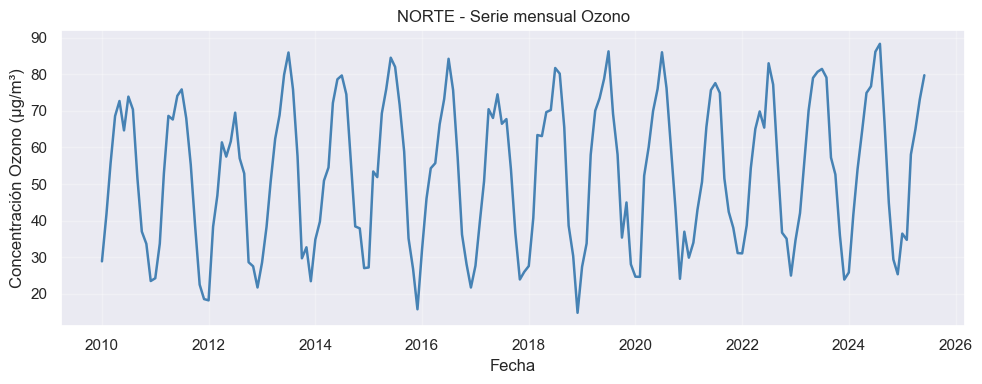


=== CENTRO ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG14\serie_mensual_CENTRO.png


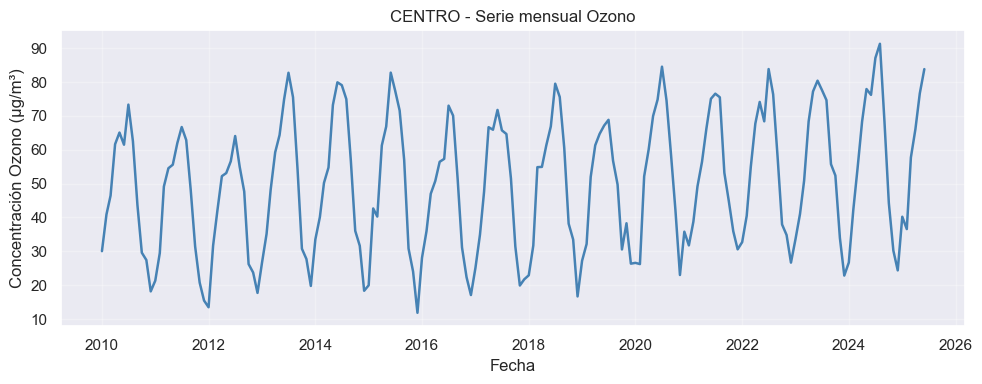


=== SUR ===


C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)


📁 Guardado gráfico en: 07_Figs\01_graficos_series_mensuales_MAG14\serie_mensual_SUR.png


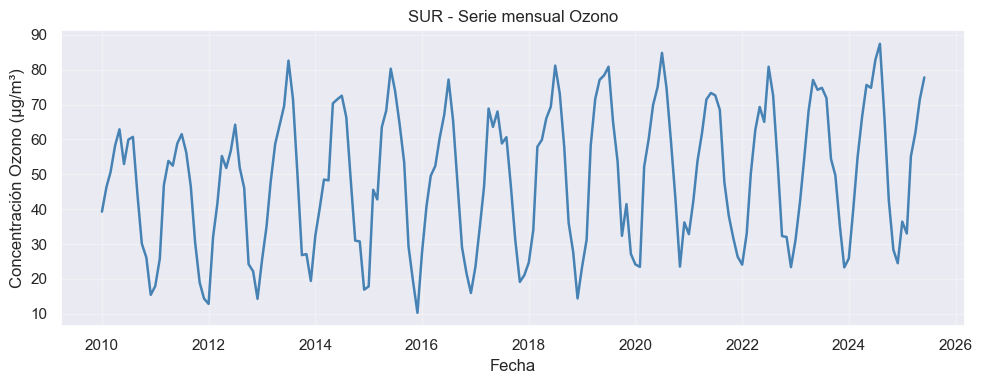

In [51]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "01_graficos_series_mensuales_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)

# Crea la carpeta general y la subcarpeta si no existen
os.makedirs(CARPETA_SALIDA, exist_ok=True)

MAPA_MES = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

dfs_zonas = {
    "NORTE":  df_14_norte,
    "CENTRO": df_14_centro,
    "SUR":    df_14_sur
}

series_zonas = {}

for zona, df in dfs_zonas.items():
    print(f"\n=== {zona} ===")

    # 1. Agregación mensual
    df_mensual = agrupar_mensual(df)

    # 2. Serie temporal mensual limpia
    serie = preparar_serie_mensual(df_mensual)
    series_zonas[zona] = serie

    # 3. Definir nombre del archivo PNG
    nombre_png = os.path.join(CARPETA_SALIDA, f"serie_mensual_{zona}.png")

    # 4. Graficar y guardar sin mostrar
    plot_serie(serie, f"{zona} - Serie mensual Ozono", nombre_salida=nombre_png, mostrar=True)

**TENDENCIA**

- Ligera tendencia ascendente. Más palpable en las zonas CENTRO y SUR.

**ESTACIONALIDAD**

- Las tres series (NORTE, SUR y CENTRO) muestran una estacionalidad muy marcada.
- Máximos de ozono en verano y mínimos en invierno.
- El SUR presenta mayor amplitud estacional, mientras que el NORTE muestra variaciones más suaves. En conjunto, las diferencias entre zonas responden sobre todo a factores climáticos y no a cambios estructurales en las emisiones.
- Por tanto, a simple vista, d posría ser:
    * 0 para las zonas CENTRO y NORTE.
    * 0 ó 1 para la zona SUR.
  

#### 2) DIFERENCIAR (d) HASTA SERIE ESTACIONARIA

Para cada zona (NORTE, CENTRO, SUR):
- Aplicar el test de Dickey–Fuller aumentado (ADF) sobre la serie original.
- Si no es estacionaria (p > 0.05), diferenciar una vez y volver a comprobar.
- Repetir hasta alcanzar estacionariedad o un máximo de 2 diferencias. Más de 2, podría introducir ruido y generar sobreajuste.
- Guardar los gráficos: 1) Serie original, 2) Serie diferenciada (una o dos veces)

In [52]:
# -------------------------------------------------
# Configuración de carpetas
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "02_diferenciacion_ARIMA_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Bucle principal por zona
# -------------------------------------------------
resultados_d = []

for zona, serie in series_zonas.items():
    print(f"\n=== {zona} ===")

    carpeta_zona = os.path.join(CARPETA_SALIDA, zona)
    os.makedirs(carpeta_zona, exist_ok=True)

    # Paso 1: test ADF en serie original
    p0 = test_adf(serie, f"{zona} original")
    plot_serie_diferenciada(serie, f"{zona} - Serie original", os.path.join(carpeta_zona, "serie_original.png"))

    d_opt = 0 # Inicializo iteración
    serie_dif = serie.copy()

    # Paso 2: diferenciar si no estacionaria
    while p0 > 0.05 and d_opt < 2:
        d_opt += 1 # Aumento en +1 la iteración
        serie_dif = diferencia_serie(serie, d=d_opt)
        p0 = test_adf(serie_dif, f"{zona} Δ{d_opt}")
        plot_serie_diferenciada(serie_dif, f"{zona} - Serie diferenciada Δ{d_opt}", 
                                os.path.join(carpeta_zona, f"serie_diferenciada_d{d_opt}.png"))

    # Guardar resultado
    estacionaria = "Sí" if p0 <= 0.05 else "No"
    resultados_d.append({
        "Zona": zona,
        "d_optimo": d_opt,
        "p_final": round(p0, 4),
        "Estacionaria": estacionaria
    })

# -------------------------------------------------
# Resumen final
# -------------------------------------------------
df_est = pd.DataFrame(resultados_d)
print("\n>>> RESULTADOS DIFERENCIACIÓN <<<")
print(df_est.to_string(index=False))


=== NORTE ===
ADF NORTE original: estadístico=-1.594, p-valor=0.4864
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\NORTE\serie_original.png
ADF NORTE Δ1: estadístico=-13.321, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\NORTE\serie_diferenciada_d1.png

=== CENTRO ===
ADF CENTRO original: estadístico=-0.555, p-valor=0.8808
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\CENTRO\serie_original.png
ADF CENTRO Δ1: estadístico=-12.530, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\CENTRO\serie_diferenciada_d1.png

=== SUR ===
ADF SUR original: estadístico=-0.968, p-valor=0.7647
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\SUR\serie_original.png
ADF SUR Δ1: estadístico=-12.721, p-valor=0.0000
📁 Guardado gráfico: 07_Figs\02_diferenciacion_ARIMA_MAG14\SUR\serie_diferenciada_d1.png

>>> RESULTADOS DIFERENCIACIÓN <<<
  Zona  d_optimo  p_final Estacionaria
 NORTE         1      0.0           Sí
CENTRO       

Con lo cual se concluye que todas las zonas requieren de una diferenciación.

#### 3) EVALUAR GRÁFICOS ACF y PACF → AYUDAN A ELEGIR p y q

In [53]:
# -------------------------------------------------
# Config carpeta salida para esta fase
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "03_acf_pacf_ARIMA_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Calculo zona por zona
# -------------------------------------------------
resumen_modelado = []

# Pasamos resultados_d (lista de dicts) a dict indexado por zona para acceso rápido
d_por_zona = {fila["Zona"]: fila["d_optimo"] for fila in resultados_d}

for zona, serie_original in series_zonas.items():
    print(f"\n=== {zona} ===")

    # 1) d óptimo encontrado en la fase anterior
    d_opt = d_por_zona[zona]

    # 2) construyo la serie estacionaria aplicando esa d
    serie_estacionaria = aplicar_diferenciacion(serie_original, d_opt)

    # 3) guardo ACF y PACF en disco
    guardar_acf_pacf(serie_estacionaria, zona, CARPETA_SALIDA, lags=49) # lag = 49 (equivalente a 4 años)

    # 4) registro info útil para elegir p y q
    resumen_modelado.append({
        "Zona": zona,
        "d": d_opt,
        "n_obs_estacionaria": len(serie_estacionaria)
    })

# 5) resumen en dataframe
df_resumen_modelado = pd.DataFrame(resumen_modelado)
print("\n>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<")
print(df_resumen_modelado.to_string(index=False))


=== NORTE ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\NORTE\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\NORTE\pacf.png

=== CENTRO ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\CENTRO\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\CENTRO\pacf.png

=== SUR ===
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\SUR\acf.png
📁 Guardado: 07_Figs\03_acf_pacf_ARIMA_MAG14\SUR\pacf.png

>>> RESUMEN PARA ESTIMACIÓN ARIMA <<<
  Zona  d  n_obs_estacionaria
 NORTE  1                 185
CENTRO  1                 185
   SUR  1                 185


<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

**INTERPRETACIÓN**

*NORTE*
- ACF: muestra una clara repetición anual (lag 12), confirmando fuerte estacionalidad.
- PACF: cae bruscamente tras el primer rezago, lo que sugiere un modelo AR(1) con componente estacional
- ACF decae de forma gradual → hace falta una parte MA. MA(1)
- Candidato principal: ARIMA(1,1,1)

*CENTRO*
- ACF: muy similar al norte, sin correlaciones persistentes (lag 12 muy marcado)
- PACF: con caída temprana, lo que sugiere un modelo AR(1) con componente estacional
- ACF decae de forma gradual → hace falta una parte MA.
- Candidato principal: ARIMA(1,1,1)

*SUR*
- Misma estacionalidad anual.
- PACF: también corta pronto → AR bajo.
- ACF: Simliar a las otras zonas
- Candidato principal: ARIMA(1,1,1). Alternativa: ARIMA(1,1,2)

#### 4) COMPARAR ARIMAS CON AIC

In [54]:
# ================================================
# Lista para almacenar RMSE de todos los modelos
# ================================================
rmse_candidatos = []

candidatos_por_zona = {
    "NORTE":  [(1,1,1), (1,1,2),(1,0,1),(1,0,2)],
    "CENTRO": [(1,1,1), (1,1,2),(1,0,1),(1,0,2)],
    "SUR":    [(1,1,1), (1,1,2),(1,0,1),(1,0,2)]
}

# -------------------------------------------------
# Bucle principal
# -------------------------------------------------
resultados_finales = []

for zona, serie in series_zonas.items():
    print(f"\n======================")
    print(f"ZONA {zona}")
    print(f"======================")

    # 1️⃣ División temporal
    train, test = train_test_split_temporal(serie, fecha_corte='2024-06-30')

    if len(test) == 0:
        print("No hay datos de test tras la fecha de corte. Se omite evaluación.")
        continue

    # 2️⃣ Evaluación de modelos candidatos
    mejor_aic = np.inf
    mejor_order = None
    mejor_ajuste = None

    for order in candidatos_por_zona[zona]:
        print(f"\nProbando ARIMA{order}...")
        aic_val, ajuste = ajustar_y_aic(train, order)

        # Guardar AIC
        if np.isfinite(aic_val):
            print(f"   AIC = {aic_val:.2f}")
        else:
            print("   Modelo no válido")

        # ====== Nuevo: calcular RMSE para cada modelo ======
        if ajuste is not None and np.isfinite(aic_val):
            pred_test_tmp = ajuste.forecast(steps=len(test))
            rmse_tmp = evaluar_modelo(
                f"ARIMA{order} ({zona})", test, pred_test_tmp
            )
        else:
            rmse_tmp = np.nan

        # Guardamos este candidato
        rmse_candidatos.append({
            "zona": zona,
            "order": order,
            "AIC": aic_val,
            "RMSE_test": rmse_tmp
        })
        # ====================================================

        # Selección de mejor modelo (por AIC)
        if aic_val < mejor_aic:
            mejor_aic = aic_val
            mejor_order = order
            mejor_ajuste = ajuste

    # 3️⃣ RMSE final del mejor modelo
    if mejor_ajuste is not None:
        pred_test = mejor_ajuste.forecast(steps=len(test))
        rmse_test = evaluar_modelo(f"ARIMA{mejor_order} ({zona})", test, pred_test)
    else:
        rmse_test = np.nan

    # 4️⃣ Guardar mejor modelo
    resultados_finales.append({
        "Zona": zona,
        "Mejor_(p,d,q)": mejor_order,
        "AIC": round(mejor_aic, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

    tabla_rmse_modelos.append({
        "modelo": "ARIMA",
        "zona": zona,
        "order": mejor_order,
        "seasonal_order": None,
        "AIC": mejor_aic,
        "RMSE_test": rmse_test
    })


# --------------------------------------------
# Convertir los resultados completos en DataFrame
# --------------------------------------------
df_rmse_candidatos = pd.DataFrame(rmse_candidatos)

print("\n>>> RMSE DE TODOS LOS MODELOS CANDIDATOS <<<")
print(df_rmse_candidatos.to_string(index=False))

# --------------------------------------------
# Tabla final por zona
# --------------------------------------------
df_resultados_arima = pd.DataFrame(resultados_finales)
print("\n>>> RESULTADOS ARIMA (Mejores modelos por zona) <<<")
print(df_resultados_arima.to_string(index=False))



ZONA NORTE

Probando ARIMA(1, 1, 1)...
   AIC = 1317.70
ARIMA(1, 1, 1) (NORTE) → RMSE: 30.951

Probando ARIMA(1, 1, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1306.13
ARIMA(1, 1, 2) (NORTE) → RMSE: 29.943

Probando ARIMA(1, 0, 1)...
   AIC = 1320.33
ARIMA(1, 0, 1) (NORTE) → RMSE: 19.871

Probando ARIMA(1, 0, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1283.93
ARIMA(1, 0, 2) (NORTE) → RMSE: 19.028
ARIMA(1, 0, 2) (NORTE) → RMSE: 19.028

ZONA CENTRO

Probando ARIMA(1, 1, 1)...
   AIC = 1299.47
ARIMA(1, 1, 1) (CENTRO) → RMSE: 27.894

Probando ARIMA(1, 1, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1286.93
ARIMA(1, 1, 2) (CENTRO) → RMSE: 26.291

Probando ARIMA(1, 0, 1)...
   AIC = 1304.42
ARIMA(1, 0, 1) (CENTRO) → RMSE: 20.946

Probando ARIMA(1, 0, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1267.54
ARIMA(1, 0, 2) (CENTRO) → RMSE: 20.669
ARIMA(1, 0, 2) (CENTRO) → RMSE: 20.669

ZONA SUR

Probando ARIMA(1, 1, 1)...
   AIC = 1310.35
ARIMA(1, 1, 1) (SUR) → RMSE: 28.765

Probando ARIMA(1, 1, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

   AIC = 1307.48
ARIMA(1, 1, 2) (SUR) → RMSE: 19.516

Probando ARIMA(1, 0, 1)...
   AIC = 1312.10


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1) (SUR) → RMSE: 19.456

Probando ARIMA(1, 0, 2)...


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


   AIC = 1280.43
ARIMA(1, 0, 2) (SUR) → RMSE: 18.894
ARIMA(1, 0, 2) (SUR) → RMSE: 18.894

>>> RMSE DE TODOS LOS MODELOS CANDIDATOS <<<
  zona     order         AIC  RMSE_test
 NORTE (1, 1, 1) 1317.702017  30.950791
 NORTE (1, 1, 2) 1306.127044  29.943423
 NORTE (1, 0, 1) 1320.330178  19.871036
 NORTE (1, 0, 2) 1283.926776  19.028048
CENTRO (1, 1, 1) 1299.474407  27.894280
CENTRO (1, 1, 2) 1286.925864  26.291427
CENTRO (1, 0, 1) 1304.416642  20.946211
CENTRO (1, 0, 2) 1267.539383  20.668924
   SUR (1, 1, 1) 1310.349506  28.765485
   SUR (1, 1, 2) 1307.479768  19.516492
   SUR (1, 0, 1) 1312.100022  19.455676
   SUR (1, 0, 2) 1280.426798  18.894108

>>> RESULTADOS ARIMA (Mejores modelos por zona) <<<
  Zona Mejor_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (1, 0, 2) 1283.93     19.028      174      12
CENTRO     (1, 0, 2) 1267.54     20.669      174      12
   SUR     (1, 0, 2) 1280.43     18.894      174      12


**MODELOS ELEGIDOS**

- NORTE: ARIMA (1, 0, 2)
- CENTRO: ARIMA (1, 0, 2)
- SUR: ARIMA (1, 0, 2)


#### 5) ENTRENAR MODELO FINAL Y GENERAR PREDICCIONES

In [55]:
# -------------------------------------------------
# Configuración de carpetas de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "04_predicciones_finales_ARIMA_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) (NORTE) → RMSE: 19.028
📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG14\predicciones_NORTE.png


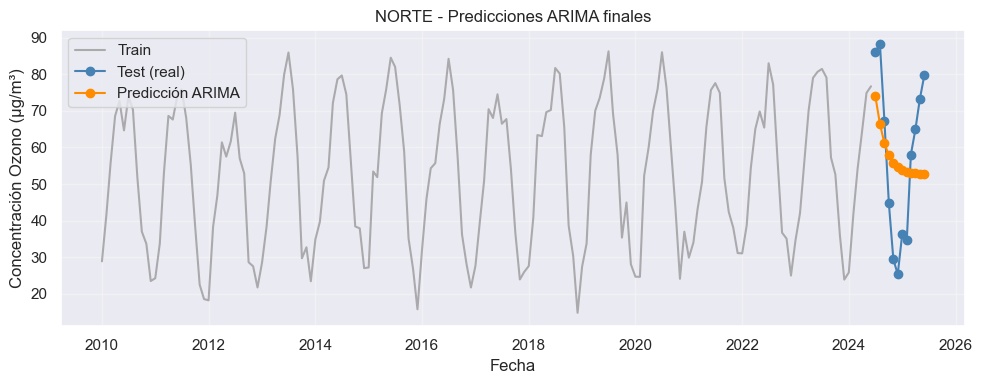


=== ZONA CENTRO ===
ARIMA(1, 0, 2) (CENTRO) → RMSE: 20.669


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG14\predicciones_CENTRO.png


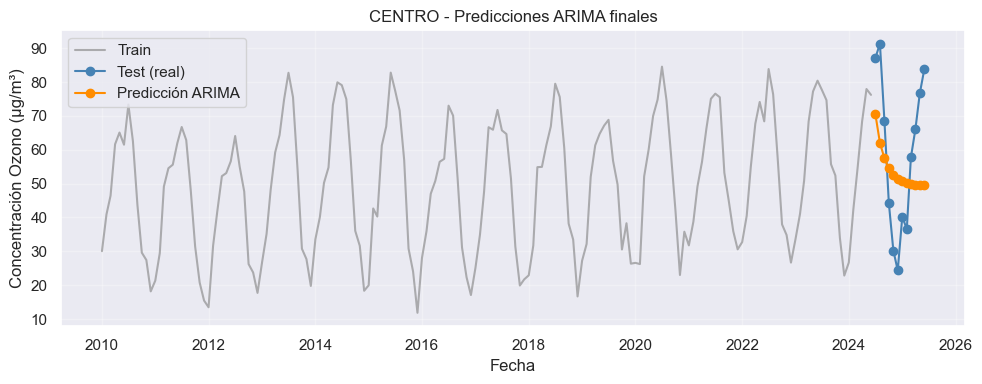


=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 2) (SUR) → RMSE: 18.894
📁 Guardado gráfico: 07_Figs\04_predicciones_finales_ARIMA_MAG14\predicciones_SUR.png


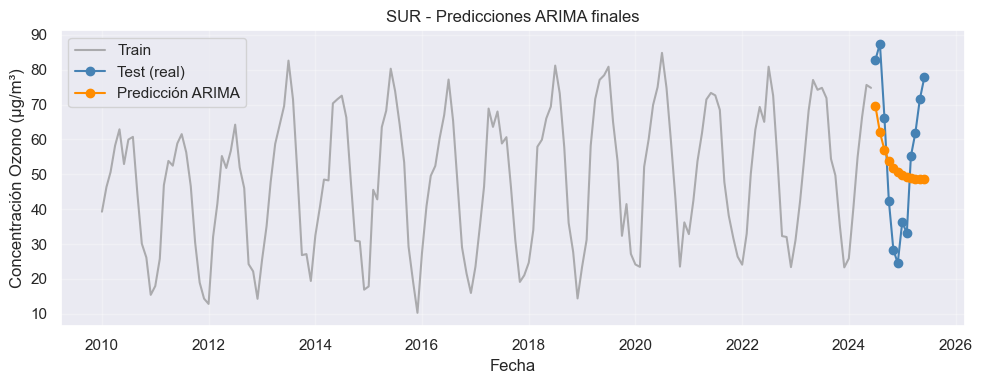


>>> RESULTADOS FINALES ARIMA <<<
  Zona ARIMA_(p,d,q)     AIC  RMSE_test  n_train  n_test
 NORTE     (1, 0, 2) 1283.93     19.028      174      12
CENTRO     (1, 0, 2) 1267.54     20.669      174      12
   SUR     (1, 0, 2) 1280.43     18.894      174      12


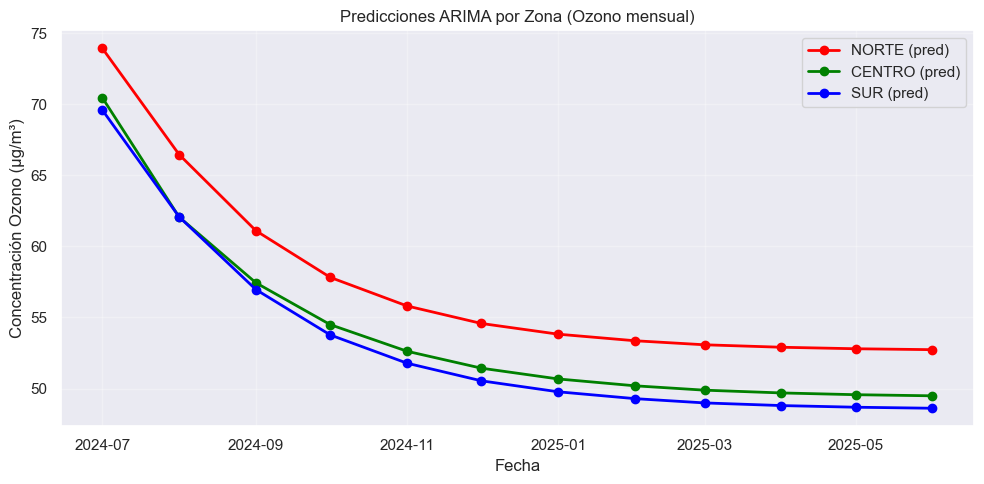


📁 Guardado gráfico combinado: 07_Figs\04_predicciones_finales_ARIMA_MAG14\predicciones_conjuntas_zonas.png


In [56]:
# -------------------------------------------------
# MODELOS FINALES (según selección previa)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,0,2),
    "CENTRO": (1,0,2),
    "SUR":    (1,0,2)
}

# -------------------------------------------------
# ENTRENAMIENTO Y PREDICCIONES POR ZONA
# -------------------------------------------------
resultados_pred = []
predicciones_zonas = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]
    train, test = train_test_split_temporal(serie, fecha_corte="2024-06-30")

    # Entrenamiento del modelo
    modelo = ARIMA(train, order=order)
    ajuste = modelo.fit()

    # Predicción sobre el conjunto de test
    pred_test = ajuste.forecast(steps=len(test))

    # Evaluación (usando tu función)
    rmse_test = evaluar_modelo(f"ARIMA{order} ({zona})", test, pred_test)
    aic_modelo = ajuste.aic

    # Guardar y mostrar gráfico individual
    nombre_png = os.path.join(CARPETA_SALIDA, f"predicciones_{zona}.png")
    plot_predicciones(zona, train, test, pred_test, nombre_png, mostrar=True)

    # Guardar dataframe de predicciones
    predicciones_zonas[zona] = pd.DataFrame({
        "real": test.values,
        "pred": pred_test.values
    }, index=test.index)

    # Registrar resultados
    resultados_pred.append({
        "Zona": zona,
        "ARIMA_(p,d,q)": order,
        "AIC": round(aic_modelo, 2),
        "RMSE_test": round(rmse_test, 3),
        "n_train": len(train),
        "n_test": len(test)
    })

# -------------------------------------------------
# TABLA RESUMEN FINAL
# -------------------------------------------------
df_pred = pd.DataFrame(resultados_pred)
print("\n>>> RESULTADOS FINALES ARIMA <<<")
print(df_pred.to_string(index=False))

# -------------------------------------------------
# GRÁFICO CONJUNTO: PREDICCIONES DE LAS 3 ZONAS
# -------------------------------------------------
plt.figure(figsize=(10,5))

colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, df_pred in predicciones_zonas.items():
    plt.plot(df_pred.index, df_pred["pred"], marker="o", linewidth=2,
             color=colores.get(zona, None), label=f"{zona} (pred)")

plt.title("Predicciones ARIMA por Zona (Ozono mensual)")
plt.xlabel("Fecha")
plt.ylabel("Concentración Ozono (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_zonas.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

#### 6) PREDICCIÓN HASTA DICIEMBRE 2030 Y 2032


=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


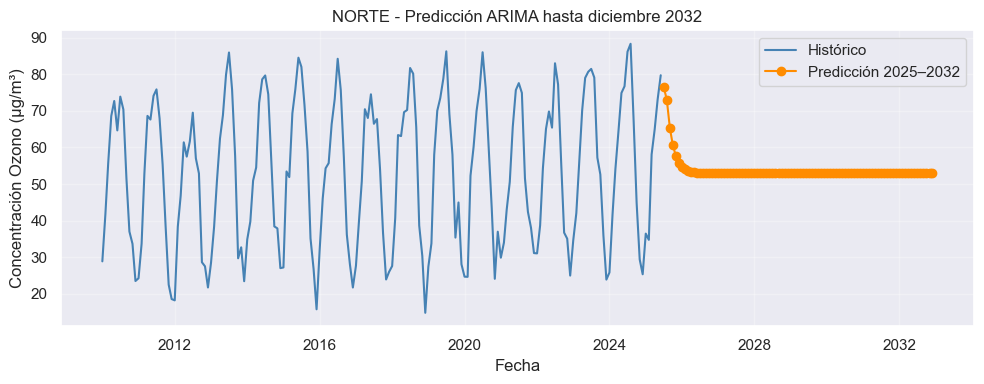

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\prediccion_2032_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


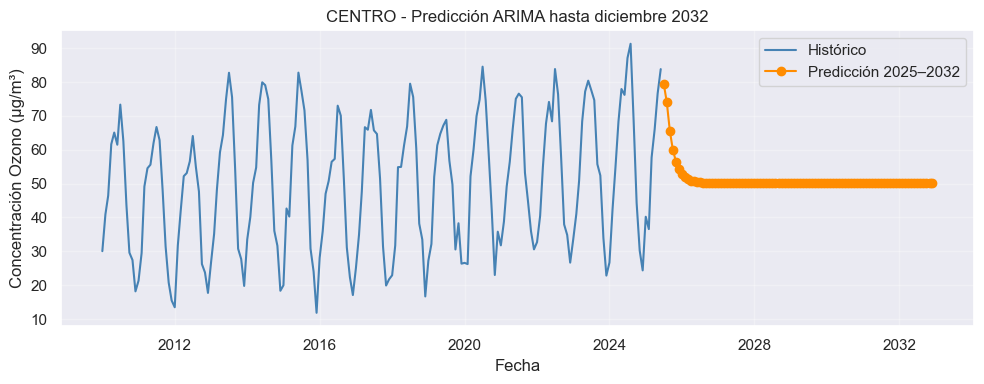

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\prediccion_2032_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


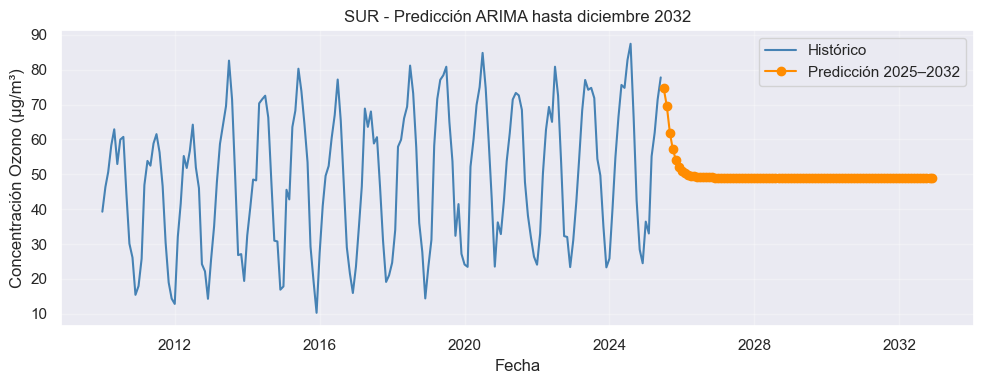

📁 Guardado gráfico: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\prediccion_2032_SUR.png


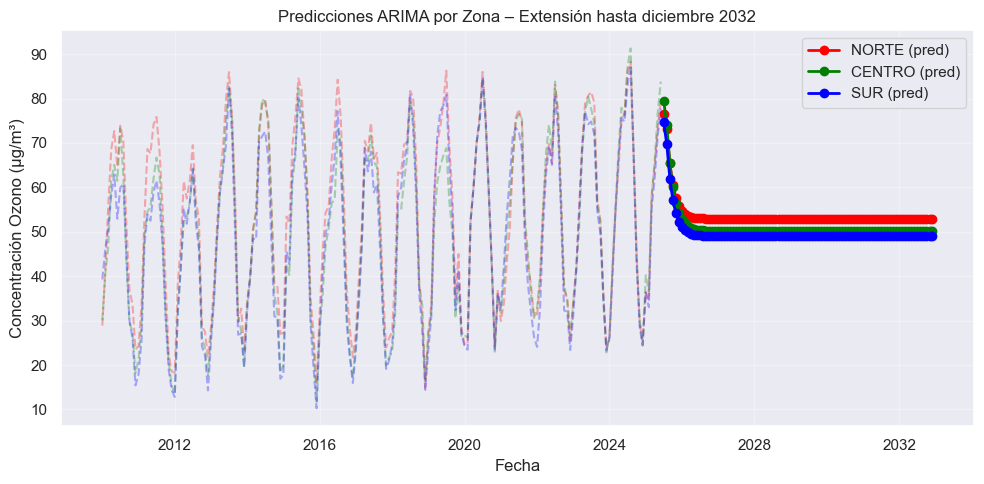


📁 Guardado gráfico combinado: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\predicciones_conjuntas_2032.png

📁 Guardado CSV con predicciones completas: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\predicciones_Ozono_hasta_2032.csv

>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<
 Ozono_pred_NORTE  Ozono_pred_CENTRO  Ozono_pred_SUR
           52.941             50.202          49.074

>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<
            Ozono_pred_NORTE  Ozono_pred_CENTRO  Ozono_pred_SUR
2030-01-01            52.941             50.202          49.074
2030-02-01            52.941             50.202          49.074
2030-03-01            52.941             50.202          49.074
2030-04-01            52.941             50.202          49.074
2030-05-01            52.941             50.202          49.074
2030-06-01            52.941             50.202          49.074
2030-07-01            52.941             50.202          49.074
2030-08-01            52.941             50.2

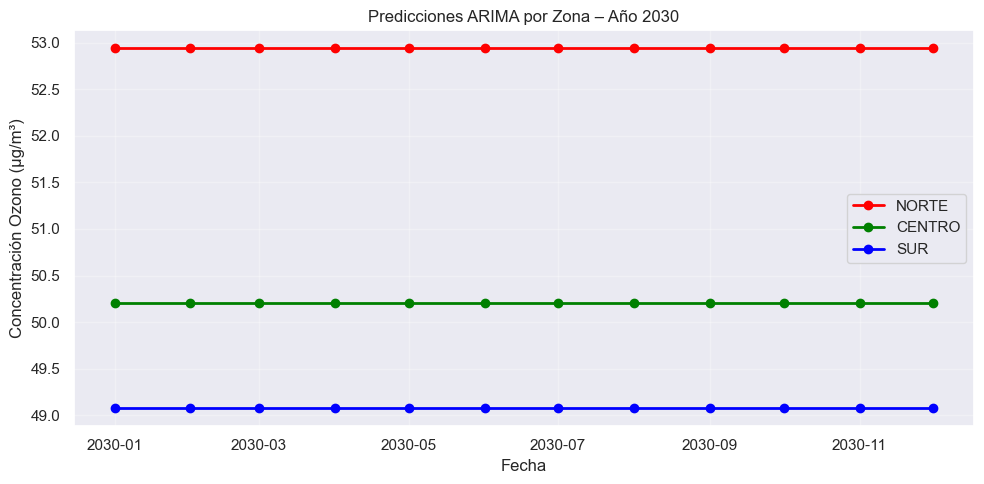


📁 Guardado gráfico 2030: 07_Figs\05_predicciones_largo_plazo_ARIMA_MAG14\predicciones_conjuntas_2030.png


In [57]:
# -------------------------------------------------
# Configuración de carpeta de salida
# -------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "05_predicciones_largo_plazo_ARIMA_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# -------------------------------------------------
# Modelos finales por zona (ya validados)
# -------------------------------------------------
modelos_finales = {
    "NORTE":  (1,0,2),
    "CENTRO": (1,0,2),
    "SUR":    (1,0,2)
}

# -------------------------------------------------
# Horizonte de predicción
# -------------------------------------------------
fecha_final_pred = "2032-12-31"

# -------------------------------------------------
# Bucle de predicción por zona
# -------------------------------------------------
predicciones_largo_plazo = {}

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    order = modelos_finales[zona]

    # Entrenamiento con toda la serie disponible
    modelo = ARIMA(serie, order=order)
    ajuste = modelo.fit()

    # Número de meses a predecir
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(1),
                              end=fecha_final_pred, freq="MS")
    n_steps = len(horizonte)

    # Predicción a largo plazo
    pred = ajuste.forecast(steps=n_steps)
    pred.index = horizonte

    # Guardamos los resultados
    predicciones_largo_plazo[zona] = pred

    # -------------------------------------------------
    # Gráfico por zona
    # -------------------------------------------------
    plt.figure(figsize=(10,4))
    plt.plot(serie.index, serie.values, label="Histórico", color="steelblue")
    plt.plot(pred.index, pred.values, label="Predicción 2025–2032", color="darkorange", marker="o")
    plt.title(f"{zona} - Predicción ARIMA hasta diciembre 2032")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"prediccion_2032_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# -------------------------------------------------
# Gráfico combinado (todas las zonas)
# -------------------------------------------------
plt.figure(figsize=(10,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, pred in predicciones_largo_plazo.items():
    plt.plot(pred.index, pred.values, color=colores[zona], linewidth=2, marker="o", label=f"{zona} (pred)")
    plt.plot(series_zonas[zona].index, series_zonas[zona].values, color=colores[zona], alpha=0.3, linestyle="--")

plt.title("Predicciones ARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración Ozono (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2032.png")
plt.savefig(ruta_figura, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico combinado: {ruta_figura}")

# -------------------------------------------------
# Tabla resumen de predicciones finales
# -------------------------------------------------
df_pred_2032 = pd.concat(predicciones_largo_plazo, axis=1)
df_pred_2032.columns = [f"Ozono_pred_{zona}" for zona in df_pred_2032.columns]

# Guardar CSV con todas las predicciones
csv_path = os.path.join(CARPETA_SALIDA, "predicciones_Ozono_hasta_2032.csv")
df_pred_2032.to_csv(csv_path)
print(f"\n📁 Guardado CSV con predicciones completas: {csv_path}")

print("\n>>> ÚLTIMAS PREDICCIONES (diciembre 2032) <<<")
print(df_pred_2032.tail(1).round(3).to_string(index=False))

# -------------------------------------------------
# PREDICCIONES DEL AÑO 2030
# -------------------------------------------------
# Filtrar las filas correspondientes a 2030
df_pred_2030 = df_pred_2032[df_pred_2032.index.year == 2030]

print("\n>>> PREDICCIONES ANUALES (enero–diciembre 2030) <<<")
print(df_pred_2030.round(3).to_string())

# Guardar CSV con predicciones 2030
csv_2030_path = os.path.join(CARPETA_SALIDA, "predicciones_Ozono_2030.csv")
df_pred_2030.to_csv(csv_2030_path)
print(f"\n📁 Guardado CSV con predicciones de 2030: {csv_2030_path}")

# -------------------------------------------------
# Promedio anual de 2030 por zona
# -------------------------------------------------
promedios_2030 = df_pred_2030.mean().round(3)
print("\n>>> PROMEDIO ANUAL PREVISTO PARA 2030 (µg/m³) <<<")
print(promedios_2030)

# Volcado de predicciones ARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    # Para cada zona tenemos la serie mensual 2030: df_pred_2030[f"Ozono_pred_{zona}"]
    serie_zona_2030 = df_pred_2030[f"Ozono_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "ARIMA",
            "zona": zona,
            "fecha": fecha,                   # índice tipo Timestamp
            "anio": fecha.year,               # 2030
            "mes": fecha.month,               # 1..12
            "pred_2030": valor_predicho,      # µg/m³
            "promedio_anual_2030": promedios_2030[f"Ozono_pred_{zona}"]
        })

# -------------------------------------------------
# Gráfico conjunto de las tres zonas – año 2030
# -------------------------------------------------
plt.figure(figsize=(10,5))
for zona, color in {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"Ozono_pred_{zona}"], marker="o",
             linewidth=2, color=color, label=zona)

plt.title("Predicciones ARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración Ozono (µg/m³)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

ruta_figura_2030 = os.path.join(CARPETA_SALIDA, "predicciones_conjuntas_2030.png")
plt.savefig(ruta_figura_2030, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Guardado gráfico 2030: {ruta_figura_2030}")

#### 7) RESUMEN METODOLÓGICO

1.	Se representa la serie temporal de concentración de partículas y se inspecciona visualmente la presencia de tendencia y patrones repetitivos (estacionalidad).
2.	Se aplica diferenciación sucesiva y se contrasta con el test ADF hasta obtener una serie estacionaria. Ese número de diferenciaciones se toma como el parámetro d del modelo ARIMA(p,d,q).
3.	Sobre la serie estacionaria se analizan las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). Los cortes significativos en PACF sugieren candidatos para p, y en ACF para q.
4.	Con esos candidatos se ajustan distintos modelos ARIMA(p,d,q) sobre el conjunto de entrenamiento y se selecciona el modelo con menor AIC, ya que el AIC penaliza la complejidad del modelo y favorece especificaciones parsimoniosas.
5.	El modelo ARIMA seleccionado se entrena con los datos históricos (train) y se utiliza para predecir el tramo de prueba (test).
6.	El rendimiento predictivo se evalúa con métricas fuera de muestra como RMSE.
7.  En base a los modelos óptimos obtenidos, se extraen los gráficos de predicción hasta 2030 y 2032.

#### 8) CONCLUSION

Los gráficos de predicción a largo plazo son planas, sin apenas estacionalidad ni tendencia visible a partir de 2025. Esto es un síntoma clásico de que los modelos ARIMA que elegimos están sobreajustados al ruido a corto plazo o que la diferenciación eliminó completamente la estructura temporal.

Es, por ello, por lo que vamos a aolizar modelos SARIMA que permite oscilaciones en el horizonte largo.

### MODELO SARIMA (Seasonal ARIMA)

El modelo SARIMA (Seasonal AutoRegressive Integrated Moving Average) es una extensión del modelo ARIMA diseñada específicamente para manejar datos de series temporales que presentan patrones estacionales. Su notación completa es:

*SARIMA(p,d,q)(P,D,Q,s)*

- 𝑝, 𝑑, 𝑞 --> Componentes no estacionales. Permite captar tendencias a corto plazo.
- P, D, Q --> componentes estacionales. Permite captar patrones estacionales.
- s --> Periodicidad de la estacionalidad (12 para datos mensuales).

Para las tres zonas (NORTE, CENTRO y SUR) se proponen los mismos valores:
- D = 0: no se aplica diferenciación estacional, ya que las series muestran un patrón anual estable sin deriva estructural.
- P = 1: cada observación está influida por el valor registrado en el mismo mes del año anterior.
- Q = 1: incluye un término de media móvil estacional que corrige los errores de predicción de ese mismo periodo.

De modo que:



=== ZONA NORTE ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NORTE (test) → RMSE: 5.641


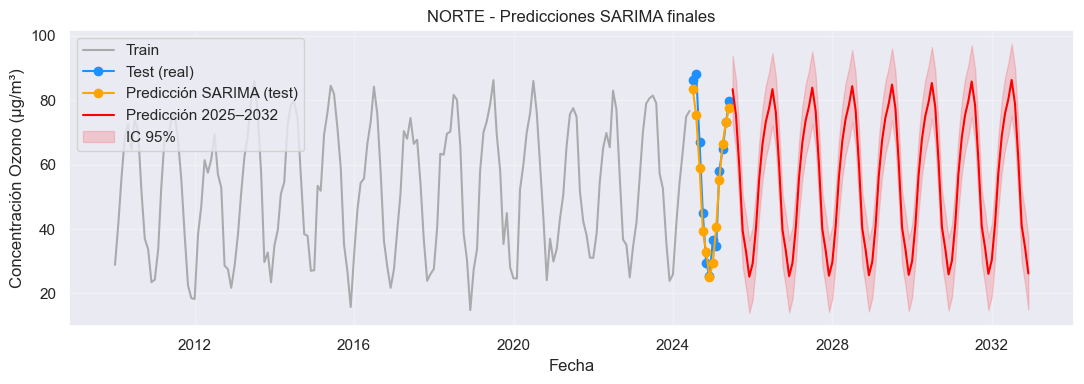

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG14\SARIMA_predicciones_NORTE.png

=== ZONA CENTRO ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


CENTRO (test) → RMSE: 6.784


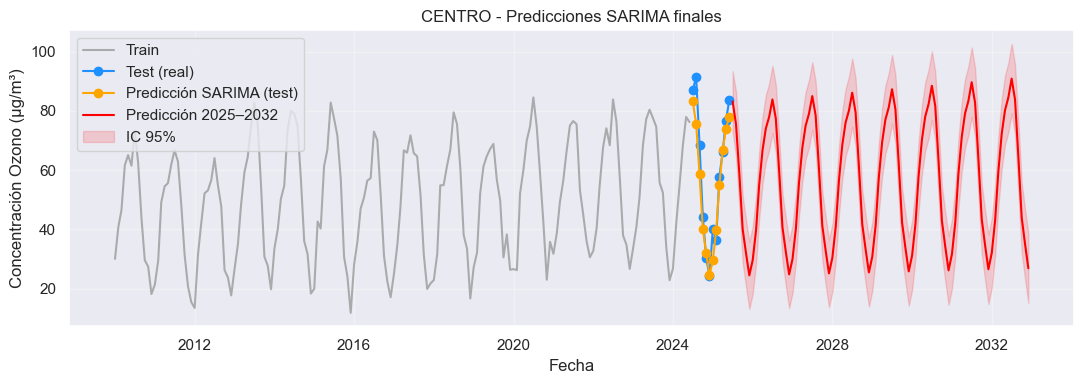

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG14\SARIMA_predicciones_CENTRO.png

=== ZONA SUR ===


C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rosal\.conda\envs\cristobal\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SUR (test) → RMSE: 6.454


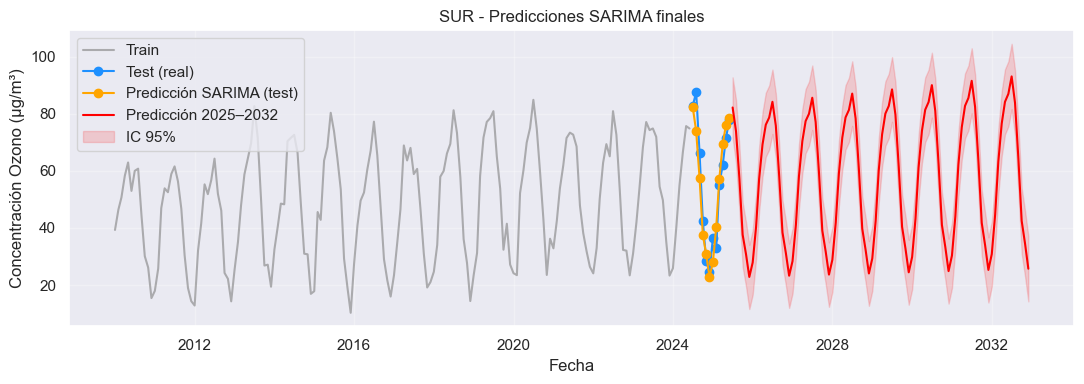

📁 Guardado gráfico: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG14\SARIMA_predicciones_SUR.png

📁 Guardado CSV: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG14\SARIMA_predicciones_Ozono_hasta_2032.csv

>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<
 Ozono_pred_NORTE  Ozono_pred_CENTRO  Ozono_pred_SUR
           26.213             26.874          25.707

📁 Guardado CSV 2030: 07_Figs\06_predicciones_largo_plazo_SARIMA_MAG14\SARIMA_predicciones_Ozono_2030.csv

>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<
Ozono_pred_NORTE     56.263
Ozono_pred_CENTRO    58.135
Ozono_pred_SUR       58.825
dtype: float64


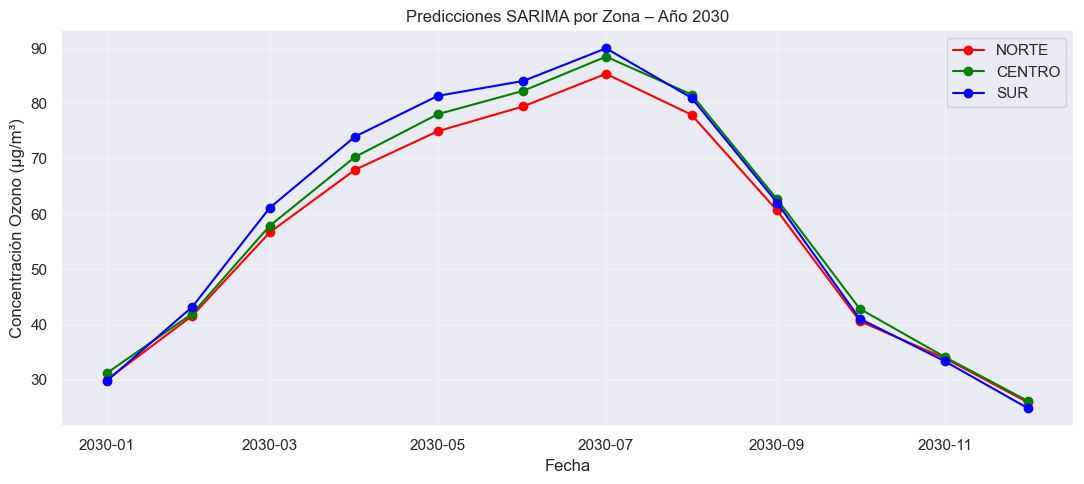

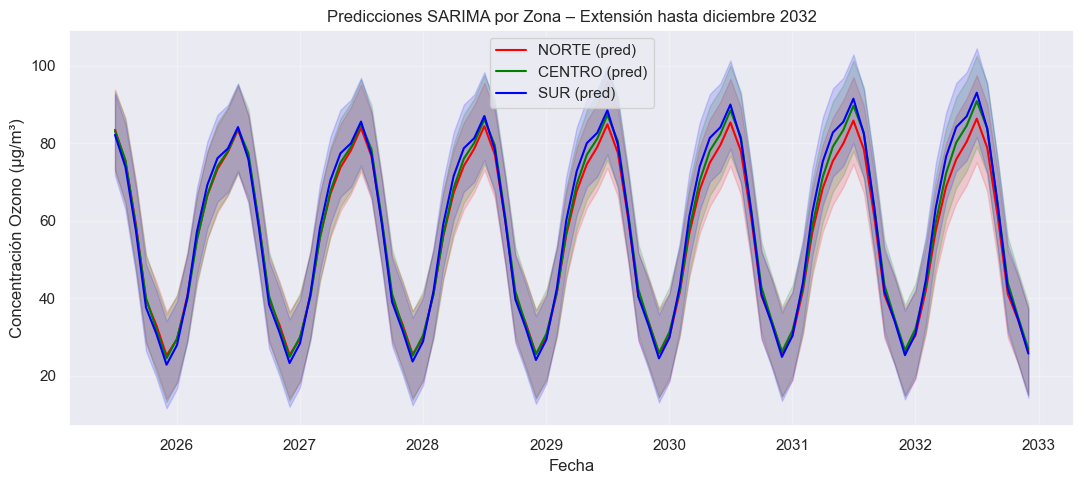


>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<
  Zona     order seasonal_order     AIC  RMSE_test  n_obs  RMSE_test_ARIMA
 NORTE (1, 0, 2)  (1, 0, 1, 12) 1016.15      5.641    186           19.028
CENTRO (1, 0, 2)  (1, 0, 1, 12) 1006.25      6.784    186           20.669
   SUR (1, 0, 2)  (1, 0, 1, 12) 1019.15      6.454    186           18.894


In [58]:

# =================================================
# 1. CONFIGURACIÓN DE CARPETAS
# =================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA = "06_predicciones_largo_plazo_SARIMA_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 3️⃣ Definir modelos SARIMA por zona
# ==========================================================
modelos_sarima = {
    "NORTE":  {"order": (1,0,2), "seasonal_order": (1,0,1,12)},
    "CENTRO": {"order": (1,0,2), "seasonal_order": (1,0,1,12)},
    "SUR":    {"order": (1,0,2), "seasonal_order": (1,0,1,12)}
}

# ==========================================================
# 4️⃣ Horizonte de predicción
# ==========================================================
fecha_final_pred = "2032-12-31"
fecha_corte = "2024-06-30"  # corte temporal para evaluar RMSE

# ==========================================================
# 5️⃣ Bucle por zona: entrenar, evaluar, predecir largo plazo
# ==========================================================
predicciones_largo_plazo = {}
resultados_info = []

for zona, serie in series_zonas.items():
    print(f"\n=== ZONA {zona} ===")

    # Dividir train/test
    train = serie.loc[:fecha_corte]
    test = serie.loc[fecha_corte:]

    order = modelos_sarima[zona]["order"]
    seasonal_order = modelos_sarima[zona]["seasonal_order"]

    # --------------------------
    # Ajustar SARIMA
    # --------------------------
    modelo = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    ajuste = modelo.fit(disp=False)

    # --------------------------
    # Predicción sobre test
    # --------------------------
    pred_test = ajuste.get_forecast(steps=len(test))
    pred_mean = pred_test.predicted_mean
    rmse = evaluar_modelo(f"{zona} (test)", test, pred_mean)

    # Guardar RMSE SARIMA por zona
  # Guardar RMSE SARIMA por zona
    tabla_rmse_modelos.append({
        "modelo": "SARIMA",
        "zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": rmse
    })

    # --------------------------
    # Predicción a largo plazo (2025–2032)
    # --------------------------
    ultimo_mes = serie.index.max()
    horizonte = pd.date_range(
        start=ultimo_mes + pd.offsets.MonthBegin(1),
        end=fecha_final_pred,
        freq="MS"
    )
    n_steps = len(horizonte)
    forecast_res = ajuste.get_forecast(steps=n_steps)

    pred_media = forecast_res.predicted_mean
    ic = forecast_res.conf_int(alpha=0.05)
    pred_media.index = horizonte
    ic.index = horizonte
    ic.columns = ["ic_inf", "ic_sup"]

    # Guardar resultados
    df_pred = pd.DataFrame({
        "pred": pred_media,
        "ic_inf": ic["ic_inf"],
        "ic_sup": ic["ic_sup"]
    })
    predicciones_largo_plazo[zona] = df_pred

    # --------------------------
    # Información de modelo
    # --------------------------
    resultados_info.append({
        "Zona": zona,
        "order": order,
        "seasonal_order": seasonal_order,
        "AIC": round(ajuste.aic, 2),
        "RMSE_test": round(rmse, 3),
        "n_obs": len(serie)
    })

    # --------------------------
    # Gráfico por zona
    # --------------------------
    plt.figure(figsize=(11,4))
    plt.plot(train.index, train.values, color="gray", alpha=0.6, label="Train")
    plt.plot(test.index, test.values, color="dodgerblue", marker="o", label="Test (real)")
    plt.plot(pred_mean.index, pred_mean.values, color="orange", marker="o", label="Predicción SARIMA (test)")

    plt.plot(df_pred.index, df_pred["pred"], color="red", linewidth=1.5, label="Predicción 2025–2032")
    plt.fill_between(df_pred.index, df_pred["ic_inf"], df_pred["ic_sup"], color="red", alpha=0.15, label="IC 95%")

    plt.title(f"{zona} - Predicciones SARIMA finales")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    ruta_png = os.path.join(CARPETA_SALIDA, f"SARIMA_predicciones_{zona}.png")
    plt.savefig(ruta_png, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico: {ruta_png}")

# ==========================================================
# 6️⃣ Resumen de predicciones largo plazo
# ==========================================================
df_pred_all = pd.concat(
    {zona: predicciones_largo_plazo[zona]["pred"] for zona in predicciones_largo_plazo},
    axis=1
)
df_pred_all.columns = [f"Ozono_pred_{zona}" for zona in df_pred_all.columns]

# Guardar CSV
csv_todo = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_Ozono_hasta_2032.csv")
df_pred_all.to_csv(csv_todo)
print(f"\n📁 Guardado CSV: {csv_todo}")

# Última fila (dic 2032)
print("\n>>> PREDICCIÓN DICIEMBRE 2032 (SARIMA) <<<")
print(df_pred_all.tail(1).round(3).to_string(index=False))

# ==========================================================
# 7️⃣ Predicciones 2030 + Promedio anual
# ==========================================================
df_pred_2030 = df_pred_all[df_pred_all.index.year == 2030]
promedios_2030 = df_pred_2030.mean().round(3)

# Volcado de predicciones SARIMA 2030 en tabla global
for zona in ["NORTE", "CENTRO", "SUR"]:
    serie_zona_2030 = df_pred_2030[f"Ozono_pred_{zona}"]

    for fecha, valor_predicho in serie_zona_2030.items():
        tabla_predicciones_2030.append({
            "modelo": "SARIMA",
            "zona": zona,
            "fecha": fecha,
            "anio": fecha.year,
            "mes": fecha.month,
            "pred_2030": valor_predicho,
            "promedio_anual_2030": promedios_2030[f"Ozono_pred_{zona}"]
        })

csv_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_Ozono_2030.csv")
df_pred_2030.to_csv(csv_2030)
print(f"\n📁 Guardado CSV 2030: {csv_2030}")

print("\n>>> PROMEDIOS ANUALES 2030 (SARIMA) <<<")
print(promedios_2030)

# ==========================================================
# 8️⃣ Gráfico conjunto 2030
# ==========================================================
plt.figure(figsize=(11,5))
colores = {"NORTE": "red", "CENTRO": "green", "SUR": "blue"}

for zona, color in colores.items():
    plt.plot(df_pred_2030.index, df_pred_2030[f"Ozono_pred_{zona}"], color=color, marker="o", label=zona)

plt.title("Predicciones SARIMA por Zona – Año 2030")
plt.xlabel("Fecha")
plt.ylabel("Concentración Ozono (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2030 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2030.png")
plt.savefig(ruta_fig_2030, dpi=150)
plt.show()

# ==========================================================
# 9️⃣ Gráfico conjunto 2032 (predicciones largas)
# ==========================================================
plt.figure(figsize=(11,5))
for zona, color in colores.items():
    df_z = predicciones_largo_plazo[zona]
    plt.plot(df_z.index, df_z["pred"], color=color, label=f"{zona} (pred)")
    plt.fill_between(df_z.index, df_z["ic_inf"], df_z["ic_sup"], color=color, alpha=0.15)

plt.title("Predicciones SARIMA por Zona – Extensión hasta diciembre 2032")
plt.xlabel("Fecha")
plt.ylabel("Concentración Ozono (µg/m³)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

ruta_fig_2032 = os.path.join(CARPETA_SALIDA, "SARIMA_predicciones_conjuntas_2032.png")
plt.savefig(ruta_fig_2032, dpi=150)
plt.show()

# ==========================================================
# 🔟 Tabla resumen modelos (AIC, RMSE, etc.)
# ==========================================================

df_info = pd.DataFrame(resultados_info)
df_info ["RMSE_test_ARIMA"]=df_resultados_arima ["RMSE_test"]
print("\n>>> RESUMEN MODELOS SARIMA (AIC y RMSE) <<<")
print(df_info.to_string(index=False))

**CONCLUSIÓN:** Se comprueba que la predicción SARIMA mejora mucho la ARIMA, ya que el RMSE_test es más bajo

### MODELOS MACHINE LEARNING (CASTBOOST, LightGBM y XGBOOST)

Los modelos aplicados anteriormente (ARIMA/SARIMA) son modelos clásicos que aprenden la dinámica temporal interna de la serie directamente (usa rezagos, diferencias, estacionalidad). Sin embargo, en estos modelos no hemos considerado ninguna otra variable exógena, hemos hecho el análisis univariante sin más.

Los modelos de Machine Learning como CatBoost, LightGBM y XGBoost se basan en el algoritmo de Gradient Boosting y se caracterizan por lo siguiente:

- Son modelos supervisados de regresión tabular. Es decir: Son modelos que aprende a predecir una variable numérica continua a partir de datos estructurados en forma de tabla, usando un conjunto de datos donde ya se conoce el valor objetivo y contra lo que compararemos una vez el modelo haya porcedido a la predicción.
- Se debe construir el dataset: cada fila = un mes, con variables explicativas, y objetivo.
- No entienden por sí mismos la secuencia temporal. Se las tenemos que dar tú mediante: 1) lags (valores anteriores), 2) medias móviles, 3) mes del año, 4) tendencia temporal, 5) variables exógenas

**DIFERENCIAS ENTRE CASTBOOST, LightGBM y XGBOOST**

- *CatBoost*: Ideal cuando tienes muchas variables categóricas. Evita el preprocesamiento manual y es muy estable con pocos datos.
- *LightGBM*: Perfecto para grandes volúmenes de datos. Usa una estrategia de crecimiento por hojas (leaf-wise) que acelera el entrenamiento y mejora la precisión, aunque puede sobreajustar si no se regula.
- *XGBoost*: El más veterano y versátil. Rendimiento sólido y facilidad de ajuste.


#### 1) DEFINIR OBJETIVO

En este apartado sólo vamos a definir la parte de los datos que luego vamos a predecir.

In [59]:
objetivos_por_zona = {}

for zona, serie in series_zonas.items():
    # Aseguramos nombre claro
    serie_objetivo = serie.copy()
    serie_objetivo.name = "Ozono_objetivo"

    # Aseguramos que el índice sea DatetimeIndex mensual ordenado
    serie_objetivo = serie_objetivo.sort_index()
    if not isinstance(serie_objetivo.index, pd.DatetimeIndex):
        raise ValueError(f"La serie de {zona} no tiene un DatetimeIndex. Revisa preparar_serie_mensual().")

    # Guardamos para futuros pasos
    objetivos_por_zona[zona] = serie_objetivo

    # Mostramos un pequeño resumen para inspección
    print(f"\n=== {zona} ===")
    print("Primeras filas:")
    print(serie_objetivo.head())
    print("Últimas filas:")
    print(serie_objetivo.tail())
    print(f"Rango temporal: {serie_objetivo.index.min().date()} -> {serie_objetivo.index.max().date()}")
    print(f"Nº de observaciones mensuales: {len(serie_objetivo)}")



=== NORTE ===
Primeras filas:
fecha
2010-01-01    28.887097
2010-02-01    41.848214
2010-03-01    55.645161
2010-04-01    68.600000
2010-05-01    72.693548
Name: Ozono_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    34.758929
2025-03-01    58.080645
2025-04-01    64.963267
2025-05-01    73.169355
2025-06-01    79.733333
Name: Ozono_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== CENTRO ===
Primeras filas:
fecha
2010-01-01    30.045699
2010-02-01    40.907738
2010-03-01    46.443548
2010-04-01    61.627778
2010-05-01    65.069892
Name: Ozono_objetivo, dtype: float64
Últimas filas:
fecha
2025-02-01    36.568452
2025-03-01    57.712366
2025-04-01    66.093211
2025-05-01    76.639785
2025-06-01    83.808333
Name: Ozono_objetivo, dtype: float64
Rango temporal: 2010-01-01 -> 2025-06-01
Nº de observaciones mensuales: 186

=== SUR ===
Primeras filas:
fecha
2010-01-01    39.282258
2010-02-01    46.375000
2010-03-01    50.653

#### 2) CONSTRUCCIÓN DATASETS ENTRENAMIENTO/TEST/VALIDACIÓN

In [60]:
# ================================================================
# 0️⃣ Definición de variables relevantes (ya identificadas)
# ================================================================
variables_interes = [
    "ZONA_ESTACION","dow","month", "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
        "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
     "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)" 
]

# ================================================================
# 1️⃣ Filtrar cada dataframe por las variables de interés + objetivo + fecha
# ================================================================
dfs_filtrados = {}

for zona, df in {
    "NORTE":  df_14_norte,
    "CENTRO": df_14_centro,
    "SUR":    df_14_sur
}.items():
    
    # Asegurar que todas las variables existen en el DataFrame original
    columnas_presentes = [col for col in variables_interes if col in df.columns]
    
    # ⚠️ Añadimos explícitamente la columna de fecha y la de objetivo
    columnas_finales = ["DIA/MES/ANO"] + columnas_presentes + ["MEDICION_ugm3"]
    
    # Selección
    df_sel = df[columnas_finales].copy()
    dfs_filtrados[zona] = df_sel

    print(f"✅ {zona}: seleccionadas {len(columnas_finales)} columnas ({len(df_sel)} filas)")

# ================================================================
# 2️⃣ Agregar mensualmente y preparar las series
# ================================================================
series_zonas_filtradas = {}
df_mensuales = {}

for zona, df_sel in dfs_filtrados.items():
    # Convertir a mensual (ya tienes definida la función agrupar_mensual)
    df_mensual = agrupar_mensual(df_sel)
    df_mensuales[zona] = df_mensual

    # Crear la serie objetivo mensual (Ozono)
    serie = preparar_serie_mensual(df_mensual)
    series_zonas_filtradas[zona] = serie

    print(f"📆 {zona}: serie mensual con {len(serie)} observaciones")

✅ NORTE: seleccionadas 15 columnas (5660 filas)
✅ CENTRO: seleccionadas 15 columnas (5660 filas)
✅ SUR: seleccionadas 15 columnas (5660 filas)
📆 NORTE: serie mensual con 186 observaciones
📆 CENTRO: serie mensual con 186 observaciones
📆 SUR: serie mensual con 186 observaciones


C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "month"], as_index=False)
C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\831374094.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warn

In [61]:
display (df_mensuales["NORTE"].head())

year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
0  2010     1              8.300674              2.246803   
1  2010     2              9.791077              2.360006   
2  2010     3             13.348739              3.834867   
3  2010     4             19.092911              7.813911   
4  2010     5             21.406803              9.214868   

   TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
0              5.201117        1016.239386              23.647792   
1              5.964054        1009.038979              26.963421   
2              8.542018        1017.773782              24.037271   
3             13.493216        1016.500822              18.764531   
4             15.726601        1014.977818              22.873719   

   VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  HUMEDAD_MAX (%)  \
0         189.496251              1774.677419        89.144171   
1         177.580082              2577.178571        88.074635   
2         181.653800              4023.612903        85.237041   
3         157.378782              5672.666667        84.710045   
4         216.816734              6903.064516        76.539104   

   HUMEDAD_MIN (%)  HUMEDAD_MED (%)  MEDICION_ugm3  
0        61.517785        76.954688      28.887097  
1        54.781894        73.381875      41.848214  
2        45.694772        65.693336      55.645161  
3        42.839965        63.067843      68.600000  
4        34.056814        53.054043      72.693548

In [62]:
# Definimos qué columnas exógenas queremos usar como features
columnas_exogenas_para_ML = [
    "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
        "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
     "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)" 
]

Xtr_zona = {}
ytr_zona = {}
Xte_zona = {}
yte_zona = {}
df_ml_zona = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== Preparando datos ML para {zona} ===")
    df_mensual_zona = df_mensuales[zona]

    X_train, y_train, X_test, y_test, df_ml = preparar_datos_ml(
        df_mensual_zona,
        fecha_corte="2024-06-30",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    Xtr_zona[zona] = X_train
    ytr_zona[zona] = y_train
    Xte_zona[zona] = X_test
    yte_zona[zona] = y_test
    df_ml_zona[zona] = df_ml

    display(df_ml.head(5))  # inspección rápida



=== Preparando datos ML para NORTE ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   

            VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  HUMEDAD_MAX (%)  ...  \
fecha                                                                    ...   
2011-01-01         187.396843              2034.516129        88.640674  ...   
2011-02-01         276.662125              3347.964286        87.987177  ...   
2011-03-01         152.293646              3836.677419        85.818853  ...   
2011-04-01         119.393405              6085.300000        81.674835  ...   
2011-05-01         130.068925              6725.032258        81.810642  ...   

            mes  anio  t_index      lag_1      lag_2      lag_3     lag_12  \
fecha                                                                        
2011-01-01    1  2011       12  23.516129  33.683333  37.024194  28.887097   
2011-02-01    2  2011       13  24.274194  23.516129  33.683333  41.848214   
2011-03-01    3  2011       14  33.732143  24.274194  23.516129  55.645161   
2011-04-01    4  2011       15  52.870968  33.732143  24.274194  68.600000   
2011-05-01    5  2011       16  68.633333  52.870968  33.732143  72.693548   

            roll3_mean  roll6_mean  roll12_mean  
fecha                                            
2011-01-01   31.407885   48.335753    51.862934  
2011-02-01   27.157885   40.066935    51.478525  
2011-03-01   27.174155   33.957776    50.802186  
2011-04-01   36.959101   34.183493    50.571003  
2011-05-01   51.745481   39.451683    50.573781  

[5 rows x 24 columns]


=== Preparando datos ML para CENTRO ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   

            VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  HUMEDAD_MAX (%)  ...  \
fecha                                                                    ...   
2011-01-01         187.396843              2034.516129        88.640674  ...   
2011-02-01         276.662125              3347.964286        87.987177  ...   
2011-03-01         152.293646              3836.677419        85.818853  ...   
2011-04-01         119.393405              6085.300000        81.674835  ...   
2011-05-01         130.068925              6725.032258        81.810642  ...   

            mes  anio  t_index      lag_1      lag_2      lag_3     lag_12  \
fecha                                                                        
2011-01-01    1  2011       12  18.174731  27.427778  29.596774  30.045699   
2011-02-01    2  2011       13  21.327957  18.174731  27.427778  40.907738   
2011-03-01    3  2011       14  29.488095  21.327957  18.174731  46.443548   
2011-04-01    4  2011       15  49.134409  29.488095  21.327957  61.627778   
2011-05-01    5  2011       16  54.533333  49.134409  29.488095  65.069892   

            roll3_mean  roll6_mean  roll12_mean  
fecha                                            
2011-01-01   25.066428   42.448850    46.689720  
2011-02-01   22.310155   33.783079    45.963242  
2011-03-01   22.996928   28.276167    45.011605  
2011-04-01   33.316820   29.191624    45.235843  
2011-05-01   44.385279   33.347717    44.644640  

[5 rows x 24 columns]


=== Preparando datos ML para SUR ===
📆 Corte temporal 2024-06-30: train=162 / test=12


year month  TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  \
fecha                                                                
2011-01-01  2011     1              9.496481              2.277125   
2011-02-01  2011     2             13.810006              1.705720   
2011-03-01  2011     3             14.234545              5.007448   
2011-04-01  2011     4             21.499577              9.771911   
2011-05-01  2011     5             23.980674             12.213255   

            TEMPERATURA_MED (°C)  PRESION_MED (hPa)  VIENTO_MAX_100 (km/h)  \
fecha                                                                        
2011-01-01              5.495190        1020.064390              19.518586   
2011-02-01              7.356256        1021.274245              21.721436   
2011-03-01              9.454518        1018.846462              21.138403   
2011-04-01             15.633633        1015.271382              20.787128   
2011-05-01             18.259344        1017.173528              19.845443   

            VIENTO_DIR_10 (°)  RADIACION_SOLAR (W/mÂ²)  HUMEDAD_MAX (%)  ...  \
fecha                                                                    ...   
2011-01-01         187.396843              2034.516129        88.640674  ...   
2011-02-01         276.662125              3347.964286        87.987177  ...   
2011-03-01         152.293646              3836.677419        85.818853  ...   
2011-04-01         119.393405              6085.300000        81.674835  ...   
2011-05-01         130.068925              6725.032258        81.810642  ...   

            mes  anio  t_index      lag_1      lag_2      lag_3     lag_12  \
fecha                                                                        
2011-01-01    1  2011       12  15.427419  26.125000  30.096774  39.282258   
2011-02-01    2  2011       13  17.943548  15.427419  26.125000  46.375000   
2011-03-01    3  2011       14  25.767857  17.943548  15.427419  50.653226   
2011-04-01    4  2011       15  46.927419  25.767857  17.943548  58.250000   
2011-05-01    5  2011       16  53.850000  46.927419  25.767857  62.911290   

            roll3_mean  roll6_mean  roll12_mean  
fecha                                            
2011-01-01   23.883065   39.437590    45.587970  
2011-02-01   19.831989   32.433557    43.809745  
2011-03-01   19.712942   26.604544    42.092483  
2011-04-01   30.212942   27.048003    41.781999  
2011-05-01   42.181759   31.006874    41.415332  

[5 rows x 24 columns]

#### 3) ENTRENAMIENTO MODELOS


=== ZONA NORTE ===
Entrenando modelo CatBoost ...
NORTE - CatBoost → RMSE: 5.731


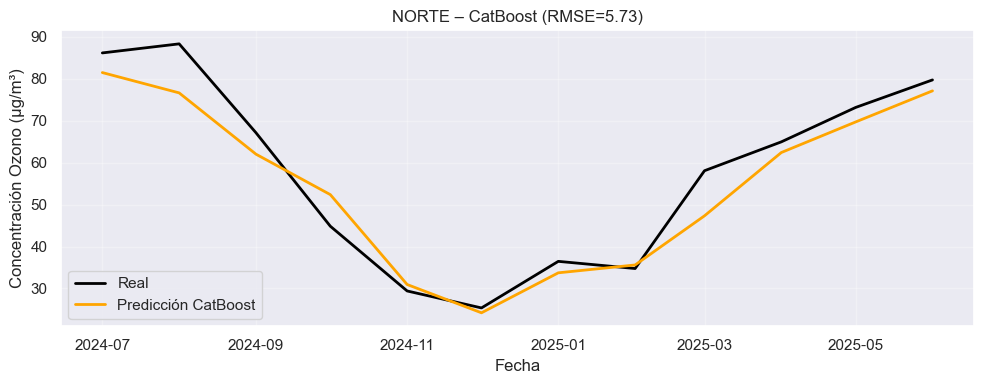

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\NORTE_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
NORTE - LightGBM → RMSE: 4.629


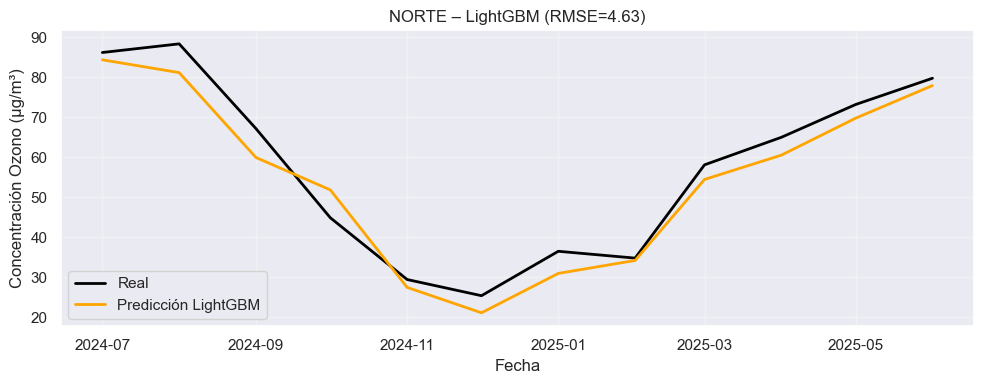

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\NORTE_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
NORTE - XGBoost → RMSE: 5.694


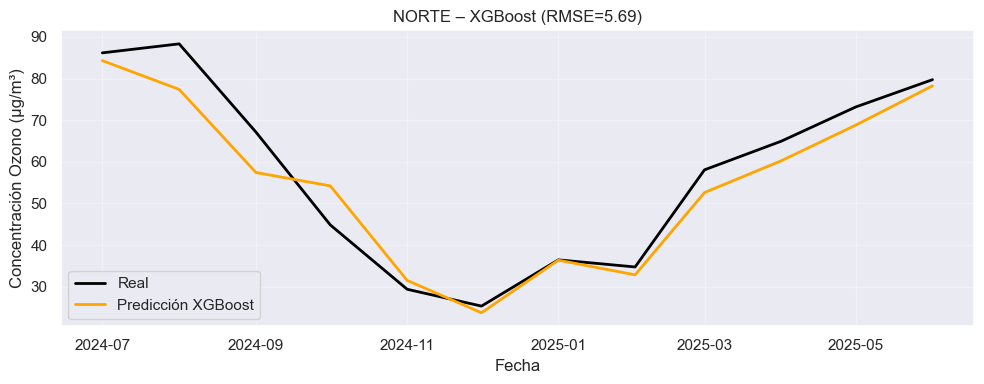

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\NORTE_XGBoost_predicciones_test.png

=== ZONA CENTRO ===
Entrenando modelo CatBoost ...
CENTRO - CatBoost → RMSE: 7.417


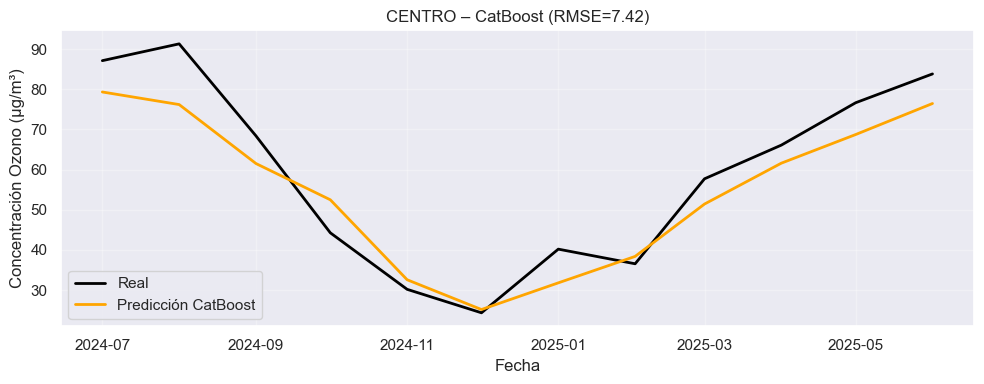

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\CENTRO_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
CENTRO - LightGBM → RMSE: 7.577


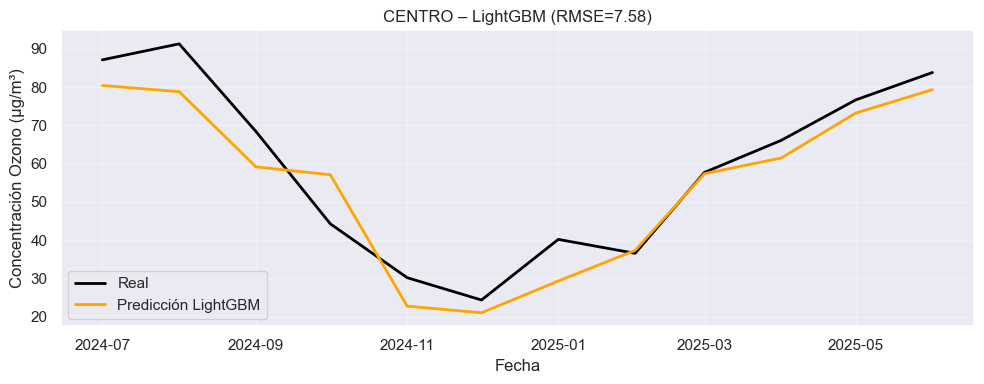

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\CENTRO_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
CENTRO - XGBoost → RMSE: 8.459


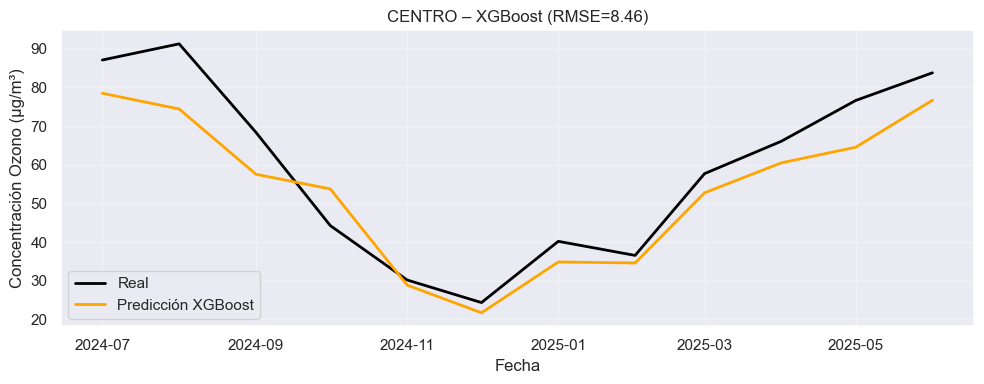

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\CENTRO_XGBoost_predicciones_test.png

=== ZONA SUR ===
Entrenando modelo CatBoost ...
SUR - CatBoost → RMSE: 6.230


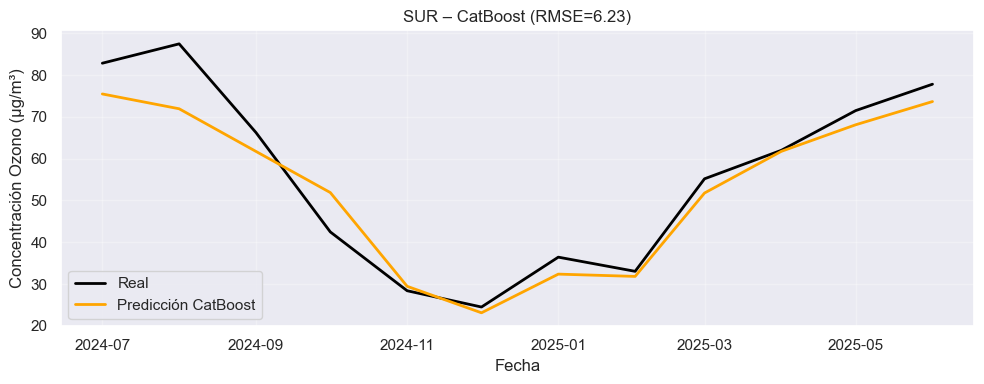

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\SUR_CatBoost_predicciones_test.png
Entrenando modelo LightGBM ...
SUR - LightGBM → RMSE: 5.576


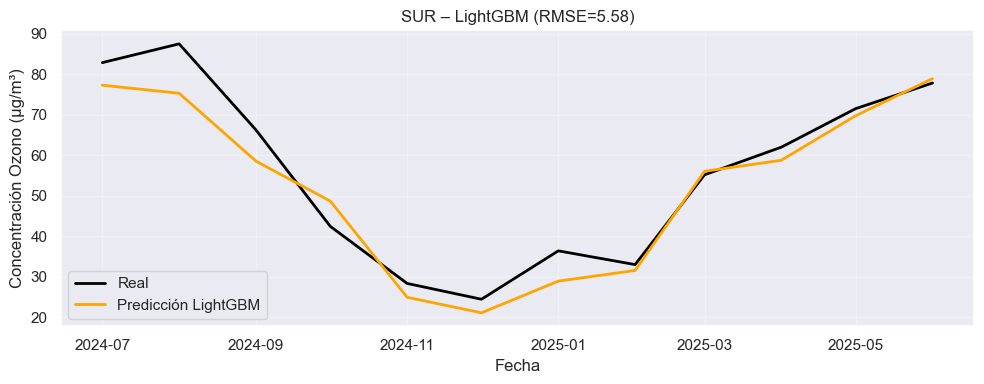

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\SUR_LightGBM_predicciones_test.png
Entrenando modelo XGBoost ...
SUR - XGBoost → RMSE: 6.718


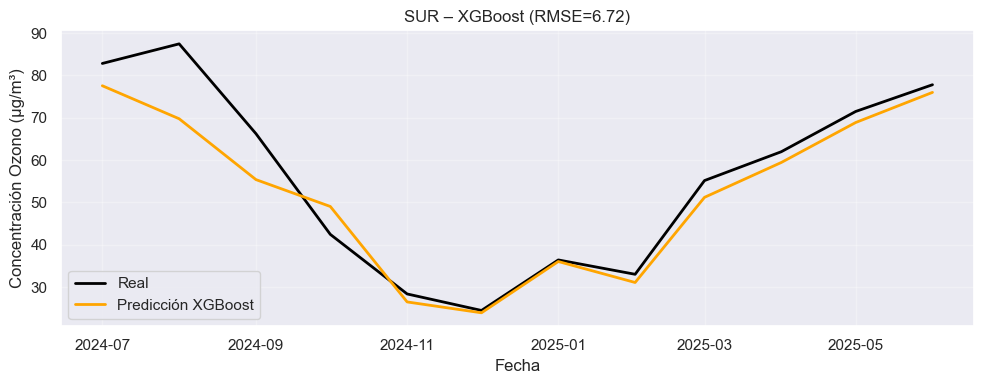

📁 Guardado gráfico: 07_Figs\07_predicciones_modelos_ML_MAG14\SUR_XGBoost_predicciones_test.png

>>> RESULTADOS COMPARATIVOS (RMSE test) <<<
  Zona   Modelo  RMSE_test  n_train  n_test
CENTRO CatBoost      7.417      162      12
CENTRO LightGBM      7.577      162      12
CENTRO  XGBoost      8.459      162      12
 NORTE LightGBM      4.629      162      12
 NORTE  XGBoost      5.694      162      12
 NORTE CatBoost      5.731      162      12
   SUR LightGBM      5.576      162      12
   SUR CatBoost      6.230      162      12
   SUR  XGBoost      6.718      162      12

📁 Guardado CSV resumen: 07_Figs\07_predicciones_modelos_ML_MAG14\RMSE_modelos_ML_comparativa.csv


In [63]:
# ------------------------------------------------------------
# Carpeta de salida
# ------------------------------------------------------------
CARPETA_BASE = "07_Figs"
SUBCARPETA = "07_predicciones_modelos_ML_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ------------------------------------------------------------
# Configuración de los modelos
# ------------------------------------------------------------
MODELOS = {
    "CatBoost": CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function="RMSE",
        verbose=False,          # ← SILENCIA CatBoost
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1              # ← SILENCIA LightGBM
    ),
    "XGBoost": XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        verbosity=0             # ← SILENCIA XGBoost
    )
}

# ------------------------------------------------------------
# Entrenar y evaluar para cada zona
# ------------------------------------------------------------

resultados_ml = []
predicciones_ml = {}

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} ===")
    
    X_train = Xtr_zona[zona]
    y_train = ytr_zona[zona]
    X_test  = Xte_zona[zona]
    y_test  = yte_zona[zona]

    predicciones_ml[zona] = {}

    for nombre, modelo in MODELOS.items():
        print(f"Entrenando modelo {nombre} ...")

        # Entrenamiento
        modelo.fit(X_train, y_train)

        # Predicción sobre test
        y_pred = modelo.predict(X_test)
        
        # Evaluación usando tu función
        rmse_val = evaluar_modelo(f"{zona} - {nombre}", y_test, y_pred)

        # Guardar resultados
        resultados_ml.append({
            "Zona": zona,
            "Modelo": nombre,
            "RMSE_test": round(rmse_val, 3),
            "n_train": len(X_train),
            "n_test": len(X_test)
        })

        # Guardar predicciones para análisis o gráfico posterior
        df_pred = pd.DataFrame({
            "real": y_test.values,
            "pred": y_pred
        }, index=y_test.index)
        predicciones_ml[zona][nombre] = df_pred

        # Gráfico comparativo
        plt.figure(figsize=(10,4))
        plt.plot(y_test.index, y_test, label="Real", color="black", linewidth=2)
        plt.plot(y_test.index, y_pred, label=f"Predicción {nombre}", color="orange", linewidth=2)
        plt.title(f"{zona} – {nombre} (RMSE={rmse_val:.2f})")
        plt.xlabel("Fecha")
        plt.ylabel("Concentración Ozono (µg/m³)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        ruta_fig = os.path.join(CARPETA_SALIDA, f"{zona}_{nombre}_predicciones_test.png")
        plt.savefig(ruta_fig, dpi=150)
        plt.show()
        plt.close()

        print(f"📁 Guardado gráfico: {ruta_fig}")

# ------------------------------------------------------------
# Crear tabla resumen
# ------------------------------------------------------------
df_resultados_ml = pd.DataFrame(resultados_ml)
df_resultados_ml = df_resultados_ml.sort_values(["Zona", "RMSE_test"]).reset_index(drop=True)

print("\n>>> RESULTADOS COMPARATIVOS (RMSE test) <<<")
print(df_resultados_ml.to_string(index=False))

# ------------------------------------------------------------
# Guardar CSV resumen
# ------------------------------------------------------------
csv_resultados = os.path.join(CARPETA_SALIDA, "RMSE_modelos_ML_comparativa.csv")
df_resultados_ml.to_csv(csv_resultados, index=False)
print(f"\n📁 Guardado CSV resumen: {csv_resultados}")

Guardamos los resultados de los RMSE en la tabla resumen:

In [64]:
# Renombramos columnas de df_resultados_ml para que encajen con df_rmse
df_resultados_ml = df_resultados_ml.rename(
    columns={"Zona": "zona", "Modelo": "modelo"}
)[["modelo", "zona", "RMSE_test"]]

#### 4) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030

##### 4.1. MEJOR MODELO POR ZONA

Guardamos modelos ya entrenados

In [65]:
modelos_entrenados = {  # zona -> {modelo_nombre -> objeto_modelo_entrenado}
    "NORTE": {},
    "CENTRO": {},
    "SUR": {}
}

for zona in ["NORTE", "CENTRO", "SUR"]:
    ...
    for nombre, modelo in MODELOS.items():
        ...
        modelo.fit(X_train, y_train)

        # Guardar el modelo entrenado
        modelos_entrenados[zona][nombre] = modelo

Se elije el mejor modelo en función del valor de los RMSE calculados

In [66]:
mejores_modelos_ml = (
    df_resultados_ml
    .sort_values(["zona", "RMSE_test"])
    .groupby("zona")
    .first()
    .reset_index()
)

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
print(mejores_modelos_ml.to_string(index=False))


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
  zona   modelo  RMSE_test
CENTRO CatBoost      7.417
 NORTE LightGBM      4.629
   SUR LightGBM      5.576


In [67]:
mejor_modelo_por_zona = {}
mejor_modelo_nombre = {}

for zona in df_resultados_ml["zona"].unique():
    fila_best = (
        df_resultados_ml[df_resultados_ml["zona"] == zona]
        .sort_values("RMSE_test")
        .iloc[0]
    )
    nombre_mejor = fila_best["modelo"]
    mejor_modelo_nombre[zona] = nombre_mejor
    mejor_modelo_por_zona[zona] = modelos_entrenados[zona][nombre_mejor]

print("\n>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<")
for zona in mejor_modelo_por_zona:
    modelo = mejor_modelo_nombre[zona]
    print(f"🟢 {zona:<8} → {modelo}")


>>> MEJOR MODELO POR ZONA (según RMSE_test) <<<
🟢 CENTRO   → CatBoost
🟢 NORTE    → LightGBM
🟢 SUR      → LightGBM


##### 4.2. FORECAST ITERATIVO HASTA 2032

Dado que no se dispone de proyecciones mensuales de variables meteorológicas hasta 2032, se optó por mantener el componente exógeno del modelo ML mediante la climatología media mensual histórica. Es decir, para cada variable exógena se calculó la media de todos los valores observados para cada mes (enero–diciembre) y se usó esa media como valores para las condiciones típicas del mes en el horizonte de predicción


=== FORECAST ML HASTA 2032 PARA NORTE ===


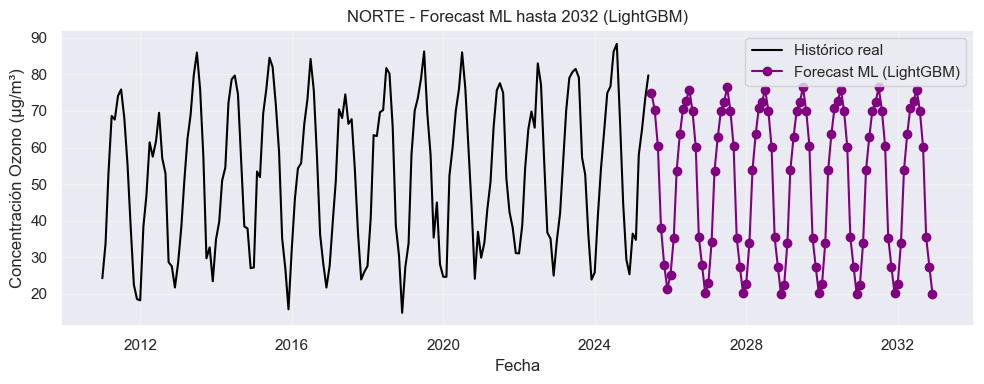

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG14\NORTE_forecast_ML_hasta_2032_LightGBM.png

=== FORECAST ML HASTA 2032 PARA CENTRO ===


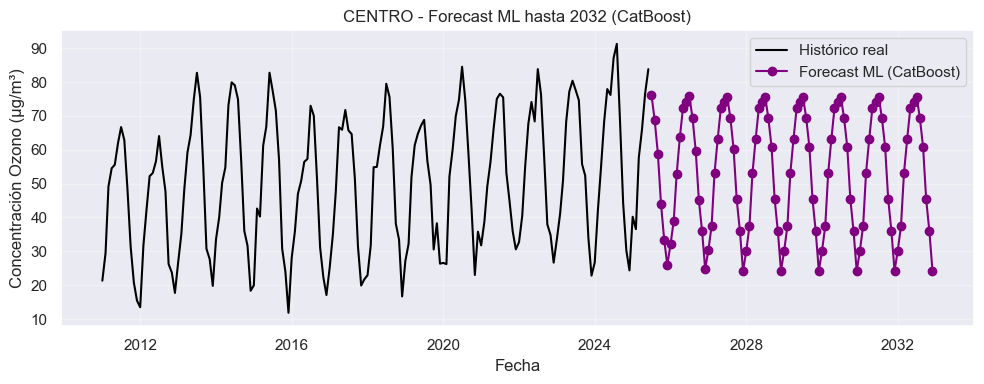

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG14\CENTRO_forecast_ML_hasta_2032_CatBoost.png

=== FORECAST ML HASTA 2032 PARA SUR ===


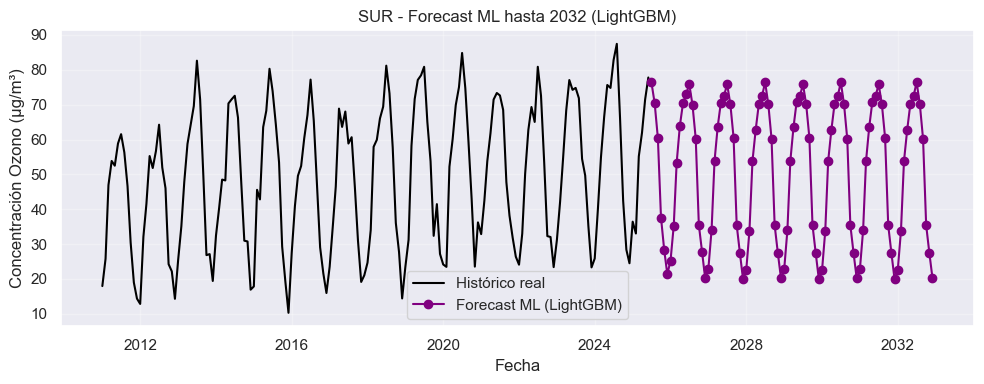

📁 Guardado gráfico forecast: 07_Figs\07_predicciones_modelos_ML_MAG14\SUR_forecast_ML_hasta_2032_LightGBM.png

>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<
  modelo   zona  promedio_anual_2030
LightGBM  NORTE               50.547
CatBoost CENTRO               53.493
LightGBM    SUR               50.422


In [68]:
# ============================================================
# FORECAST ML HASTA 2032 (USANDO MODELO GANADOR POR ZONA)
# Y PROMEDIOS ANUALES 2030
# ============================================================

# Lista de columnas exógenas que se usaron en el entrenamiento ML
columnas_exogenas_para_ML = [
    "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
        "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
     "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)" 
]

predicciones_futuras_ml = {}
promedios_2030_ml = []

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST ML HASTA 2032 PARA {zona} ===")

    # 1. Recuperar el mejor modelo ya entrenado para esta zona
    mejor_modelo = mejor_modelo_por_zona[zona]
    nombre_mejor_modelo = mejor_modelo_nombre[zona]

    # 2. Histórico ML de la zona (devuelto por preparar_datos_ml)
    #    Este df_ml_zona[zona] debe tener índice datetime mensual
    #    y columnas: target, mes, anio, t_index, lags, rollings, exógenas...
    df_hist = df_ml_zona[zona].copy().sort_index()

    # 3. Columnas de entrada exactas esperadas por el modelo
    #    (el orden tiene que ser idéntico al entrenamiento)
    feature_cols = Xtr_zona[zona].columns.tolist()

    # 4. Forecast iterativo hasta dic 2032 usando climatología mensual de exógenas
    df_forecast = forecast_autoregresivo_hasta_2032(
        df_ml_hist=df_hist,
        modelo_entrenado=mejor_modelo,
        feature_cols=feature_cols,
        fecha_fin_forecast="2032-12-31",
        lags=[1,2,3,12],
        usar_columnas_exogenas=columnas_exogenas_para_ML
    )

    # Guardamos predicción larga para esa zona
    predicciones_futuras_ml[zona] = {
        "modelo": nombre_mejor_modelo,
        "forecast": df_forecast
    }

    # 5. Calcular el promedio del año 2030 para esa zona
    df_2030 = df_forecast[df_forecast.index.year == 2030]
    promedio_2030 = df_2030["pred"].mean()

    promedios_2030_ml.append({
        "modelo": nombre_mejor_modelo,
        "zona": zona,
        "promedio_anual_2030": promedio_2030
    })

    # 6. Graficar histórico + predicción futura
    plt.figure(figsize=(10,4))
    plt.plot(df_hist.index, df_hist["target"], color="black", linewidth=1.5, label="Histórico real")
    plt.plot(df_forecast.index, df_forecast["pred"], color="purple", marker="o",
             linewidth=1.5, label=f"Forecast ML ({nombre_mejor_modelo})")

    plt.title(f"{zona} - Forecast ML hasta 2032 ({nombre_mejor_modelo})")
    plt.xlabel("Fecha")
    plt.ylabel("Concentración Ozono (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    ruta_fig_forecast = os.path.join(
        CARPETA_SALIDA,
        f"{zona}_forecast_ML_hasta_2032_{nombre_mejor_modelo}.png"
    )
    plt.savefig(ruta_fig_forecast, dpi=150)
    plt.show()
    plt.close()

    print(f"📁 Guardado gráfico forecast: {ruta_fig_forecast}")

# ------------------------------------------------------------
# Convertimos la lista de promedios a DataFrame limpio
# ------------------------------------------------------------
df_promedios_2030_ml = pd.DataFrame(promedios_2030_ml)
df_promedios_2030_ml["promedio_anual_2030"] = df_promedios_2030_ml["promedio_anual_2030"].round(3)

print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (MODELOS ML) <<<")
print(df_promedios_2030_ml.to_string(index=False))


### MODELOS DEEP LEARNING (LSTM y CNN)

Ahora vamos a entrenar dos arquitecturas por zona con modelos depp learning:

- LSTM (red recurrente que captura dependencias temporales largas)
- CNN1D causal (convoluciones sobre la serie temporal que detectan patrones locales/estacionales)
  * 1D = Unidimensional: los datos tienen una sola dimensión relevante para el modelo. En series temporales, esta dimensión es el tiempo.

1. Vamos a usar las mismas variables tabulares que ya tenemos de los modelos ML (lags, rolling, mes, exógenas climatológicas…), pero ahora tenemos que transformarlas en secuencias.
2. Evaluamos en el mismo conjunto test temporal (corte 2024-06-30).
3. Metemos sus RMSE en la tabla de comparación.
4. Preparamos (después) el forecast autoregresivo hasta 2032 con el mejor modelo por zona igual que hicimos con ML.
5. Metemos la predicción de 2030 en la tabls de comparación.

####  1) PREPARAR DATOS SECUENCIALES 

In [69]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "08_deep_learning_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

columnas_input_dl = [
    "target",
    "mes", "t_index",
    "roll3_mean", "roll6_mean", "roll12_mean",
    "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
    "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)"
]

####  2) ENTRENAR LSTM Y CNN1D PARA CADA ZONA

Tras una primera ejecución del modelo, observo un claro sobreajuste, por lo qur trato de mitigarlo:

**2.1. Añado EaarlyStopping:** Permite que el modelo se pare cuando deja de mejorar en validación.

**2.2. Añado Dropout en la LSTM:** El Dropout apaga aleatoriamente neuronas durante el entrenamiento para obligar al modelo a generalizar.

**2.3. Simplifico la CNN1D:** Le quito filtros a las distintas capas


=== ZONA NORTE (Deep Learning) ===
DL | corte 2024-06-30 | train=150 | test=12 | feats=16
   LSTM -> RMSE scaled=0.564 | RMSE real=11.250
   CNN1D -> RMSE scaled=0.983 | RMSE real=19.591


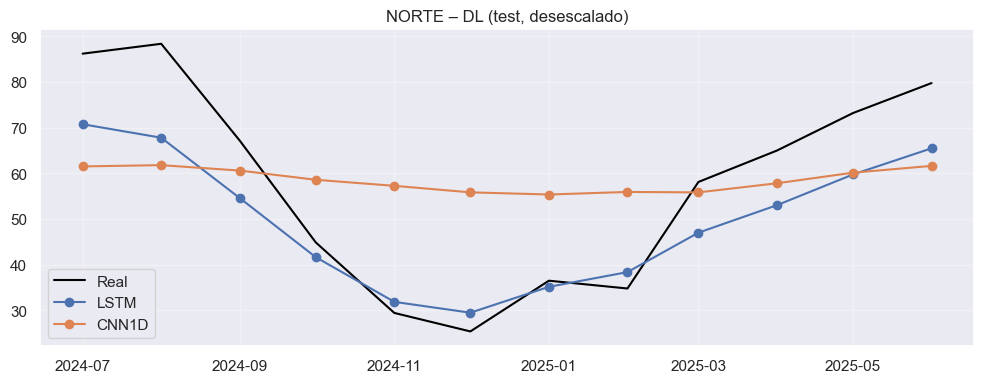


=== ZONA CENTRO (Deep Learning) ===
DL | corte 2024-06-30 | train=150 | test=12 | feats=16
   LSTM -> RMSE scaled=0.525 | RMSE real=10.365
   CNN1D -> RMSE scaled=0.331 | RMSE real=6.548


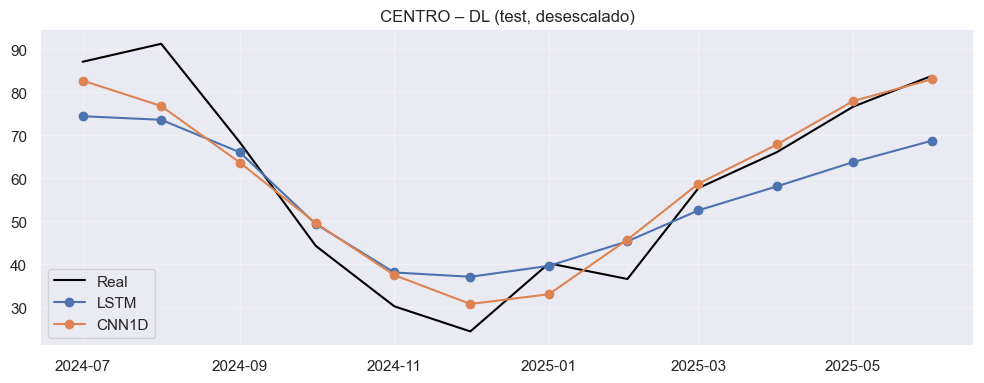


=== ZONA SUR (Deep Learning) ===
DL | corte 2024-06-30 | train=150 | test=12 | feats=16
   LSTM -> RMSE scaled=0.960 | RMSE real=19.091
   CNN1D -> RMSE scaled=1.010 | RMSE real=20.094


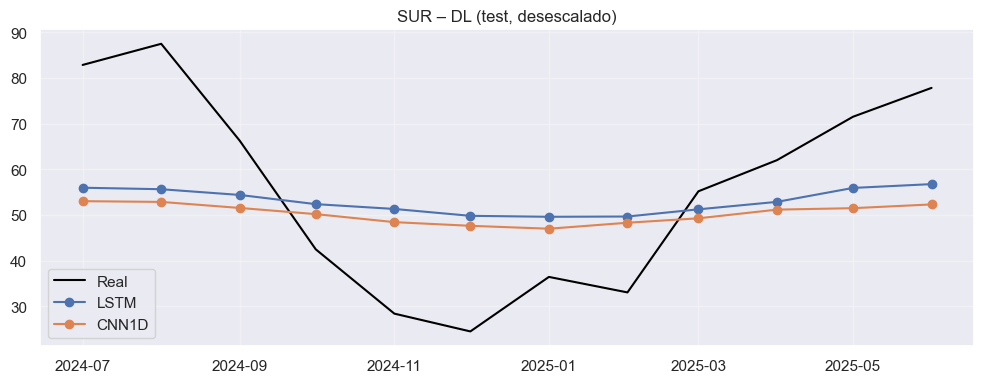


>>> RESULTADOS DL (escalado y real) <<<
  zona modelo  RMSE_test_scaled  RMSE_test_real
 NORTE   LSTM          0.564468       11.249716
 NORTE  CNN1D          0.983017       19.591297
CENTRO   LSTM          0.524565       10.364691
CENTRO  CNN1D          0.331401        6.548022
   SUR   LSTM          0.960027       19.091095
   SUR  CNN1D          1.010438       20.093573


In [70]:
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    # si no existe en tu versión, lo ignoramos
    pass

# diccionario donde guardamos los modelos
modelos_dl_entrenados = {"NORTE": {}, "CENTRO": {}, "SUR": {}}
resultados_dl = []

callback_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== ZONA {zona} (Deep Learning) ===")

    # tu dataframe mensual por zona:
    df_z = df_ml_zona[zona].copy().sort_index()

    (
        X_train, y_train,
        X_test, y_test,
        fechas_test,
        scaler_z,
        cols_efectivas,
        cols_scaled
    ) = construir_secuencias_escaladas(
        df_z,
        columnas_input=columnas_input_dl,
        columna_objetivo="target",
        window_size=12,
        fecha_corte="2024-06-30"
    )

    n_steps = X_train.shape[1]
    n_feats = X_train.shape[2]

    # split interno para validación cronológica
    n_train = X_train.shape[0]
    n_val = int(n_train * 0.15)
    X_sub, y_sub = X_train[:-n_val], y_train[:-n_val]
    X_val, y_val = X_train[-n_val:], y_train[-n_val:]

    # ---------------- LSTM ----------------
    lstm_model = build_lstm_model(n_steps, n_feats)
    lstm_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_lstm = lstm_model.predict(X_test, verbose=0).flatten()

    # RMSE escalado
    rmse_lstm_scaled = np.sqrt(np.mean((y_pred_lstm - y_test) ** 2))

    # desescalar reales y pred
    y_test_real = desescalar_target(scaler_z, cols_scaled, y_test)
    y_pred_lstm_real = desescalar_target(scaler_z, cols_scaled, y_pred_lstm)

    # RMSE real
    rmse_lstm_real = np.sqrt(np.mean((y_pred_lstm_real - y_test_real) ** 2))

    print(f"   LSTM -> RMSE scaled={rmse_lstm_scaled:.3f} | RMSE real={rmse_lstm_real:.3f}")

    # guardamos el modelo
    modelos_dl_entrenados[zona]["LSTM"] = {
        "model": lstm_model,
        "scaler": scaler_z,
        "cols_input": cols_efectivas,
        "cols_scaled": cols_scaled,
        "window_size": 12
    }

    # guardamos resultados
    resultados_dl.append({
        "zona": zona,
        "modelo": "LSTM",
        "RMSE_test_scaled": float(rmse_lstm_scaled),
        "RMSE_test_real": float(rmse_lstm_real)
    })

    # ---------------- CNN1D ----------------
    cnn_model = build_cnn1d_model(n_steps, n_feats)
    cnn_model.fit(
        X_sub, y_sub,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=8,
        verbose=0,
        callbacks=[callback_es]
    )

    y_pred_cnn = cnn_model.predict(X_test, verbose=0).flatten()

    # RMSE escalado
    rmse_cnn_scaled = np.sqrt(np.mean((y_pred_cnn - y_test) ** 2))

    # desescalar
    y_pred_cnn_real = desescalar_target(scaler_z, cols_scaled, y_pred_cnn)
    rmse_cnn_real = np.sqrt(np.mean((y_pred_cnn_real - y_test_real) ** 2))

    print(f"   CNN1D -> RMSE scaled={rmse_cnn_scaled:.3f} | RMSE real={rmse_cnn_real:.3f}")

    modelos_dl_entrenados[zona]["CNN1D"] = {
        "model": cnn_model,
        "scaler": scaler_z,
        "cols_input": cols_efectivas,
        "cols_scaled": cols_scaled,
        "window_size": 12
    }

    resultados_dl.append({
        "zona": zona,
        "modelo": "CNN1D",
        "RMSE_test_scaled": float(rmse_cnn_scaled),
        "RMSE_test_real": float(rmse_cnn_real)
    })

    # ---------- gráfico de test desescalado ----------
    plt.figure(figsize=(10,4))
    plt.plot(fechas_test, y_test_real, color="black", label="Real")
    plt.plot(fechas_test, y_pred_lstm_real, marker="o", label="LSTM")
    plt.plot(fechas_test, y_pred_cnn_real, marker="o", label="CNN1D")
    plt.title(f"{zona} – DL (test, desescalado)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CARPETA_SALIDA, f"{zona}_DL_test_desescalado.png"), dpi=150)
    plt.show()
    plt.close()

# ============================================================
# 5. TABLA FINAL DE RMSE
# ============================================================
df_resultados_dl = pd.DataFrame(resultados_dl)
print("\n>>> RESULTADOS DL (escalado y real) <<<")
print(df_resultados_dl.to_string(index=False))

# si quieres lo guardas
df_resultados_dl.to_csv(
    os.path.join(CARPETA_SALIDA, "resultados_dl_rmse.csv"),
    index=False
)

In [71]:
df_resultados_dl_std = df_resultados_dl.rename(
    columns={"modelo": "modelo", "zona": "zona", "RMSE_test_scaled": "RMSE_test_scaled", "RMSE_test_real": "RMSE_test"}
)[["modelo", "zona", "RMSE_test"]]

####  3) PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030


=== FORECAST DL – NORTE ===


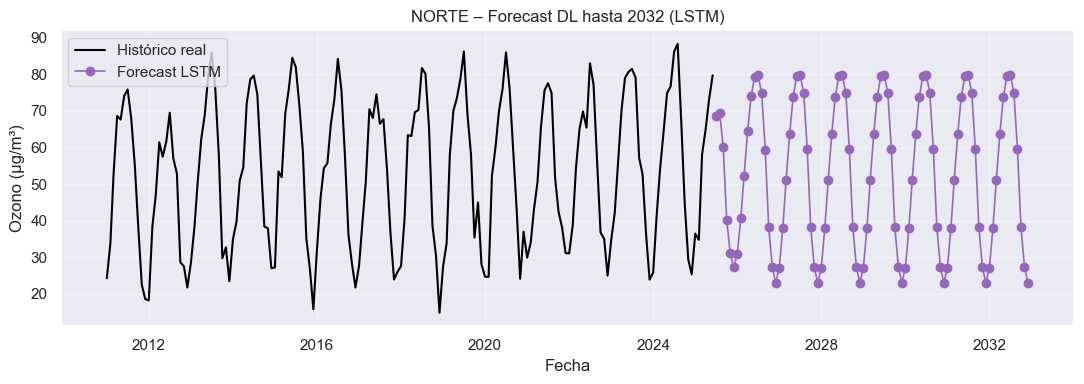

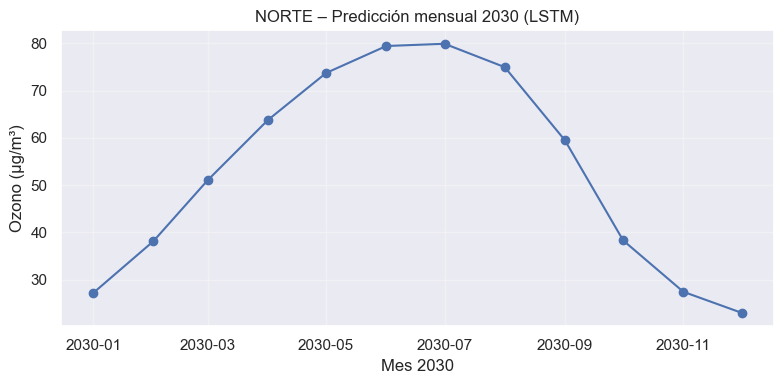


=== FORECAST DL – CENTRO ===


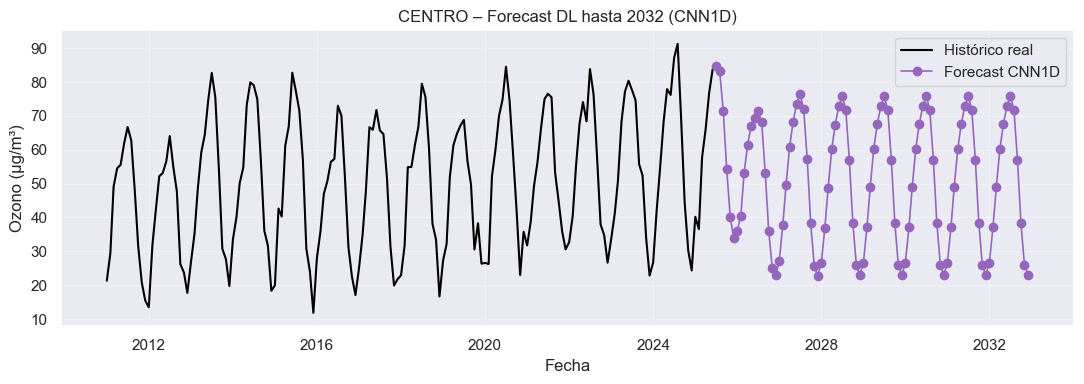

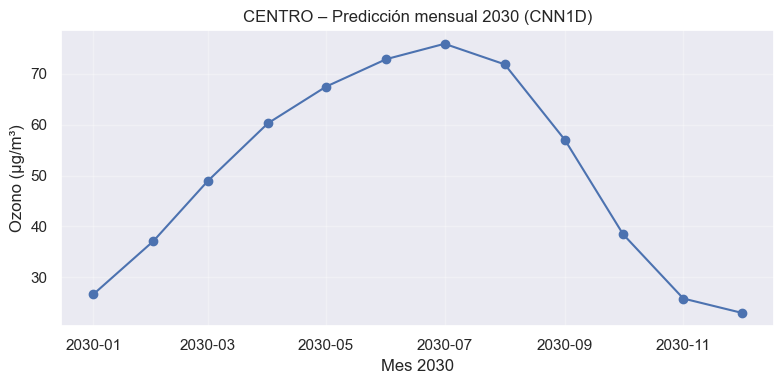


=== FORECAST DL – SUR ===


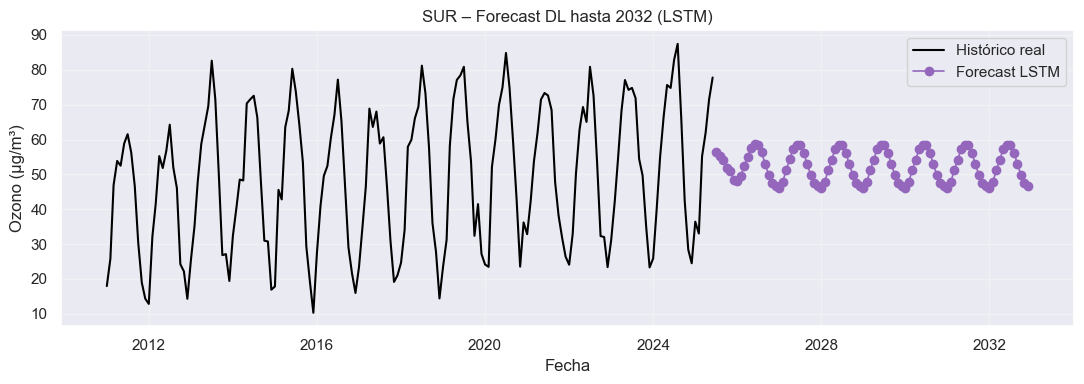

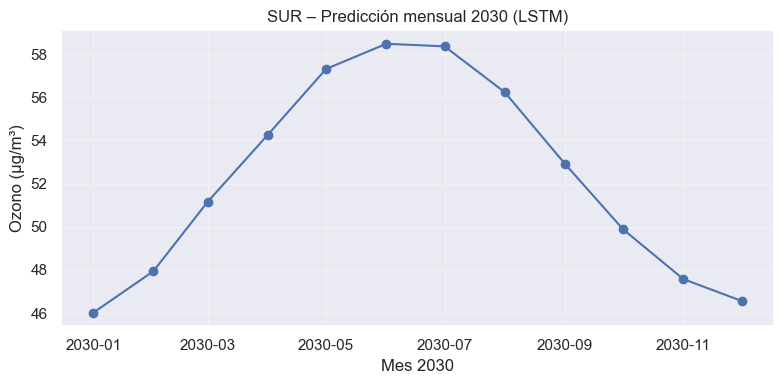


>>> PROMEDIOS ANUALES PREVISTOS 2030 (DL) <<<
  zona modelo  promedio_anual_2030
 NORTE   LSTM               53.027
CENTRO  CNN1D               50.443
   SUR   LSTM               52.226

CSV de predicciones 2030 guardado ✅


In [72]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ============================================================
# PREDICCIONES / FORECAST POR ZONA
# ============================================================
forecast_hasta_2032 = {}
promedios_2030 = []

for zona in ["NORTE", "CENTRO", "SUR"]:
    print(f"\n=== FORECAST DL – {zona} ===")

    # 1) elegir el mejor modelo de esa zona (el de menor RMSE real)
    df_res_z = df_resultados_dl[df_resultados_dl["zona"] == zona].sort_values("RMSE_test_real")
    mejor_modelo = df_res_z.iloc[0]["modelo"]   # "LSTM" o "CNN1D"
    paquete = modelos_dl_entrenados[zona][mejor_modelo]

    # 2) histórico original de esa zona
    df_hist_z = df_ml_zona[zona].copy().sort_index()

    # 3) forecast hasta 2032
    df_fore = forecast_dl_escalado(
        df_hist=df_hist_z,
        paquete=paquete,
        fecha_fin="2032-12-01"
    )

    forecast_hasta_2032[zona] = df_fore

    # 4) gráfica completa
    plt.figure(figsize=(11,4))
    plt.plot(df_hist_z.index, df_hist_z["target"], color="black", label="Histórico real", linewidth=1.5)
    plt.plot(df_fore.index, df_fore["pred"], color="tab:purple", marker="o",
             label=f"Forecast {mejor_modelo}", linewidth=1.2)
    plt.title(f"{zona} – Forecast DL hasta 2032 ({mejor_modelo})")
    plt.xlabel("Fecha")
    plt.ylabel("Ozono (µg/m³)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(CARPETA_SALIDA, f"{zona}_forecast_DL_hasta_2032.png"), dpi=150)
    plt.show()
    plt.close()

    # 5) gráfica 2030
    df_2030 = df_fore[df_fore.index.year == 2030]
    plt.figure(figsize=(8,4))
    plt.plot(df_2030.index, df_2030["pred"], marker="o")
    plt.title(f"{zona} – Predicción mensual 2030 ({mejor_modelo})")
    plt.xlabel("Mes 2030")
    plt.ylabel("Ozono (µg/m³)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(CARPETA_SALIDA, f"{zona}_forecast_DL_2030.png"), dpi=150)
    plt.show()
    plt.close()

    # 6) promedio anual 2030
    media_2030 = df_2030["pred"].mean() if not df_2030.empty else np.nan
    promedios_2030.append({
        "zona": zona,
        "modelo": mejor_modelo,
        "promedio_anual_2030": round(float(media_2030), 3) if media_2030 == media_2030 else np.nan
    })

# 7) tabla final
df_promedios_2030_dl = pd.DataFrame(promedios_2030)
print("\n>>> PROMEDIOS ANUALES PREVISTOS 2030 (DL) <<<")
print(df_promedios_2030_dl.to_string(index=False))

df_promedios_2030_dl.to_csv(
    os.path.join(CARPETA_SALIDA, "forecast_DL_promedio_2030_por_zona.csv"),
    index=False
)
print("\nCSV de predicciones 2030 guardado ✅")


### CUADRO COMPARATIVA MODELOS I

In [73]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)
df_pred_2030 = pd.DataFrame(tabla_predicciones_2030)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning
df_rmse = pd.concat([df_rmse, df_resultados_ml], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_dl_std],
    ignore_index=True
)

# Unir predicción 2030 de ARIMA/SARIMA + ML + deep learning
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_ml], ignore_index=True)
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_dl], ignore_index=True)

# ==========================================================
# 2️⃣ Agrupar predicciones 2030 (modelo + zona)
# ==========================================================
df_pred_2030_resumen = (
    df_pred_2030
    .drop(columns=["pred_2030"], errors="ignore")       # eliminar columna de predicción individual
    .groupby(["modelo", "zona"], as_index=False)        # agrupar por modelo y zona
    .agg({"promedio_anual_2030": "mean"})               # mantener promedio
    .sort_values(by=["zona", "promedio_anual_2030"], ascending=[True, True])
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC","n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Filtrar solo los modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Filtrar predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
  modelo   zona  RMSE_test
   CNN1D CENTRO      6.548
  SARIMA CENTRO      6.784
CatBoost CENTRO      7.417
LightGBM CENTRO      7.577
 XGBoost CENTRO      8.459
    LSTM CENTRO     10.365
   ARIMA CENTRO     20.669
LightGBM  NORTE      4.629
  SARIMA  NORTE      5.641
 XGBoost  NORTE      5.694
CatBoost  NORTE      5.731
    LSTM  NORTE     11.250
   ARIMA  NORTE     19.028
   CNN1D  NORTE     19.591
LightGBM    SUR      5.576
CatBoost    SUR      6.230
  SARIMA    SUR      6.454
 XGBoost    SUR      6.718
   ARIMA    SUR     18.894
    LSTM    SUR     19.091
   CNN1D    SUR     20.094

>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<
  modelo   zona  promedio_anual_2030
   ARIMA CENTRO               50.202
   CNN1D CENTRO               50.443
CatBoost CENTRO               53.493
  SARIMA CENTRO               58.135
LightGBM  NORTE               50.547
   ARIMA  NORTE               52.941
    LSTM  NORTE               53.027
  SARI

### PREDICCIÓN CONSIDERANDO EL TRÁFICO

#### PREPARACIÓN DATOS - INCLUYENDO TRÁFICO

Ahora vamos a ejecutar los siguientes modelos, pero incluyendo la variable relativa al tráfico ("TOTAL_HOR_EXT"). Dado que esta variable no contiene valores coherentes antes de 2019, friltramos el dataframe, de modo que me quede con:

- Valores posteriores a 2019.
- Instancias con MAGNITUD = 14 (Ozono)
- Las variables interesantes de antes + "TOTAL_HOR_EXT"
- Sobre este dataframe aplicaré los modelos:
  * CatBoost para las 3 zonas.
  * CNN1D para la zona CENTRO.
  * LightGBM para la zona SUR y NORTE.

In [74]:
df_traf = pd.read_parquet("05_DATASET_FINAL.parquet")

In [75]:
df_traf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186780 entries, 0 to 186779
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   DIA/MES/ANO               186780 non-null  datetime64[ns]
 1   MAGNITUD                  186780 non-null  category      
 2   ZONA_ESTACION             186780 non-null  category      
 3   MEDICION_ugm3             186780 non-null  float64       
 4   TEMPERATURA_MAX (°C)      186780 non-null  float64       
 5   TEMPERATURA_MIN (°C)      186780 non-null  float64       
 6   TEMPERATURA_MED (°C)      186780 non-null  float64       
 7   PRECIPITACIONES (mm)      186780 non-null  float64       
 8   HUMEDAD_MAX (%)           186780 non-null  float64       
 9   HUMEDAD_MIN (%)           186780 non-null  float64       
 10  HUMEDAD_MED (%)           186780 non-null  float64       
 11  NIEVE (cm)                186780 non-null  float64       
 12  VI

In [76]:
df_traf.head()

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  TEMPERATURA_MAX (°C)  \
0  2010-01-01        1        CENTRO       8.666667              8.833577   
1  2010-01-01        9           SUR       8.000000              8.833577   
2  2010-01-01        9         NORTE       8.000000              8.833577   
3  2010-01-01        9        CENTRO       6.000000              8.833577   
4  2010-01-01        8           SUR      21.666667              8.833577   

   TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  PRECIPITACIONES (mm)  \
0              4.033577              5.879828                   0.1   
1              4.033577              5.879828                   0.1   
2              4.033577              5.879828                   0.1   
3              4.033577              5.879828                   0.1   
4              4.033577              5.879828                   0.1   

   HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  NUBES (%)  HORAS_SOL (min)  \
0         81.77903        63.816715  ...  55.933334        227.16466   
1         81.77903        63.816715  ...  55.933334        227.16466   
2         81.77903        63.816715  ...  55.933334        227.16466   
3         81.77903        63.816715  ...  55.933334        227.16466   
4         81.77903        63.816715  ...  55.933334        227.16466   

   RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  PRESION_MIN (hPa)  \
0                   1329.0             1017.5             1007.3   
1                   1329.0             1017.5             1007.3   
2                   1329.0             1017.5             1007.3   
3                   1329.0             1017.5             1007.3   
4                   1329.0             1017.5             1007.3   

   PRESION_MED (hPa)   TOTAL_HOR_EXT  Superficie_incendiada_HA  dow  month  
0         1011.06665       2196158.0                       0.0    4      1  
1         1011.06665  2012742.333333                       0.0    4      1  
2         1011.06665       1489878.0                       0.0    4      1  
3         1011.06665       2196158.0                       0.0    4      1  
4         1011.06665  2012742.333333                       0.0    4      1  

[5 rows x 30 columns]

In [77]:
# 1) Fecha a datetime una sola vez
df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce")
if df_traf["DIA/MES/ANO"].isna().any():
    df_traf["DIA/MES/ANO"] = pd.to_datetime(df_traf["DIA/MES/ANO"], errors="coerce", dayfirst=True)

# 2) Crear columna year
df_traf["year"] = df_traf["DIA/MES/ANO"].dt.year

# 3) Filtrar MAGNITUD = 14 y year >= 2019
df_traf_2019_Ozono = df_traf[(df_traf["MAGNITUD"] == "14") & (df_traf["year"] >= 2020)].copy()

# 4) Diccionario por zona (no sobrescribas el DataFrame)
dfs_traf_2019_Ozono = {
    zona: sub_df.copy()
    for zona, sub_df in df_traf_2019_Ozono.groupby("ZONA_ESTACION")
}

# Chequeo rápido
print(len(df_traf_2019_Ozono), "filas desde 2019 (Ozono).")
print("Zonas:", list(dfs_traf_2019_Ozono.keys()))



6024 filas desde 2019 (Ozono).
Zonas: ['CENTRO', 'NORTE', 'SUR']


C:\Users\rosal\AppData\Local\Temp\ipykernel_59132\1762311342.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for zona, sub_df in df_traf_2019_Ozono.groupby("ZONA_ESTACION")


In [78]:
df_ejemplo = dfs_traf_2019_Ozono["NORTE"]
df_ejemplo.tail(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  \
186643  2025-06-26       14         NORTE          99.50   
186676  2025-06-27       14         NORTE          98.00   
186707  2025-06-28       14         NORTE         103.75   
186742  2025-06-29       14         NORTE          91.50   
186774  2025-06-30       14         NORTE          98.25   

        TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  \
186643             32.203580             14.313578             24.527327   
186676             35.553577             18.293577             27.409828   
186707             37.423576             19.893578             28.952332   
186742             37.433580             22.563578             30.162743   
186774             31.605661             17.139827             24.912848   

        PRECIPITACIONES (mm)  HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  \
186643                0.0000        74.444820        19.840967  ...   
186676                0.0000        55.928905        13.678853  ...   
186707                0.0000        49.371860        16.764837  ...   
186742                0.4000        47.426750        16.073263  ...   
186774                0.2125        60.474367        21.010745  ...   

        HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
186643       906.466600              8618.000000            1020.60   
186676       906.133300              8633.000000            1023.80   
186707       862.887200              8412.000000            1023.90   
186742       779.573800              8031.000000            1021.80   
186774       776.895268              7737.541667            1017.15   

        PRESION_MIN (hPa)  PRESION_MED (hPa)  TOTAL_HOR_EXT  \
186643        1017.900000        1019.150100  123497.666667   
186676        1019.600000        1021.629100       120343.0   
186707        1018.900000        1021.533450   84772.333333   
186742        1016.200000        1019.429140   71413.333333   
186774        1012.433333        1014.920519       110268.0   

        Superficie_incendiada_HA  dow  month  year  
186643                  4.761060    3      6  2025  
186676                  7.174435    4      6  2025  
186707                  6.396657    5      6  2025  
186742                  7.155476    6      6  2025  
186774                  6.358453    0      6  2025  

[5 rows x 31 columns]

In [79]:
df_ejemplo = dfs_traf_2019_Ozono["CENTRO"]
df_ejemplo.head(5)

DIA/MES/ANO MAGNITUD ZONA_ESTACION  MEDICION_ugm3  \
120543  2020-01-01       14        CENTRO       6.666667   
120575  2020-01-02       14        CENTRO       6.000000   
120608  2020-01-03       14        CENTRO       3.333333   
120641  2020-01-04       14        CENTRO      23.333333   
120675  2020-01-05       14        CENTRO      14.833333   

        TEMPERATURA_MAX (°C)  TEMPERATURA_MIN (°C)  TEMPERATURA_MED (°C)  \
120543             11.613577             -1.186423              4.133577   
120575             10.723577              0.743577              4.283161   
120608              7.423577              0.393577              3.257327   
120641             10.983578             -0.016423              4.016911   
120675             12.183578             -2.256423              3.998994   

        PRECIPITACIONES (mm)  HUMEDAD_MAX (%)  HUMEDAD_MIN (%)  ...  \
120543                   0.0        87.910460        51.118310  ...   
120575                   0.0        86.438690        55.720420  ...   
120608                   0.0        90.807556        72.543045  ...   
120641                   0.0        92.081680        52.759460  ...   
120675                   0.0        92.539220        41.269253  ...   

        HORAS_SOL (min)  RADIACION_SOLAR (W/mÂ²)  PRESION_MAX (hPa)  \
120543        528.21783                   2634.0             1034.5   
120575        537.04260                   2586.0             1033.8   
120608        465.16974                   2203.0             1036.3   
120641        403.38214                   2405.0             1036.6   
120675        564.79880                   2644.0             1033.1   

        PRESION_MIN (hPa)  PRESION_MED (hPa)  TOTAL_HOR_EXT  \
120543             1030.6          1032.2291  126808.333333   
120575             1030.3          1031.8124  217519.333333   
120608             1032.1          1033.7333  208933.333333   
120641             1032.0          1034.2291  168484.333333   
120675             1026.8          1030.2916  132609.333333   

        Superficie_incendiada_HA  dow  month  year  
120543                       0.0    2      1  2020  
120575                       0.0    3      1  2020  
120608                       0.0    4      1  2020  
120641                       0.0    5      1  2020  
120675                       0.0    6      1  2020  

[5 rows x 31 columns]

In [80]:
# para CatBoost / LightGBM
variables_interes = [
    "ZONA_ESTACION", "dow", "month",
    "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
    "RADIACION_SOLAR (W/mÂ²)",
    "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)",
    "TOTAL_HOR_EXT"
]

# para la CNN1D
columnas_input_dl = [
    "target",
    "month", "t_index",
    "roll3_mean", "roll6_mean", "roll12_mean",
    "TEMPERATURA_MAX (°C)",  "TEMPERATURA_MIN (°C)", "TEMPERATURA_MED (°C)",
    "PRESION_MED (hPa)", "VIENTO_MAX_100 (km/h)", "VIENTO_DIR_10 (°)",
    "RADIACION_SOLAR (W/mÂ²)", "HUMEDAD_MAX (%)","HUMEDAD_MIN (%)","HUMEDAD_MED (%)",
    "TOTAL_HOR_EXT"
]

TARGET_COL = "MEDICION_ugm3"


#### ENTRENAMIENTO MODELOS - INCLUYENDO TRÁFICO

In [81]:
# ==========================================================
# 0️⃣  Ejecutar los modelos de tráfico
# ==========================================================
salida = preparar_y_modelar_por_zona(
    dfs_por_zona=dfs_traf_2019_Ozono,
    variables_interes=variables_interes,
    fecha_corte="2024-06-30",
    lags=[1, 2, 3, 12],
    fecha_fin_pred="2032-12-01"
)

# ==========================================================
# 0.1️⃣  Pasar 'salida' → filas con sufijo _TRAF
# ==========================================================
filas_traf = []

for zona, info in salida.items():
    # CatBoost (todas las zonas)
    filas_traf.append({
        "modelo": "CatBoost_TRAF",
        "zona": zona,
        "RMSE_test": round(info["rmse_catboost"], 3),
    })

    # LightGBM (solo si existe)
    if info.get("rmse_lightgbm") is not None:
        filas_traf.append({
            "modelo": "LightGBM_TRAF",
            "zona": zona,
            "RMSE_test": round(info["rmse_lightgbm"], 3),
        })

    # CNN1D (solo CENTRO y si tiene RMSE)
    if info.get("rmse_cnn1d") is not None:
        filas_traf.append({
            "modelo": "CNN1D_TRAF",
            "zona": zona,
            "RMSE_test": round(info["rmse_cnn1d"], 3),
        })

# este es el DF de los modelos nuevos
df_resultados_traf_tab = pd.DataFrame(filas_traf)



📊 Resumen modelos por zona
CENTRO: train=42, test=12, RMSE Cat=8.910, RMSE CNN1D=5.174
NORTE: train=42, test=12, RMSE Cat=7.240, RMSE LGB=8.568
SUR: train=42, test=12, RMSE Cat=7.375, RMSE LGB=7.239


#### PREDICCIÓN HASTA 2032. EVALUACIÓN PREDICCIÓN 2030 - INCLUYENDO TRÁFICO

In [82]:
CARPETA_BASE = "07_Figs"
SUBCARPETA = "09_predicciones_tráfico_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

In [83]:
# ==========================================================
# 🔢 3️⃣ Obtener dataframes por zona y modelo
# ==========================================================
df_fut_centro = obtener_pred_future(salida, "CENTRO", modelo="cnn")
df_hist_centro = obtener_hist_mensual(salida, "CENTRO")

df_fut_norte = obtener_pred_future(salida, "NORTE", modelo="lgb")
df_hist_norte = obtener_hist_mensual(salida, "NORTE")

df_fut_sur = obtener_pred_future(salida, "SUR", modelo="lgb")
df_hist_sur = obtener_hist_mensual(salida, "SUR")


In [84]:
plot_prediccion("CENTRO", "CNN1D", df_hist_centro, df_fut_centro)
plot_prediccion("NORTE", "LightGBM", df_hist_norte, df_fut_norte)
plot_prediccion("SUR", "LightGBM", df_hist_sur, df_fut_sur)

✅ Figura guardada: 07_Figs\09_predicciones_tráfico_MAG14\CENTRO_CNN1D_hasta_2032.png
✅ Figura guardada: 07_Figs\09_predicciones_tráfico_MAG14\NORTE_LightGBM_hasta_2032.png
✅ Figura guardada: 07_Figs\09_predicciones_tráfico_MAG14\SUR_LightGBM_hasta_2032.png


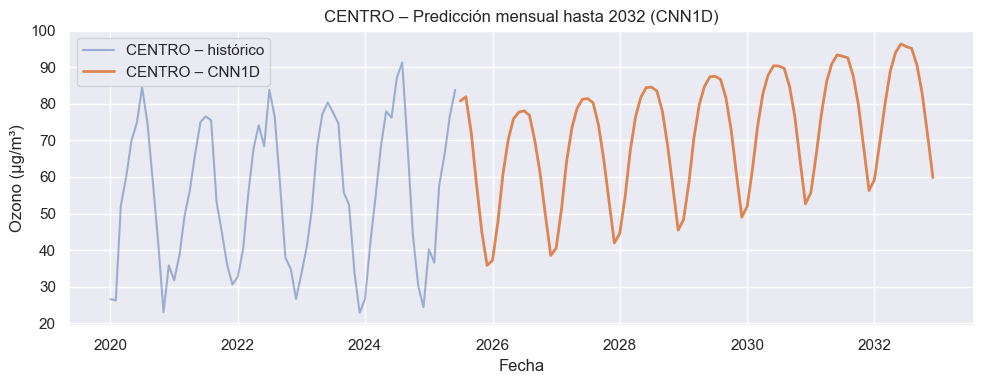

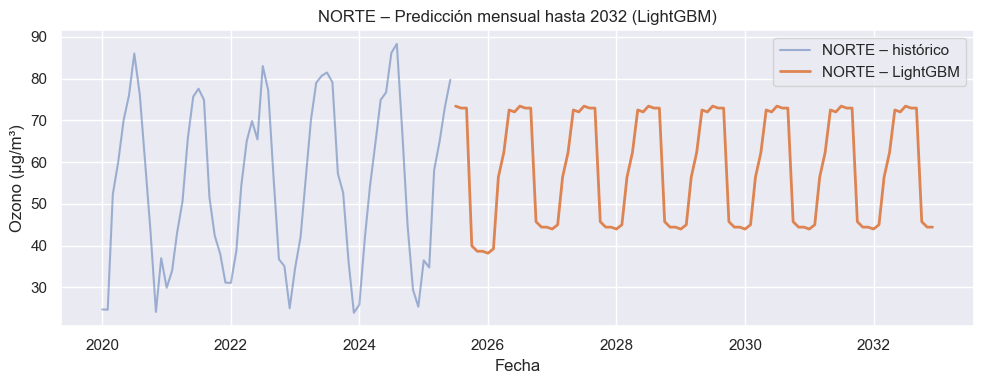

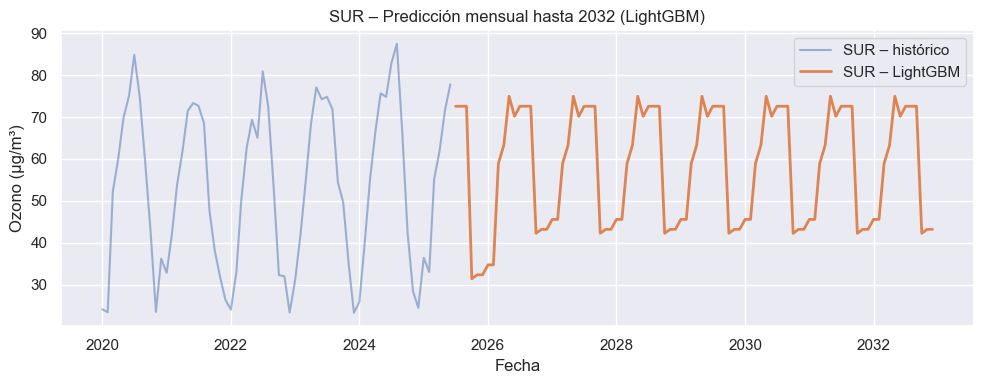

In [85]:
plt.figure(figsize=(10, 4))
plt.plot(df_hist_centro["DIA/MES/ANO"], df_hist_centro["MEDICION_ugm3"],
         label="CENTRO – histórico", alpha=0.5)
plt.plot(df_fut_centro["DIA/MES/ANO"], df_fut_centro["pred_modelo"],
         label="CENTRO – CNN1D", linewidth=2)
plt.title("CENTRO – Predicción mensual hasta 2032 (CNN1D)")
plt.xlabel("Fecha"); plt.ylabel("Ozono (µg/m³)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_hist_norte["DIA/MES/ANO"], df_hist_norte["MEDICION_ugm3"],
         label="NORTE – histórico", alpha=0.5)
plt.plot(df_fut_norte["DIA/MES/ANO"], df_fut_norte["pred_modelo"],
         label="NORTE – LightGBM", linewidth=2)
plt.title("NORTE – Predicción mensual hasta 2032 (LightGBM)")
plt.xlabel("Fecha"); plt.ylabel("Ozono (µg/m³)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_hist_sur["DIA/MES/ANO"], df_hist_sur["MEDICION_ugm3"],
         label="SUR – histórico", alpha=0.5)
plt.plot(df_fut_sur["DIA/MES/ANO"], df_fut_sur["pred_modelo"],
         label="SUR – LightGBM", linewidth=2)
plt.title("SUR – Predicción mensual hasta 2032 (LightGBM)")
plt.xlabel("Fecha"); plt.ylabel("Ozono (µg/m³)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()

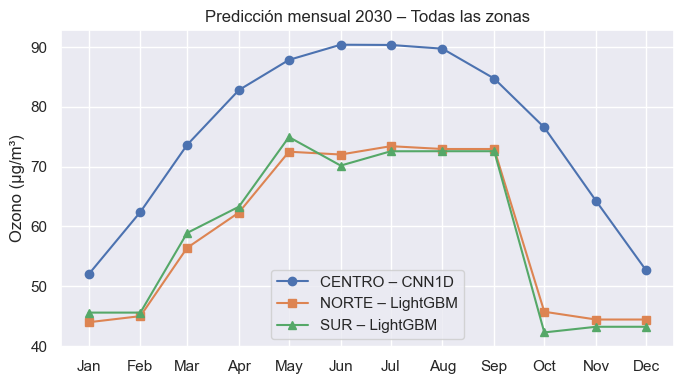

In [86]:
df_2030_centro = df_fut_centro[df_fut_centro["DIA/MES/ANO"].dt.year == 2030]
df_2030_norte  = df_fut_norte[df_fut_norte["DIA/MES/ANO"].dt.year == 2030]
df_2030_sur    = df_fut_sur[df_fut_sur["DIA/MES/ANO"].dt.year == 2030]

plt.figure(figsize=(7, 4))
plt.plot(df_2030_centro["DIA/MES/ANO"], df_2030_centro["pred_modelo"], marker="o",
         label="CENTRO – CNN1D")
plt.plot(df_2030_norte["DIA/MES/ANO"], df_2030_norte["pred_modelo"], marker="s",
         label="NORTE – LightGBM")
plt.plot(df_2030_sur["DIA/MES/ANO"], df_2030_sur["pred_modelo"], marker="^",
         label="SUR – LightGBM")
plt.title("Predicción mensual 2030 – Todas las zonas")
plt.xticks(df_2030_centro["DIA/MES/ANO"],
           [d.strftime("%b") for d in df_2030_centro["DIA/MES/ANO"]])
plt.ylabel("Ozono (µg/m³)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [87]:
plt.figure(figsize=(7, 4))
plt.plot(df_2030_centro["DIA/MES/ANO"], df_2030_centro["pred_modelo"], marker="o", label="CENTRO – CNN1D")
plt.plot(df_2030_norte["DIA/MES/ANO"], df_2030_norte["pred_modelo"], marker="s", label="NORTE – LightGBM")
plt.plot(df_2030_sur["DIA/MES/ANO"], df_2030_sur["pred_modelo"], marker="^", label="SUR – LightGBM")
plt.title("Predicción mensual 2030 – Todas las zonas")
plt.xticks(df_2030_centro["DIA/MES/ANO"], [d.strftime("%b") for d in df_2030_centro["DIA/MES/ANO"]])
plt.ylabel("Ozono (µg/m³)")
plt.grid(True); plt.legend(); plt.tight_layout()
guardar_fig("Predicciones_mensuales_2030_todas.png")

✅ Figura guardada: 07_Figs\09_predicciones_tráfico_MAG14\Predicciones_mensuales_2030_todas.png


Media anual 2030 (µg/m³):
  CENTRO (CNN1D):  75.61
  NORTE  (LGBM):   58.84
  SUR    (LGBM):   58.74


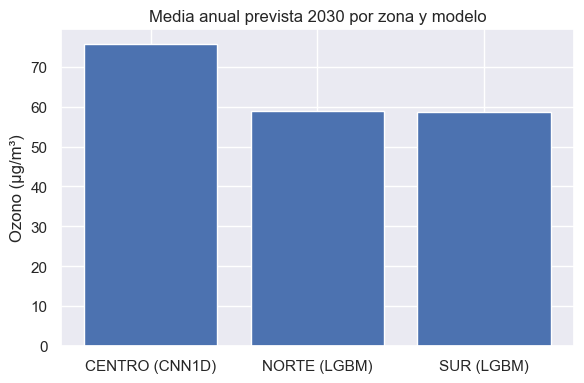

In [88]:
m2030_centro = cal_media_2030(df_fut_centro)
m2030_norte  = cal_media_2030(df_fut_norte)
m2030_sur    = cal_media_2030(df_fut_sur)

df_pred_2030_traf_nuevo = pd.DataFrame([
    {"modelo": "CNN1D_TRAF",    "zona": "CENTRO", "promedio_anual_2030": round(m2030_centro, 3)},
    {"modelo": "LightGBM_TRAF", "zona": "NORTE",  "promedio_anual_2030": round(m2030_norte, 3)},
    {"modelo": "LightGBM_TRAF", "zona": "SUR",    "promedio_anual_2030": round(m2030_sur, 3)},
])

print("Media anual 2030 (µg/m³):")
print(f"  CENTRO (CNN1D):  {m2030_centro:.2f}")
print(f"  NORTE  (LGBM):   {m2030_norte:.2f}")
print(f"  SUR    (LGBM):   {m2030_sur:.2f}")

plt.figure(figsize=(6, 4))
plt.bar(
    ["CENTRO (CNN1D)", "NORTE (LGBM)", "SUR (LGBM)"],
    [m2030_centro, m2030_norte, m2030_sur]
)
plt.title("Media anual prevista 2030 por zona y modelo")
plt.ylabel("Ozono (µg/m³)")
plt.tight_layout()
plt.show()

In [89]:
plt.figure(figsize=(6, 4))
plt.bar(["CENTRO (CNN1D)", "NORTE (LGBM)", "SUR (LGBM)"],
        [m2030_centro, m2030_norte, m2030_sur])
plt.title("Media anual prevista 2030 por zona y modelo")
plt.ylabel("Ozono (µg/m³)")
plt.tight_layout()
guardar_fig("Promedio_anual_2030_por_zona.png")

✅ Figura guardada: 07_Figs\09_predicciones_tráfico_MAG14\Promedio_anual_2030_por_zona.png


### CUADRO COMPARATIVA MODELOS II

In [90]:
# ==========================================================
# 1️⃣ Convertir listas a DataFrames
# ==========================================================
df_rmse = pd.DataFrame(tabla_rmse_modelos)
df_pred_2030 = pd.DataFrame(tabla_predicciones_2030)

# Unir RMSEs de ARIMA/SARIMA + ML + deep learning + tráfico
df_rmse = pd.concat([df_rmse, df_resultados_ml], ignore_index=True)
df_rmse = pd.concat(
    [df_rmse, df_resultados_dl_std, df_resultados_traf_tab],
    ignore_index=True
)

# 🔹 NUEVO: predicciones 2030 de los modelos de tráfico que acabamos de calcular
df_pred_2030_traf_nuevo = pd.DataFrame([
    {"modelo": "CNN1D_TRAF",    "zona": "CENTRO", "promedio_anual_2030": round(m2030_centro, 3)},
    {"modelo": "LightGBM_TRAF", "zona": "NORTE",  "promedio_anual_2030": round(m2030_norte, 3)},
    {"modelo": "LightGBM_TRAF", "zona": "SUR",    "promedio_anual_2030": round(m2030_sur, 3)},
])

# Unir predicción 2030 de ARIMA/SARIMA + ML + deep learning
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_ml], ignore_index=True)
df_pred_2030 = pd.concat([df_pred_2030, df_promedios_2030_dl], ignore_index=True)

# 🔹 y ahora añadimos las nuevas (tráfico)
df_pred_2030 = pd.concat([df_pred_2030, df_pred_2030_traf_nuevo], ignore_index=True)

# ==========================================================
# 2️⃣ Agrupar predicciones 2030 (modelo + zona)
# ==========================================================
df_pred_2030_resumen = (
    df_pred_2030
    .drop(columns=["pred_2030"], errors="ignore")
    .groupby(["modelo", "zona"], as_index=False)
    .agg({"promedio_anual_2030": "mean"})
    .sort_values(by=["zona", "promedio_anual_2030"], ascending=[True, True])
)

# ==========================================================
# 3️⃣ Ordenar tabla RMSE por zona
# ==========================================================
df_rmse = (
    df_rmse
    .sort_values(by=["zona", "RMSE_test"], ascending=[True, True])
    .drop(columns=["order", "seasonal_order", "AIC", "n_train", "n_test"], errors="ignore")
)

# ==========================================================
# 4️⃣ Mostrar resultados
# ==========================================================
print("\n>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<")
print(df_rmse.round(3).to_string(index=False))

print("\n>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<")
print(df_pred_2030_resumen.round(3).to_string(index=False))

# ==========================================================
# 5️⃣ Modelos con menor RMSE por zona
# ==========================================================
mejores_modelos_por_zona = (
    df_rmse
    .sort_values(["zona", "RMSE_test"], ascending=[True, True])
    .groupby("zona", as_index=False)
    .first()[["zona", "modelo", "RMSE_test"]]
)

print("\n>>> MODELOS CON MENOR RMSE POR ZONA <<<")
print(mejores_modelos_por_zona.round(3).to_string(index=False))

# ==========================================================
# 6️⃣ Predicciones 2030 solo de esos modelos
# ==========================================================
df_pred_mejores_2030 = pd.merge(
    mejores_modelos_por_zona[["zona", "modelo"]],
    df_pred_2030_resumen,
    on=["zona", "modelo"],
    how="left"
)

print("\n>>> PREDICCIONES 2030 DE LOS MEJORES MODELOS (por zona) <<<")
print(df_pred_mejores_2030.round(3).to_string(index=False))



>>> TABLA DE RMSE POR MODELO Y ZONA (ordenada) <<<
       modelo   zona  RMSE_test
   CNN1D_TRAF CENTRO      5.174
        CNN1D CENTRO      6.548
       SARIMA CENTRO      6.784
     CatBoost CENTRO      7.417
     LightGBM CENTRO      7.577
      XGBoost CENTRO      8.459
CatBoost_TRAF CENTRO      8.910
         LSTM CENTRO     10.365
        ARIMA CENTRO     20.669
     LightGBM  NORTE      4.629
       SARIMA  NORTE      5.641
      XGBoost  NORTE      5.694
     CatBoost  NORTE      5.731
CatBoost_TRAF  NORTE      7.240
LightGBM_TRAF  NORTE      8.568
         LSTM  NORTE     11.250
        ARIMA  NORTE     19.028
        CNN1D  NORTE     19.591
     LightGBM    SUR      5.576
     CatBoost    SUR      6.230
       SARIMA    SUR      6.454
      XGBoost    SUR      6.718
LightGBM_TRAF    SUR      7.239
CatBoost_TRAF    SUR      7.375
        ARIMA    SUR     18.894
         LSTM    SUR     19.091
        CNN1D    SUR     20.094

>>> TABLA RESUMEN DE PROMEDIOS 2030 (agrupada) <<<


## PREDICCIONES MEJORES RESULTADOS


>>> PREDICCIONES ANUALES (MEDIA POR AÑO) – ZONA CENTRO <<<
       CNN1D  CNN1D_TRAF  SARIMA
anio                            
2025  50.265      62.261  52.290
2026  50.265      61.898  55.106
2027  50.265      65.400  55.848
2028  50.265      68.887  56.601
2029  50.265      72.294  57.363
2030  50.265      75.610  58.135
2031  50.265      78.804  58.918
2032  50.265      81.952  59.712


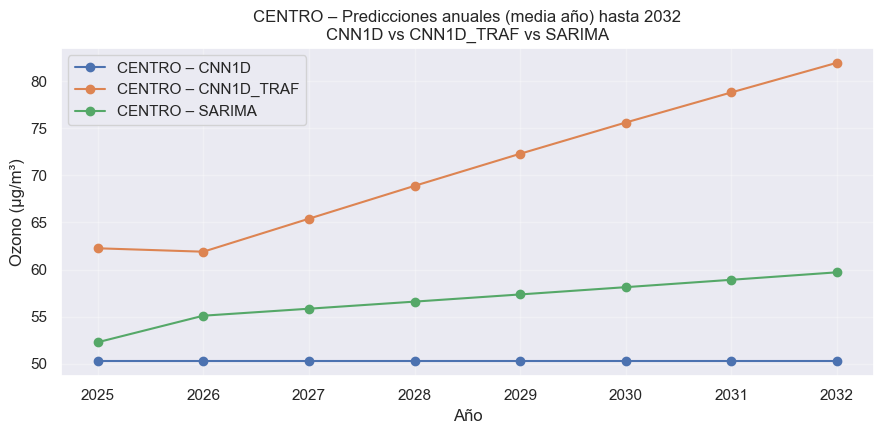


📁 Gráfico guardado en: 07_Figs\10_MEJORES PREDICCIONES_MAG14\CENTRO_comparativo_anual_CNN1D_CNN1D_TRAF_SARIMA.png


In [91]:
# =================================================
# 1. CONFIGURACIÓN DE CARPETAS (solo CENTRO)
# =================================================
CARPETA_BASE = "07_Figs"
SUBCARPETA = "10_MEJORES PREDICCIONES_MAG14"
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

zona = "CENTRO"
paquete_cnn = modelos_dl_entrenados[zona]["CNN1D"]

# Forecast hasta 2032 con la MISMA CNN1D 
df_fore_centro_dl = forecast_dl_escalado(
    df_hist=df_hist_centro,
    paquete=paquete_cnn,
    fecha_fin="2032-12-01"
)
# =================================================
# 2. PREPARAR SERIES MENSUALES PARA CENTRO
# =================================================

# --- 2.1 CNN1D (sin tráfico) ---
df_cnn1d = df_fore_centro_dl.copy()
df_cnn1d.index = pd.to_datetime(df_cnn1d.index)
df_cnn1d = df_cnn1d[["pred"]].rename(columns={"pred": "pred_CNN1D"})

# --- 2.2 CNN1D_TRAF (con variables de tráfico) ---
df_cnn1d_traf = df_fut_centro.copy()
df_cnn1d_traf["DIA/MES/ANO"] = pd.to_datetime(df_cnn1d_traf["DIA/MES/ANO"])
df_cnn1d_traf = (
    df_cnn1d_traf
    .set_index("DIA/MES/ANO")[["pred_modelo"]]
    .rename(columns={"pred_modelo": "pred_CNN1D_TRAF"})
)

# --- 2.3 SARIMA (predicciones largas para CENTRO) ---
df_sarima = predicciones_largo_plazo["CENTRO"].copy()
df_sarima.index = pd.to_datetime(df_sarima.index)
df_sarima = df_sarima[["pred"]].rename(columns={"pred": "pred_SARIMA"})

# =================================================
# 3. CÁLCULO DE MEDIAS ANUALES SOLO 2025–2032
# =================================================

# Filtrar tramo futuro explícitamente
df_cnn1d_fut      = df_cnn1d[df_cnn1d.index.year      >= 2025]
df_cnn1d_traf_fut = df_cnn1d_traf[df_cnn1d_traf.index.year >= 2025]
df_sarima_fut     = df_sarima[df_sarima.index.year    >= 2025]

serie_cnn1d      = media_anual(df_cnn1d_fut,      "pred_CNN1D",      "CNN1D")
serie_cnn1d_traf = media_anual(df_cnn1d_traf_fut, "pred_CNN1D_TRAF", "CNN1D_TRAF")
serie_sarima     = media_anual(df_sarima_fut,     "pred_SARIMA",     "SARIMA")

df_anual_centro = pd.concat(
    [serie_cnn1d, serie_cnn1d_traf, serie_sarima],
    axis=1
).sort_index()

df_anual_centro = df_anual_centro[(df_anual_centro.index >= 2025) &
                                  (df_anual_centro.index <= 2032)]

print("\n>>> PREDICCIONES ANUALES (MEDIA POR AÑO) – ZONA CENTRO <<<")
print(df_anual_centro.round(3).to_string())


# =================================================
# 4. GRÁFICO COMPARATIVO ANUAL (CENTRO, 3 MODELOS)
# =================================================

plt.figure(figsize=(9, 4.5))

plt.plot(df_anual_centro.index, df_anual_centro["CNN1D"],        marker="o", label="CENTRO – CNN1D")
plt.plot(df_anual_centro.index, df_anual_centro["CNN1D_TRAF"],   marker="o", label="CENTRO – CNN1D_TRAF")
plt.plot(df_anual_centro.index, df_anual_centro["SARIMA"],       marker="o", label="CENTRO – SARIMA")

plt.title("CENTRO – Predicciones anuales (media año) hasta 2032\nCNN1D vs CNN1D_TRAF vs SARIMA")
plt.xlabel("Año")
plt.ylabel("Ozono (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_fig = os.path.join(CARPETA_SALIDA, "CENTRO_comparativo_anual_CNN1D_CNN1D_TRAF_SARIMA.png")
plt.savefig(ruta_fig, dpi=150)
plt.show()
plt.close()

print(f"\n📁 Gráfico guardado en: {ruta_fig}")

σ(train) = 3.8951  (n=162)


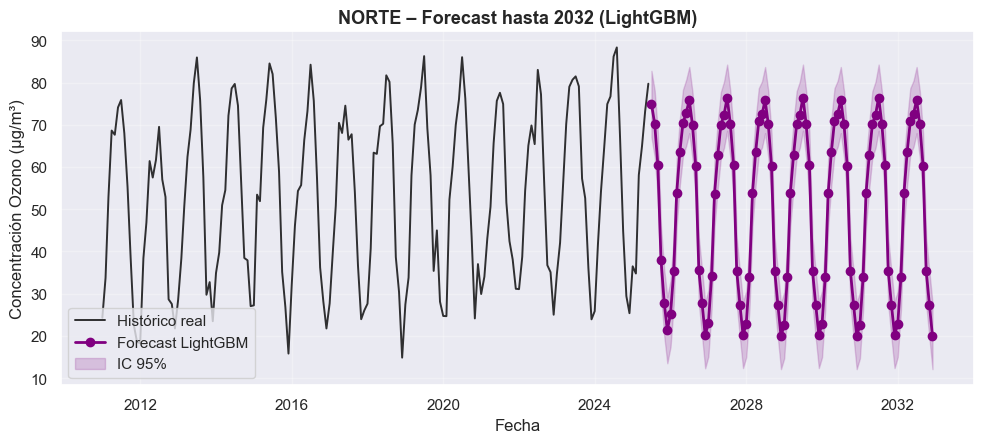

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG14\NORTE_largo_LightGBM.png
σ(train) = 0.3297  (n=162)


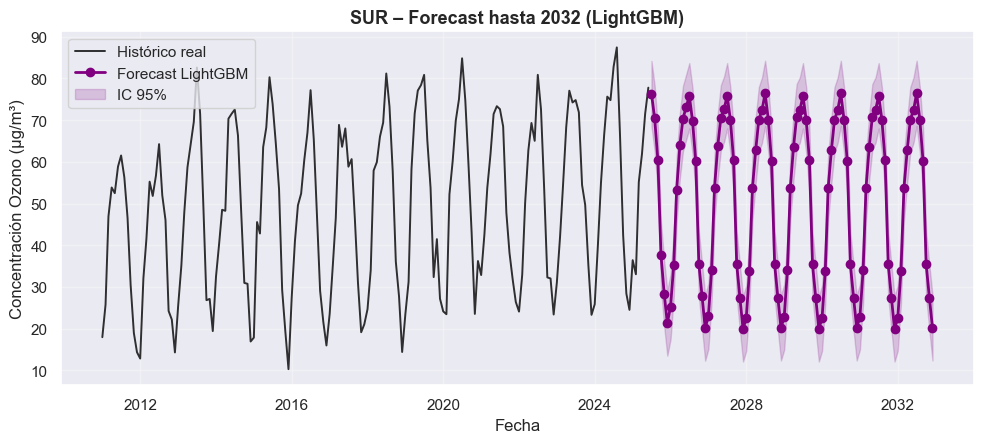

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG14\SUR_largo_LightGBM.png


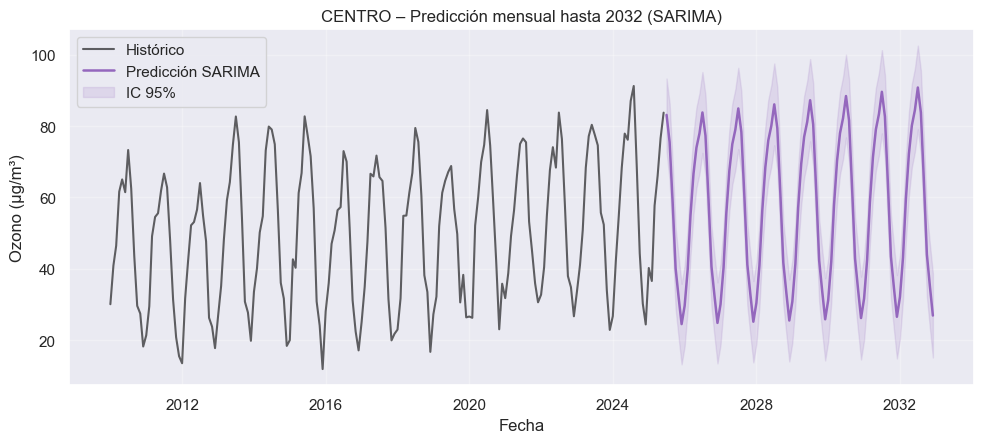

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG14\CENTRO_SARIMA_largo_plazo.png


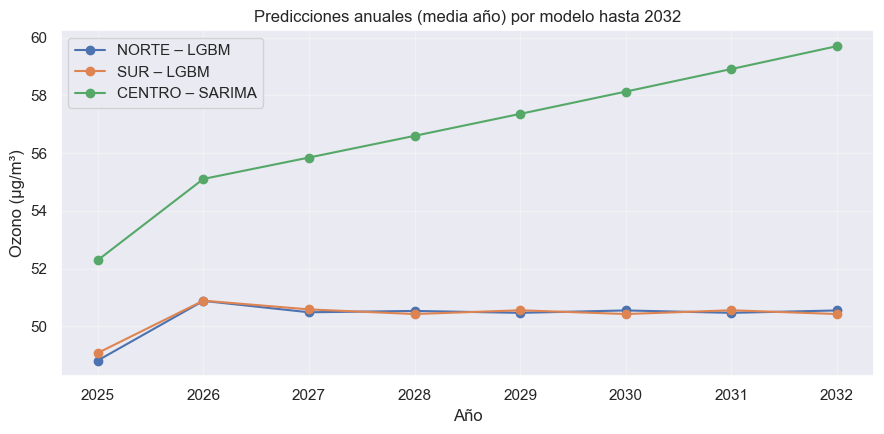

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG14\comparativo_anual_LGBM_vs_SARIMA.png


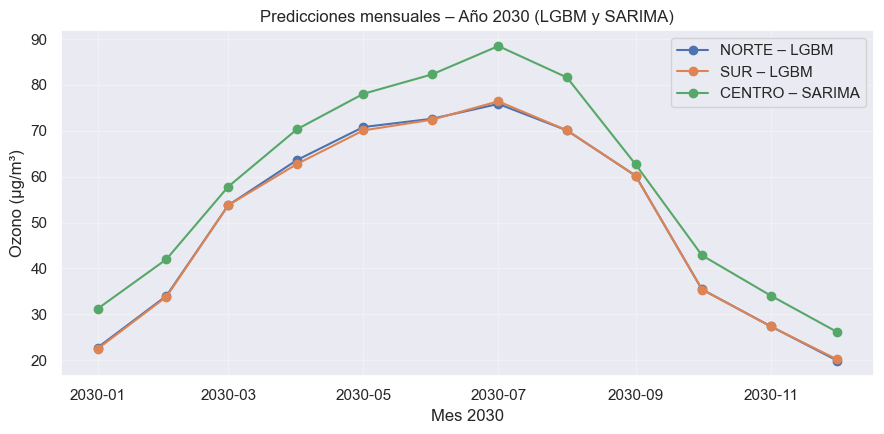

📁 Guardado: 07_Figs\10_MEJORES PREDICCIONES_MAG14\comparativo_mensual_2030_LGBM_vs_SARIMA.png


In [92]:
# =================================================
# 1. CONFIGURACIÓN DE CARPETAS
# =================================================
CARPETA_SALIDA = os.path.join(CARPETA_BASE, SUBCARPETA)
os.makedirs(CARPETA_SALIDA, exist_ok=True)

# ==========================================================
# 3. GRÁFICOS INDIVIDUALES HASTA 2032
#    - NORTE  (LGBM)
#    - SUR    (LGBM)
#    - CENTRO (SARIMA, con formato similar)
# ==========================================================

# -------------------------
# 3.1 NORTE (LGBM)
# -------------------------
pack_norte = predicciones_futuras_ml["NORTE"]
df_fore_norte = pack_norte["forecast"].copy()
if "pred" not in df_fore_norte.columns:
    if "pred_modelo" in df_fore_norte.columns:
        df_fore_norte = df_fore_norte.rename(columns={"pred_modelo": "pred"})
    elif "pred_catboost" in df_fore_norte.columns:
        df_fore_norte = df_fore_norte.rename(columns={"pred_catboost": "pred"})

df_hist_norte = df_ml_zona["NORTE"].copy().sort_index()
modelo_norte = mejor_modelo_por_zona["NORTE"]  # LightGBM u otro ML
Xtr_norte = Xtr_zona["NORTE"]
ytr_norte = ytr_zona["NORTE"]

plot_largo_por_zona_ml(
    zona="NORTE",
    df_hist=df_hist_norte,
    modelo_entrenado=modelo_norte,
    X_train=Xtr_norte,
    y_train=ytr_norte,
    df_forecast=df_fore_norte,
    nombre_modelo="LightGBM",
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=Xtr_norte.columns.tolist(),
    mostrar=True
)

# -------------------------
# 3.2 SUR (LGBM)
# -------------------------
pack_sur = predicciones_futuras_ml["SUR"]
df_fore_sur = pack_sur["forecast"].copy()
if "pred" not in df_fore_sur.columns:
    if "pred_modelo" in df_fore_sur.columns:
        df_fore_sur = df_fore_sur.rename(columns={"pred_modelo": "pred"})
    elif "pred_catboost" in df_fore_sur.columns:
        df_fore_sur = df_fore_sur.rename(columns={"pred_catboost": "pred"})

df_hist_sur = df_ml_zona["SUR"].copy().sort_index()
modelo_sur = mejor_modelo_por_zona["SUR"]  # LightGBM
Xtr_sur = Xtr_zona["SUR"]
ytr_sur = ytr_zona["SUR"]

plot_largo_por_zona_ml(
    zona="SUR",
    df_hist=df_hist_sur,
    modelo_entrenado=modelo_sur,
    X_train=Xtr_sur,
    y_train=ytr_sur,
    df_forecast=df_fore_sur,
    nombre_modelo="LightGBM",
    ruta_salida_dir=CARPETA_SALIDA,
    feature_cols=Xtr_sur.columns.tolist(),
    mostrar=True
)

# -------------------------
# 3.3 CENTRO (SARIMA – gráfico manual con mismo estilo)
# -------------------------
# Histórico univariante usado en el SARIMA
serie_centro = series_zonas["CENTRO"]  # Serie mensual de ozono en CENTRO
df_hist_centro = serie_centro.to_frame(name="MEDICION_ugm3").copy()

# Predicciones largas SARIMA para CENTRO
df_fore_centro_sarima = predicciones_largo_plazo["CENTRO"].copy()
df_fore_centro_sarima = df_fore_centro_sarima.sort_index()  # columnas: pred, ic_inf, ic_sup

plt.figure(figsize=(10, 4.6))

# Histórico
plt.plot(df_hist_centro.index, df_hist_centro["MEDICION_ugm3"],
         label="Histórico", color="black", alpha=0.6)

# Predicción futura
plt.plot(df_fore_centro_sarima.index, df_fore_centro_sarima["pred"],
         label="Predicción SARIMA", color="tab:purple", linewidth=1.8)

# Intervalo de confianza 95%
if {"ic_inf", "ic_sup"}.issubset(df_fore_centro_sarima.columns):
    plt.fill_between(
        df_fore_centro_sarima.index,
        df_fore_centro_sarima["ic_inf"],
        df_fore_centro_sarima["ic_sup"],
        color="tab:purple", alpha=0.15, label="IC 95%"
    )

plt.title("CENTRO – Predicción mensual hasta 2032 (SARIMA)")
plt.xlabel("Fecha")
plt.ylabel("Ozono (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

ruta_centro_sarima = os.path.join(CARPETA_SALIDA, "CENTRO_SARIMA_largo_plazo.png")
plt.savefig(ruta_centro_sarima, dpi=150)
plt.show()
plt.close()
print(f"📁 Guardado: {ruta_centro_sarima}")

# ==========================================================
# 4. GRÁFICO COMPARATIVO ANUAL (3 SERIES)
#    - NORTE LGBM
#    - SUR   LGBM
#    - Centro SARIMA
# ==========================================================
plt.figure(figsize=(9, 4.5))

# NORTE
df_an_norte = df_fore_norte.copy()
df_an_norte.index = pd.to_datetime(df_an_norte.index)
df_an_norte["year"] = df_an_norte.index.year
anual_norte = df_an_norte.groupby("year")["pred"].mean()
plt.plot(anual_norte.index, anual_norte.values, marker="o", label="NORTE – LGBM")

# SUR
df_an_sur = df_fore_sur.copy()
df_an_sur.index = pd.to_datetime(df_an_sur.index)
df_an_sur["year"] = df_an_sur.index.year
anual_sur = df_an_sur.groupby("year")["pred"].mean()
plt.plot(anual_sur.index, anual_sur.values, marker="o", label="SUR – LGBM")

# CENTRO (SARIMA)
df_an_centro_sarima = df_fore_centro_sarima.copy()
df_an_centro_sarima.index = pd.to_datetime(df_an_centro_sarima.index)
df_an_centro_sarima["year"] = df_an_centro_sarima.index.year
anual_centro_sarima = df_an_centro_sarima.groupby("year")["pred"].mean()
plt.plot(anual_centro_sarima.index, anual_centro_sarima.values, marker="o", label="CENTRO – SARIMA")

plt.title("Predicciones anuales (media año) por modelo hasta 2032")
plt.xlabel("Año")
plt.ylabel("Ozono (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_anual = os.path.join(CARPETA_SALIDA, "comparativo_anual_LGBM_vs_SARIMA.png")
plt.savefig(out_anual, dpi=150)
plt.show()
plt.close()
print(f"📁 Guardado: {out_anual}")

# ==========================================================
# 5. GRÁFICO COMPARATIVO MENSUAL 2030 (3 SERIES)
# ==========================================================
plt.figure(figsize=(9, 4.5))

# NORTE 2030
df_2030_norte = df_fore_norte[df_fore_norte.index.year == 2030]
plt.plot(df_2030_norte.index, df_2030_norte["pred"], marker="o", label="NORTE – LGBM")

# SUR 2030
df_2030_sur = df_fore_sur[df_fore_sur.index.year == 2030]
plt.plot(df_2030_sur.index, df_2030_sur["pred"], marker="o", label="SUR – LGBM")

# CENTRO 2030 (SARIMA)
df_2030_centro_sarima = df_fore_centro_sarima[df_fore_centro_sarima.index.year == 2030]
plt.plot(df_2030_centro_sarima.index, df_2030_centro_sarima["pred"], marker="o", label="CENTRO – SARIMA")

plt.title("Predicciones mensuales – Año 2030 (LGBM y SARIMA)")
plt.xlabel("Mes 2030")
plt.ylabel("Ozono (µg/m³)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

out_mensual = os.path.join(CARPETA_SALIDA, "comparativo_mensual_2030_LGBM_vs_SARIMA.png")
plt.savefig(out_mensual, dpi=150)
plt.show()
plt.close()
print(f"📁 Guardado: {out_mensual}")


In [93]:
resultados_2030 = []

# =========================
# 1) LGBM – SOLO NORTE Y SUR
# =========================
for zona in ["NORTE", "SUR"]:   # <-- Filtrado explícito
    if zona not in predicciones_futuras_ml:
        continue

    df_fore = predicciones_futuras_ml[zona]["forecast"].copy()

    # Asegurar columna pred
    if "pred" not in df_fore.columns:
        if "pred_modelo" in df_fore.columns:
            df_fore = df_fore.rename(columns={"pred_modelo": "pred"})
        elif "pred_catboost" in df_fore.columns:
            df_fore = df_fore.rename(columns={"pred_catboost": "pred"})

    df_fore.index = pd.to_datetime(df_fore.index)
    df_2030 = df_fore[df_fore.index.year == 2030]

    if df_2030.empty:
        continue

    media = df_2030["pred"].mean()

    resultados_2030.append({
        "modelo": "LightGBM",
        "zona": zona,
        "promedio_anual_2030": media
    })


# =========================
# 2) SARIMA – SOLO CENTRO
# =========================
zona = "CENTRO"
if zona in predicciones_largo_plazo:

    df_sar = predicciones_largo_plazo[zona].copy()
    df_sar.index = pd.to_datetime(df_sar.index)

    df_2030_sar = df_sar[df_sar.index.year == 2030]

    if not df_2030_sar.empty:
        media_sar = df_2030_sar["pred"].mean()

        resultados_2030.append({
            "modelo": "SARIMA",
            "zona": zona,
            "promedio_anual_2030": media_sar
        })


# =========================
# 3) TABLA FINAL
# =========================
df_promedios_2030_modelos = (
    pd.DataFrame(resultados_2030)
      .sort_values(["zona", "modelo"])
      .reset_index(drop=True)
)

print("\n>>> PROMEDIOS ANUALES 2030 (LightGBM para Norte/Sur y SARIMA para Centro) <<<")
print(df_promedios_2030_modelos.round(3).to_string(index=False))



>>> PROMEDIOS ANUALES 2030 (LightGBM para Norte/Sur y SARIMA para Centro) <<<
  modelo   zona  promedio_anual_2030
  SARIMA CENTRO               58.135
LightGBM  NORTE               50.547
LightGBM    SUR               50.422


In [94]:
df_pred_sur = predicciones_largo_plazo ["SUR"]["pred"].copy()
df_pred_sur.index = pd.to_datetime(df_pred_sur.index)

In [95]:
df_O3_sur = df_pred_sur

In [96]:
df_O3_sur = df_O3_sur.to_frame(name="pred")

In [97]:
df_O3_sur

pred
2025-07-01  82.156636
2025-08-01  73.868834
2025-09-01  57.433484
2025-10-01  37.601262
2025-11-01  30.742970
...               ...
2032-08-01  83.775126
2032-09-01  64.189706
2032-10-01  42.456955
2032-11-01  34.463697
2032-12-01  25.707200

[90 rows x 1 columns]

In [98]:
df_O3_sur.to_parquet("07.02_df_O3_sur.parquet", engine="pyarrow", index=False)